In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.relu0 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.relu0(self.bn0(self.fc0(out))))
        out = self.drop1(self.relu1(self.bn1(self.fc1(out))))
        out = self.drop2(self.relu2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2580, Acc: 0.9205 | Val Loss: 0.1513, Acc: 0.9550


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9592 | Val Loss: 0.1298, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9683 | Val Loss: 0.1071, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.1137, Acc: 0.9662


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9764 | Val Loss: 0.1044, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9805 | Val Loss: 0.1069, Acc: 0.9674


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 0.1053, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.1043, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.1074, Acc: 0.9725


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0946, Acc: 0.9739


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.0957, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.1129, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1014, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9730


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1176, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.1158, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1196, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1126, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.1064, Acc: 0.9739


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.1058, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1010, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1217, Acc: 0.9719


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1210, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1268, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1180, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1200, Acc: 0.9733


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1106, Acc: 0.9726


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1113, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1161, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1241, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1114, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1213, Acc: 0.9723


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1150, Acc: 0.9721


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1214, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1175, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1290, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1176, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0946, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1187, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1294, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1062, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1505, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1117, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1267, Acc: 0.9737


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1440, Acc: 0.9743


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1462, Acc: 0.9748


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1461, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1476, Acc: 0.9738


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1246, Acc: 0.9729


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1195, Acc: 0.9720


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0966, Acc: 0.9764


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1124, Acc: 0.9746


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1399, Acc: 0.9748


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1113, Acc: 0.9738


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1078, Acc: 0.9753


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1263, Acc: 0.9748


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1364, Acc: 0.9745


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1410, Acc: 0.9756


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1496, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1341, Acc: 0.9729


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1274, Acc: 0.9742


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1170, Acc: 0.9747


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1336, Acc: 0.9745


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1145, Acc: 0.9752


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1698, Acc: 0.9733


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1080, Acc: 0.9737


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1459, Acc: 0.9715


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1321, Acc: 0.9732


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1170, Acc: 0.9732


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1343, Acc: 0.9754


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1135, Acc: 0.9739


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1875, Acc: 0.9728


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1282, Acc: 0.9731


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1206, Acc: 0.9744


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1480, Acc: 0.9738


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1289, Acc: 0.9758


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1477, Acc: 0.9761


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1352, Acc: 0.9759


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1332, Acc: 0.9749


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1203, Acc: 0.9732


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1395, Acc: 0.9728


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1265, Acc: 0.9759


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1277, Acc: 0.9726


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1744, Acc: 0.9738


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1330, Acc: 0.9752


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1393, Acc: 0.9749


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1564, Acc: 0.9751


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1197, Acc: 0.9738


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1582, Acc: 0.9741


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1199, Acc: 0.9733


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1692, Acc: 0.9728


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1517, Acc: 0.9746


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1650, Acc: 0.9735


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1471, Acc: 0.9736


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1544, Acc: 0.9722


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1550, Acc: 0.9728


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1119, Acc: 0.9755


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1132, Acc: 0.9733


Final Test Loss: 0.1120 Accuracy: 0.9739


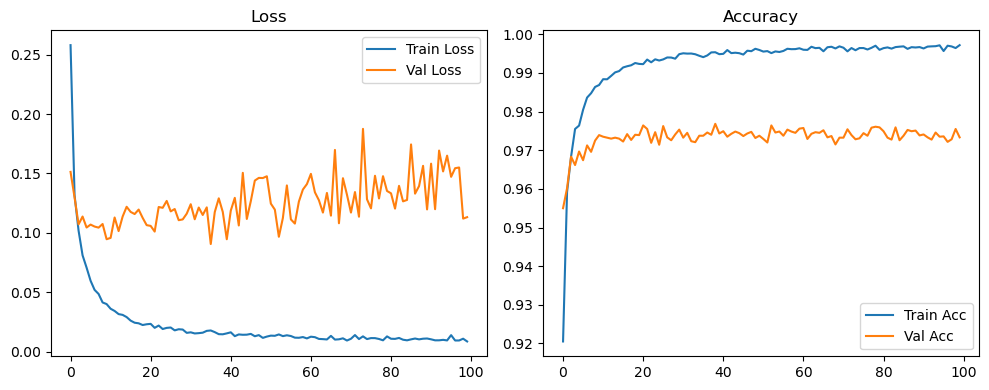

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3083, Acc: 0.9059 | Val Loss: 0.1455, Acc: 0.9542


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9465 | Val Loss: 0.1205, Acc: 0.9628


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9573 | Val Loss: 0.1177, Acc: 0.9645


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9629 | Val Loss: 0.0990, Acc: 0.9690


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9654 | Val Loss: 0.1040, Acc: 0.9689


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9690 | Val Loss: 0.1059, Acc: 0.9706


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9708 | Val Loss: 0.1019, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9731 | Val Loss: 0.0924, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9739 | Val Loss: 0.0924, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9749 | Val Loss: 0.0886, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9768 | Val Loss: 0.0946, Acc: 0.9751


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9788 | Val Loss: 0.0854, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9792 | Val Loss: 0.0940, Acc: 0.9739


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9798 | Val Loss: 0.0899, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9802 | Val Loss: 0.0907, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.0861, Acc: 0.9749


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0875, Acc: 0.9737


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0972, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9822 | Val Loss: 0.0898, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.0911, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.0966, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9852 | Val Loss: 0.0843, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0769, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9851 | Val Loss: 0.0901, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.0849, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0891, Acc: 0.9753


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0942, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0916, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.0849, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0843, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.0789, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0970, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.0974, Acc: 0.9770


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0969, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0876, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.0941, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.0970, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.0898, Acc: 0.9762


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.1089, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0894, Acc: 0.9771


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1035, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1120, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0835, Acc: 0.9757


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1037, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9859 | Val Loss: 0.0908, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.0788, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.1066, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.1061, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9774


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9885 | Val Loss: 0.0947, Acc: 0.9778


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.0927, Acc: 0.9761


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.0868, Acc: 0.9759


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9869 | Val Loss: 0.0929, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.1038, Acc: 0.9782


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0825, Acc: 0.9763


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.0811, Acc: 0.9769


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.0881, Acc: 0.9773


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.1082, Acc: 0.9765


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.0769, Acc: 0.9783


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.1154, Acc: 0.9758


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9882 | Val Loss: 0.0853, Acc: 0.9761


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.0928, Acc: 0.9769


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9877 | Val Loss: 0.0802, Acc: 0.9771


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.1057, Acc: 0.9762


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0999, Acc: 0.9742


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9886 | Val Loss: 0.1052, Acc: 0.9773


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.0923, Acc: 0.9756


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.1237, Acc: 0.9756


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1052, Acc: 0.9747


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0914, Acc: 0.9767


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.1090, Acc: 0.9766


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.1262, Acc: 0.9780


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.0980, Acc: 0.9765


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9876 | Val Loss: 0.0921, Acc: 0.9763


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0917, Acc: 0.9762


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.1072, Acc: 0.9764


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.1092, Acc: 0.9749


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.1265, Acc: 0.9753


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.0976, Acc: 0.9757


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0985, Acc: 0.9764


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.0874, Acc: 0.9774


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0919, Acc: 0.9781


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9885 | Val Loss: 0.0934, Acc: 0.9772


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9889 | Val Loss: 0.1127, Acc: 0.9748


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.0891, Acc: 0.9748


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9884 | Val Loss: 0.1054, Acc: 0.9752


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.0899, Acc: 0.9762


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1080, Acc: 0.9764


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1156, Acc: 0.9758


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0868, Acc: 0.9765


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9888 | Val Loss: 0.0918, Acc: 0.9768


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9886 | Val Loss: 0.1324, Acc: 0.9769


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0997, Acc: 0.9768


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9883 | Val Loss: 0.0908, Acc: 0.9769


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0942, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9890 | Val Loss: 0.1004, Acc: 0.9754


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.1111, Acc: 0.9752


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9882 | Val Loss: 0.0936, Acc: 0.9767


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.0916, Acc: 0.9764


Final Test Loss: 0.0821 Accuracy: 0.9788


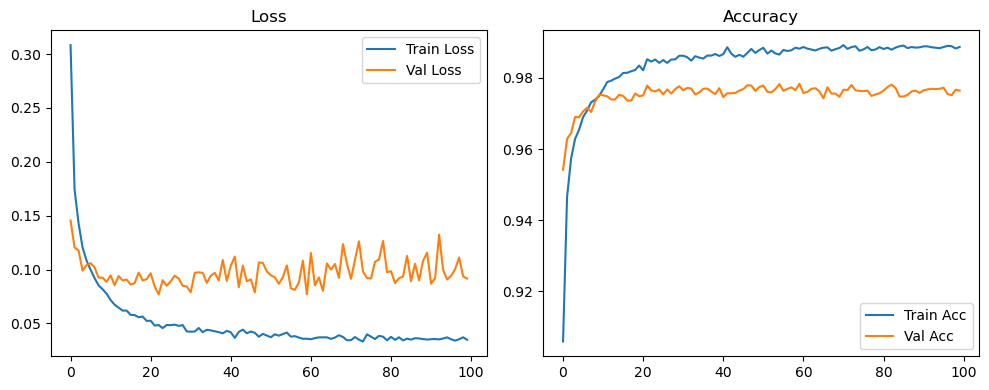

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4684, Acc: 0.8594 | Val Loss: 0.1772, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2946, Acc: 0.9136 | Val Loss: 0.1498, Acc: 0.9561


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2597, Acc: 0.9242 | Val Loss: 0.1368, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2390, Acc: 0.9307 | Val Loss: 0.1281, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2231, Acc: 0.9342 | Val Loss: 0.1219, Acc: 0.9631


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2132, Acc: 0.9381 | Val Loss: 0.1252, Acc: 0.9641


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2021, Acc: 0.9407 | Val Loss: 0.1160, Acc: 0.9652


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1958, Acc: 0.9429 | Val Loss: 0.1140, Acc: 0.9660


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9437 | Val Loss: 0.1112, Acc: 0.9673


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1876, Acc: 0.9444 | Val Loss: 0.1097, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1851, Acc: 0.9454 | Val Loss: 0.1111, Acc: 0.9678


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1783, Acc: 0.9477 | Val Loss: 0.1018, Acc: 0.9694


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9490 | Val Loss: 0.1053, Acc: 0.9688


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9478 | Val Loss: 0.1089, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1676, Acc: 0.9510 | Val Loss: 0.1106, Acc: 0.9687


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1617, Acc: 0.9515 | Val Loss: 0.1053, Acc: 0.9697


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9528 | Val Loss: 0.1041, Acc: 0.9685


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1706, Acc: 0.9502 | Val Loss: 0.1107, Acc: 0.9701


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9540 | Val Loss: 0.1026, Acc: 0.9705


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1591, Acc: 0.9526 | Val Loss: 0.1098, Acc: 0.9695


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9535 | Val Loss: 0.0990, Acc: 0.9711


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9545 | Val Loss: 0.1152, Acc: 0.9695


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9547 | Val Loss: 0.0998, Acc: 0.9705


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9543 | Val Loss: 0.1005, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1513, Acc: 0.9556 | Val Loss: 0.1002, Acc: 0.9696


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9557 | Val Loss: 0.0963, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9544 | Val Loss: 0.0953, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9541 | Val Loss: 0.1067, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9549 | Val Loss: 0.0968, Acc: 0.9717


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9544 | Val Loss: 0.1089, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1499, Acc: 0.9556 | Val Loss: 0.0982, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1484, Acc: 0.9554 | Val Loss: 0.1033, Acc: 0.9703


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9561 | Val Loss: 0.1111, Acc: 0.9714


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9561 | Val Loss: 0.0969, Acc: 0.9720


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9564 | Val Loss: 0.0978, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9562 | Val Loss: 0.0973, Acc: 0.9717


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9561 | Val Loss: 0.0939, Acc: 0.9718


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9561 | Val Loss: 0.0951, Acc: 0.9718


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9585 | Val Loss: 0.0987, Acc: 0.9718


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9558 | Val Loss: 0.0969, Acc: 0.9726


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.1058, Acc: 0.9701


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9577 | Val Loss: 0.1017, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1454, Acc: 0.9567 | Val Loss: 0.0976, Acc: 0.9716


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1464, Acc: 0.9566 | Val Loss: 0.1017, Acc: 0.9725


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9566 | Val Loss: 0.1000, Acc: 0.9720


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9566 | Val Loss: 0.0966, Acc: 0.9707


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1482, Acc: 0.9571 | Val Loss: 0.0953, Acc: 0.9718


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9584 | Val Loss: 0.1088, Acc: 0.9701


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9588 | Val Loss: 0.0988, Acc: 0.9706


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1447, Acc: 0.9577 | Val Loss: 0.0979, Acc: 0.9718


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.1420, Acc: 0.9581 | Val Loss: 0.0941, Acc: 0.9724


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.1462, Acc: 0.9558 | Val Loss: 0.1050, Acc: 0.9708


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9593 | Val Loss: 0.0970, Acc: 0.9713


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9592 | Val Loss: 0.1072, Acc: 0.9722


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9591 | Val Loss: 0.1013, Acc: 0.9730


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.1423, Acc: 0.9580 | Val Loss: 0.1009, Acc: 0.9712


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.1432, Acc: 0.9563 | Val Loss: 0.1004, Acc: 0.9722


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.1376, Acc: 0.9593 | Val Loss: 0.1022, Acc: 0.9732


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9579 | Val Loss: 0.0930, Acc: 0.9735


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.1424, Acc: 0.9591 | Val Loss: 0.0958, Acc: 0.9722


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.1411, Acc: 0.9577 | Val Loss: 0.1068, Acc: 0.9716


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.1420, Acc: 0.9582 | Val Loss: 0.0971, Acc: 0.9713


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.1366, Acc: 0.9595 | Val Loss: 0.0964, Acc: 0.9732


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9599 | Val Loss: 0.1095, Acc: 0.9714


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.1358, Acc: 0.9607 | Val Loss: 0.1000, Acc: 0.9726


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.1392, Acc: 0.9592 | Val Loss: 0.1032, Acc: 0.9727


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.1364, Acc: 0.9595 | Val Loss: 0.1010, Acc: 0.9728


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.1375, Acc: 0.9599 | Val Loss: 0.0964, Acc: 0.9740


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.1386, Acc: 0.9606 | Val Loss: 0.1078, Acc: 0.9722


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.1400, Acc: 0.9577 | Val Loss: 0.0973, Acc: 0.9727


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9586 | Val Loss: 0.0982, Acc: 0.9716


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9590 | Val Loss: 0.0929, Acc: 0.9719


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.1354, Acc: 0.9601 | Val Loss: 0.1051, Acc: 0.9725


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9593 | Val Loss: 0.1073, Acc: 0.9731


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.1306, Acc: 0.9615 | Val Loss: 0.1006, Acc: 0.9724


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9592 | Val Loss: 0.0914, Acc: 0.9732


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.1395, Acc: 0.9581 | Val Loss: 0.0951, Acc: 0.9733


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.1370, Acc: 0.9595 | Val Loss: 0.0979, Acc: 0.9718


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.1410, Acc: 0.9585 | Val Loss: 0.1050, Acc: 0.9735


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.1374, Acc: 0.9598 | Val Loss: 0.0966, Acc: 0.9734


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.1348, Acc: 0.9604 | Val Loss: 0.0991, Acc: 0.9724


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.1421, Acc: 0.9587 | Val Loss: 0.0976, Acc: 0.9719


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.1440, Acc: 0.9582 | Val Loss: 0.1061, Acc: 0.9738


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.1354, Acc: 0.9599 | Val Loss: 0.0911, Acc: 0.9743


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.1390, Acc: 0.9587 | Val Loss: 0.0940, Acc: 0.9729


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.1325, Acc: 0.9604 | Val Loss: 0.0999, Acc: 0.9732


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.1386, Acc: 0.9594 | Val Loss: 0.0910, Acc: 0.9748


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.1342, Acc: 0.9613 | Val Loss: 0.0933, Acc: 0.9733


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9592 | Val Loss: 0.1015, Acc: 0.9733


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.1363, Acc: 0.9603 | Val Loss: 0.0924, Acc: 0.9722


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.1394, Acc: 0.9581 | Val Loss: 0.0998, Acc: 0.9720


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.1385, Acc: 0.9585 | Val Loss: 0.1064, Acc: 0.9732


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.1352, Acc: 0.9598 | Val Loss: 0.0941, Acc: 0.9734


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.1413, Acc: 0.9586 | Val Loss: 0.0974, Acc: 0.9726


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.1326, Acc: 0.9616 | Val Loss: 0.1157, Acc: 0.9740


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.1370, Acc: 0.9587 | Val Loss: 0.0977, Acc: 0.9738


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.1325, Acc: 0.9612 | Val Loss: 0.0956, Acc: 0.9736


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.1354, Acc: 0.9609 | Val Loss: 0.0945, Acc: 0.9738


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.1365, Acc: 0.9605 | Val Loss: 0.0958, Acc: 0.9734


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.1344, Acc: 0.9594 | Val Loss: 0.0939, Acc: 0.9739


Final Test Loss: 0.0803 Accuracy: 0.9769


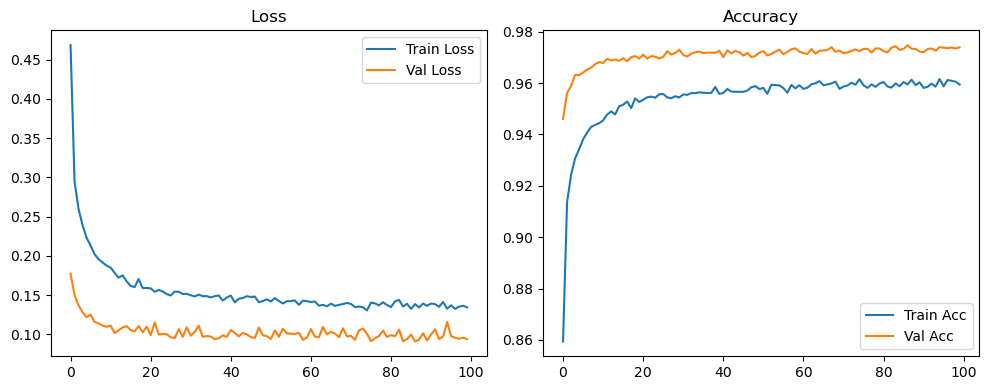

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2580, Acc: 0.9205 | Val Loss: 0.1513, Acc: 0.9550


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9592 | Val Loss: 0.1298, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9683 | Val Loss: 0.1071, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.1137, Acc: 0.9662


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9764 | Val Loss: 0.1044, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9805 | Val Loss: 0.1069, Acc: 0.9674


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 0.1053, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.1043, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.1074, Acc: 0.9725


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0946, Acc: 0.9739


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.0957, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.1129, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1014, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9730


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1176, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.1158, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1196, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1126, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.1064, Acc: 0.9739


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.1058, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1010, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1217, Acc: 0.9719


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1210, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1268, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1180, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1200, Acc: 0.9733


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1106, Acc: 0.9726


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1113, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1161, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1241, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1114, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1213, Acc: 0.9723


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1150, Acc: 0.9721


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1214, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1175, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1290, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1176, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0946, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1187, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1294, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1062, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1505, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1117, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1267, Acc: 0.9737


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1440, Acc: 0.9743


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1462, Acc: 0.9748


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1461, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1476, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1302, Acc: 0.9750


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1310, Acc: 0.9766


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1551, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1341, Acc: 0.9762


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1370, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1349, Acc: 0.9779


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1374, Acc: 0.9767


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1301, Acc: 0.9777


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1322, Acc: 0.9773


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1702, Acc: 0.9768


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1696, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1267, Acc: 0.9764


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1571, Acc: 0.9769


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1349, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1370, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1396, Acc: 0.9763


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1433, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1285, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1545, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1373, Acc: 0.9759


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1586, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1487, Acc: 0.9766


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1497, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1392, Acc: 0.9769


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1736, Acc: 0.9765


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1372, Acc: 0.9775


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1297, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1385, Acc: 0.9769


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1544, Acc: 0.9778


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1411, Acc: 0.9782


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1718, Acc: 0.9769


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1805, Acc: 0.9781


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1854, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1479, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1422, Acc: 0.9781


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1562, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1463, Acc: 0.9791


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1547, Acc: 0.9775


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1487, Acc: 0.9785


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1759, Acc: 0.9781


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1910, Acc: 0.9774


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2138, Acc: 0.9770


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1808, Acc: 0.9773


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1625, Acc: 0.9785


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1916, Acc: 0.9774


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1428, Acc: 0.9780


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1720, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1623, Acc: 0.9772


Final Test Loss: 0.1356 Accuracy: 0.9812


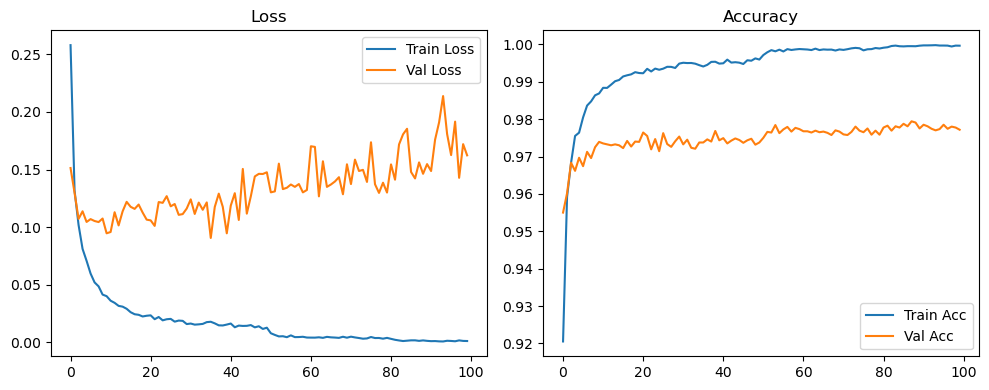

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3083, Acc: 0.9059 | Val Loss: 0.1455, Acc: 0.9542


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9465 | Val Loss: 0.1205, Acc: 0.9628


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9573 | Val Loss: 0.1177, Acc: 0.9645


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9629 | Val Loss: 0.0990, Acc: 0.9690


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9654 | Val Loss: 0.1040, Acc: 0.9689


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9690 | Val Loss: 0.1059, Acc: 0.9706


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9708 | Val Loss: 0.1019, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9731 | Val Loss: 0.0924, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9739 | Val Loss: 0.0924, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9749 | Val Loss: 0.0886, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9768 | Val Loss: 0.0946, Acc: 0.9751


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9788 | Val Loss: 0.0854, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9792 | Val Loss: 0.0940, Acc: 0.9739


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9798 | Val Loss: 0.0899, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9802 | Val Loss: 0.0907, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.0861, Acc: 0.9749


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0875, Acc: 0.9737


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0972, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9822 | Val Loss: 0.0898, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.0911, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.0966, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9852 | Val Loss: 0.0843, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0769, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9851 | Val Loss: 0.0901, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.0849, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0891, Acc: 0.9753


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0942, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0916, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.0849, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0843, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.0789, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0970, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.0974, Acc: 0.9770


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0969, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0876, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.0941, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.0970, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.0898, Acc: 0.9762


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.1089, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0894, Acc: 0.9771


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1035, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1120, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0835, Acc: 0.9757


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1037, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9859 | Val Loss: 0.0908, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.0788, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.1066, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.1061, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.0935, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0920, Acc: 0.9783


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0834, Acc: 0.9786


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0923, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.1025, Acc: 0.9770


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0921, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0824, Acc: 0.9786


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0832, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0995, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0921, Acc: 0.9806


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0880, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0921, Acc: 0.9780


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0884, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1021, Acc: 0.9780


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0827, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0988, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0864, Acc: 0.9780


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0975, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.0894, Acc: 0.9804


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0951, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0970, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1009, Acc: 0.9791


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1071, Acc: 0.9789


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0910, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1077, Acc: 0.9794


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1188, Acc: 0.9781


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9948 | Val Loss: 0.1036, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1076, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1066, Acc: 0.9794


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0922, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0931, Acc: 0.9808


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1017, Acc: 0.9793


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.0951, Acc: 0.9787


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1013, Acc: 0.9782


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0992, Acc: 0.9790


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0976, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0972, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0996, Acc: 0.9795


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1009, Acc: 0.9801


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0827, Acc: 0.9800


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1120, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1082, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1053, Acc: 0.9805


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0910, Acc: 0.9795


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0982, Acc: 0.9792


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1133, Acc: 0.9791


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.0946, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1076, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0944, Acc: 0.9797


Final Test Loss: 0.0848 Accuracy: 0.9816


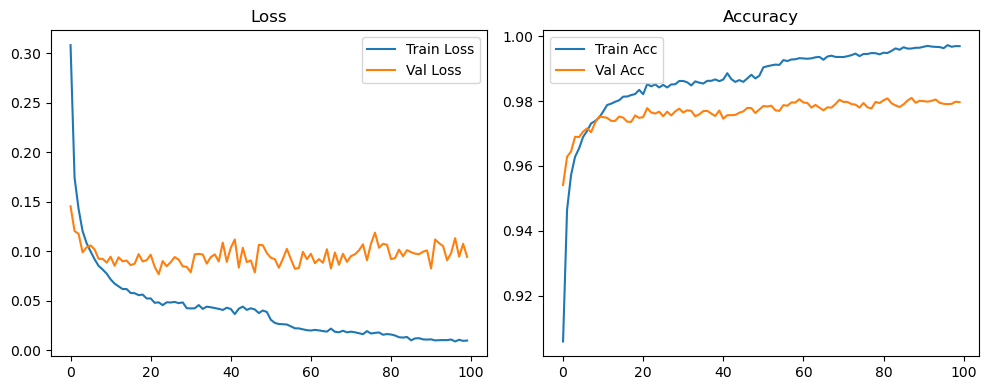

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4684, Acc: 0.8594 | Val Loss: 0.1772, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2946, Acc: 0.9136 | Val Loss: 0.1498, Acc: 0.9561


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2597, Acc: 0.9242 | Val Loss: 0.1368, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2390, Acc: 0.9307 | Val Loss: 0.1281, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2231, Acc: 0.9342 | Val Loss: 0.1219, Acc: 0.9631


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2132, Acc: 0.9381 | Val Loss: 0.1252, Acc: 0.9641


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2021, Acc: 0.9407 | Val Loss: 0.1160, Acc: 0.9652


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1958, Acc: 0.9429 | Val Loss: 0.1140, Acc: 0.9660


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9437 | Val Loss: 0.1112, Acc: 0.9673


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1876, Acc: 0.9444 | Val Loss: 0.1097, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1851, Acc: 0.9454 | Val Loss: 0.1111, Acc: 0.9678


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1783, Acc: 0.9477 | Val Loss: 0.1018, Acc: 0.9694


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9490 | Val Loss: 0.1053, Acc: 0.9688


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9478 | Val Loss: 0.1089, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1676, Acc: 0.9510 | Val Loss: 0.1106, Acc: 0.9687


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1617, Acc: 0.9515 | Val Loss: 0.1053, Acc: 0.9697


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9528 | Val Loss: 0.1041, Acc: 0.9685


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1706, Acc: 0.9502 | Val Loss: 0.1107, Acc: 0.9701


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9540 | Val Loss: 0.1026, Acc: 0.9705


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1591, Acc: 0.9526 | Val Loss: 0.1098, Acc: 0.9695


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9535 | Val Loss: 0.0990, Acc: 0.9711


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9545 | Val Loss: 0.1152, Acc: 0.9695


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9547 | Val Loss: 0.0998, Acc: 0.9705


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9543 | Val Loss: 0.1005, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1513, Acc: 0.9556 | Val Loss: 0.1002, Acc: 0.9696


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9557 | Val Loss: 0.0963, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9544 | Val Loss: 0.0953, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9541 | Val Loss: 0.1067, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9549 | Val Loss: 0.0968, Acc: 0.9717


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9544 | Val Loss: 0.1089, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1499, Acc: 0.9556 | Val Loss: 0.0982, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1484, Acc: 0.9554 | Val Loss: 0.1033, Acc: 0.9703


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9561 | Val Loss: 0.1111, Acc: 0.9714


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9561 | Val Loss: 0.0969, Acc: 0.9720


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9564 | Val Loss: 0.0978, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9562 | Val Loss: 0.0973, Acc: 0.9717


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9561 | Val Loss: 0.0939, Acc: 0.9718


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9561 | Val Loss: 0.0951, Acc: 0.9718


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9585 | Val Loss: 0.0987, Acc: 0.9718


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9558 | Val Loss: 0.0969, Acc: 0.9726


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.1058, Acc: 0.9701


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9577 | Val Loss: 0.1017, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1454, Acc: 0.9567 | Val Loss: 0.0976, Acc: 0.9716


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1464, Acc: 0.9566 | Val Loss: 0.1017, Acc: 0.9725


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9566 | Val Loss: 0.1000, Acc: 0.9720


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9566 | Val Loss: 0.0966, Acc: 0.9707


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1482, Acc: 0.9571 | Val Loss: 0.0953, Acc: 0.9718


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9584 | Val Loss: 0.1088, Acc: 0.9701


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9588 | Val Loss: 0.0988, Acc: 0.9706


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1447, Acc: 0.9577 | Val Loss: 0.0979, Acc: 0.9718


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.1332, Acc: 0.9609 | Val Loss: 0.0949, Acc: 0.9729


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.1287, Acc: 0.9611 | Val Loss: 0.1039, Acc: 0.9713


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.1231, Acc: 0.9636 | Val Loss: 0.0925, Acc: 0.9728


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.1185, Acc: 0.9652 | Val Loss: 0.0922, Acc: 0.9732


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.1167, Acc: 0.9655 | Val Loss: 0.0934, Acc: 0.9745


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.1154, Acc: 0.9656 | Val Loss: 0.0918, Acc: 0.9748


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9656 | Val Loss: 0.0968, Acc: 0.9742


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.1106, Acc: 0.9666 | Val Loss: 0.1022, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.1153, Acc: 0.9666 | Val Loss: 0.0933, Acc: 0.9738


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9667 | Val Loss: 0.0917, Acc: 0.9741


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.1106, Acc: 0.9676 | Val Loss: 0.0973, Acc: 0.9739


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.1113, Acc: 0.9665 | Val Loss: 0.0922, Acc: 0.9749


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9685 | Val Loss: 0.0865, Acc: 0.9759


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.1049, Acc: 0.9688 | Val Loss: 0.0981, Acc: 0.9748


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.1033, Acc: 0.9688 | Val Loss: 0.0970, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.1082, Acc: 0.9671 | Val Loss: 0.0965, Acc: 0.9748


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.1047, Acc: 0.9688 | Val Loss: 0.0984, Acc: 0.9744


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.1048, Acc: 0.9692 | Val Loss: 0.0938, Acc: 0.9750


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.1011, Acc: 0.9693 | Val Loss: 0.1046, Acc: 0.9744


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9696 | Val Loss: 0.1059, Acc: 0.9728


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.1044, Acc: 0.9695 | Val Loss: 0.0902, Acc: 0.9747


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0981, Acc: 0.9709 | Val Loss: 0.0877, Acc: 0.9756


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0961, Acc: 0.9714 | Val Loss: 0.0901, Acc: 0.9761


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9707 | Val Loss: 0.1094, Acc: 0.9748


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9721 | Val Loss: 0.0920, Acc: 0.9748


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.1024, Acc: 0.9699 | Val Loss: 0.0941, Acc: 0.9748


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0983, Acc: 0.9695 | Val Loss: 0.0954, Acc: 0.9752


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0995, Acc: 0.9714 | Val Loss: 0.1039, Acc: 0.9744


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0999, Acc: 0.9700 | Val Loss: 0.0916, Acc: 0.9758


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9711 | Val Loss: 0.0933, Acc: 0.9759


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0907, Acc: 0.9730 | Val Loss: 0.0901, Acc: 0.9757


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0933, Acc: 0.9725 | Val Loss: 0.0897, Acc: 0.9767


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0922, Acc: 0.9729 | Val Loss: 0.0941, Acc: 0.9762


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0890, Acc: 0.9724 | Val Loss: 0.0883, Acc: 0.9758


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0872, Acc: 0.9743 | Val Loss: 0.0936, Acc: 0.9758


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0864, Acc: 0.9740 | Val Loss: 0.0941, Acc: 0.9750


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0867, Acc: 0.9738 | Val Loss: 0.0900, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0847, Acc: 0.9750 | Val Loss: 0.0872, Acc: 0.9762


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0829, Acc: 0.9752 | Val Loss: 0.0880, Acc: 0.9757


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0827, Acc: 0.9753 | Val Loss: 0.0889, Acc: 0.9762


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0823, Acc: 0.9759 | Val Loss: 0.0854, Acc: 0.9762


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0835, Acc: 0.9748 | Val Loss: 0.0821, Acc: 0.9764


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9756 | Val Loss: 0.0903, Acc: 0.9755


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0819, Acc: 0.9749 | Val Loss: 0.0907, Acc: 0.9769


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0796, Acc: 0.9766 | Val Loss: 0.0860, Acc: 0.9766


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0854, Acc: 0.9749 | Val Loss: 0.0899, Acc: 0.9758


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0782, Acc: 0.9766 | Val Loss: 0.0941, Acc: 0.9760


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0778, Acc: 0.9763 | Val Loss: 0.0878, Acc: 0.9765


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0797, Acc: 0.9770 | Val Loss: 0.0910, Acc: 0.9755


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0795, Acc: 0.9759 | Val Loss: 0.0886, Acc: 0.9768


Final Test Loss: 0.0796 Accuracy: 0.9792


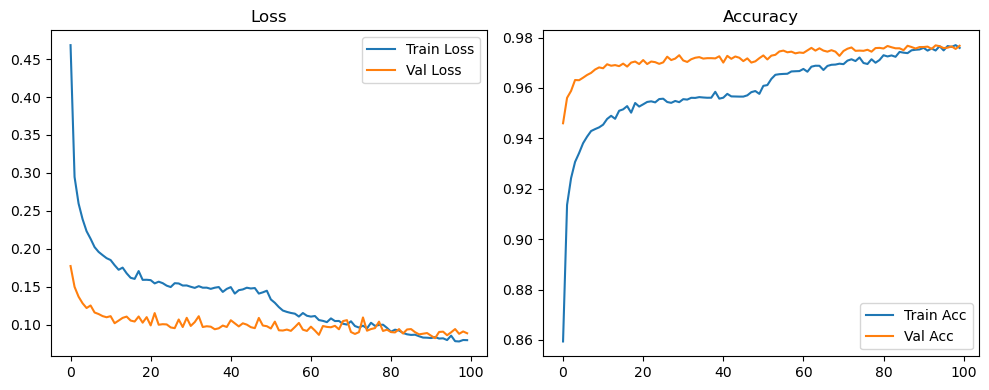

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2580, Acc: 0.9205 | Val Loss: 0.1513, Acc: 0.9550


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9592 | Val Loss: 0.1298, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9683 | Val Loss: 0.1071, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.1137, Acc: 0.9662


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9764 | Val Loss: 0.1044, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9805 | Val Loss: 0.1069, Acc: 0.9674


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 0.1053, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.1043, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.1074, Acc: 0.9725


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0946, Acc: 0.9739


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.0957, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.1129, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1014, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9730


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1176, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.1158, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1196, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1126, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.1064, Acc: 0.9739


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.1058, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1010, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1217, Acc: 0.9719


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1210, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1268, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1180, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1200, Acc: 0.9733


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1106, Acc: 0.9726


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1113, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1161, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1241, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1114, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1213, Acc: 0.9723


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1150, Acc: 0.9721


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1214, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1175, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1290, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1176, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0946, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1187, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1294, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1062, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1505, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1117, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1267, Acc: 0.9737


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1440, Acc: 0.9743


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1462, Acc: 0.9748


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1461, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1476, Acc: 0.9738


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.1302, Acc: 0.9750


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1310, Acc: 0.9766


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1551, Acc: 0.9764


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1330, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1341, Acc: 0.9762


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1370, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1349, Acc: 0.9779


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1374, Acc: 0.9767


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1301, Acc: 0.9777


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1322, Acc: 0.9773


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1702, Acc: 0.9768


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1696, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1267, Acc: 0.9764


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1571, Acc: 0.9769


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1349, Acc: 0.9765


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1370, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1396, Acc: 0.9763


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1433, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1285, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1545, Acc: 0.9767


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1373, Acc: 0.9759


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1586, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1487, Acc: 0.9766


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1497, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1392, Acc: 0.9769


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1736, Acc: 0.9765


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1372, Acc: 0.9775


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1297, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1385, Acc: 0.9769


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9758


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1478, Acc: 0.9768


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1448, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1451, Acc: 0.9777


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1633, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1627, Acc: 0.9778


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1626, Acc: 0.9781


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1483, Acc: 0.9778


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1534, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1609, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1689, Acc: 0.9795


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1608, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1711, Acc: 0.9794


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1618, Acc: 0.9777


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1668, Acc: 0.9786


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1508, Acc: 0.9786


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9788


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1821, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1850, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1773, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1863, Acc: 0.9792


Final Test Loss: 0.1526 Accuracy: 0.9827


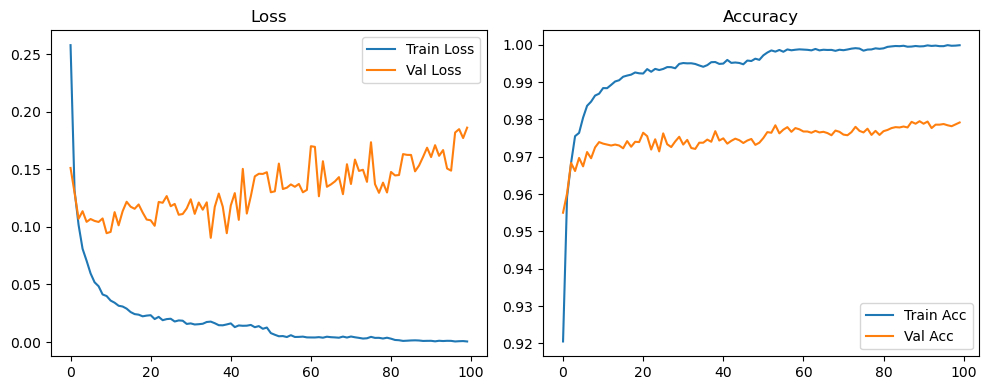

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3083, Acc: 0.9059 | Val Loss: 0.1455, Acc: 0.9542


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9465 | Val Loss: 0.1205, Acc: 0.9628


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9573 | Val Loss: 0.1177, Acc: 0.9645


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9629 | Val Loss: 0.0990, Acc: 0.9690


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9654 | Val Loss: 0.1040, Acc: 0.9689


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9690 | Val Loss: 0.1059, Acc: 0.9706


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9708 | Val Loss: 0.1019, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9731 | Val Loss: 0.0924, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9739 | Val Loss: 0.0924, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9749 | Val Loss: 0.0886, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9768 | Val Loss: 0.0946, Acc: 0.9751


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9788 | Val Loss: 0.0854, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9792 | Val Loss: 0.0940, Acc: 0.9739


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9798 | Val Loss: 0.0899, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9802 | Val Loss: 0.0907, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.0861, Acc: 0.9749


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0875, Acc: 0.9737


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0972, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9822 | Val Loss: 0.0898, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.0911, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.0966, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9852 | Val Loss: 0.0843, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0769, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9851 | Val Loss: 0.0901, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.0849, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0891, Acc: 0.9753


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0942, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0916, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.0849, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0843, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.0789, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0970, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.0974, Acc: 0.9770


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0969, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0876, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.0941, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.0970, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.0898, Acc: 0.9762


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.1089, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0894, Acc: 0.9771


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1035, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1120, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0835, Acc: 0.9757


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1037, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9859 | Val Loss: 0.0908, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.0788, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.1066, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.1061, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.0935, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0920, Acc: 0.9783


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0834, Acc: 0.9786


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0923, Acc: 0.9772


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.1025, Acc: 0.9770


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0921, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0824, Acc: 0.9786


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0832, Acc: 0.9796


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0995, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0921, Acc: 0.9806


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0880, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0921, Acc: 0.9780


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0884, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1021, Acc: 0.9780


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0827, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0988, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.0864, Acc: 0.9780


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0975, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.0894, Acc: 0.9804


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0951, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0970, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.1009, Acc: 0.9791


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1071, Acc: 0.9789


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0910, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1077, Acc: 0.9794


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1188, Acc: 0.9781


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9948 | Val Loss: 0.1036, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1076, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1066, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 0.0918, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.0978, Acc: 0.9795


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1032, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0996, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1048, Acc: 0.9801


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0990, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1022, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1001, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0991, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0917, Acc: 0.9809


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1038, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1126, Acc: 0.9809


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1080, Acc: 0.9811


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0947, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0894, Acc: 0.9815


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1173, Acc: 0.9806


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0878, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0948, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0946, Acc: 0.9799


Final Test Loss: 0.0855 Accuracy: 0.9812


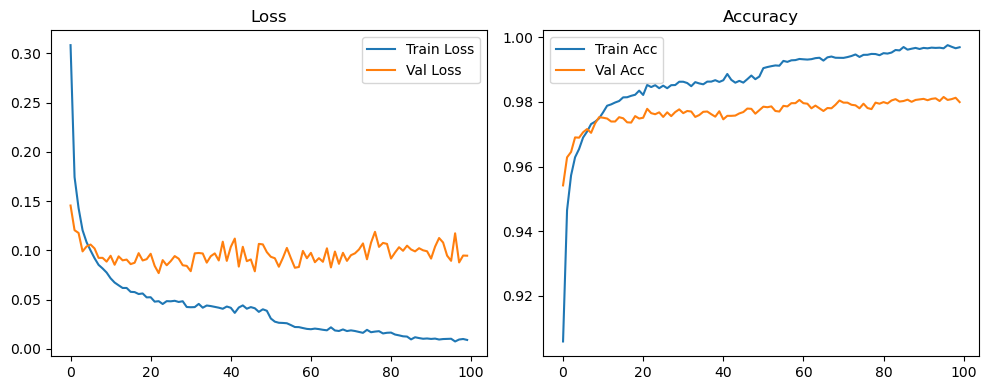

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4684, Acc: 0.8594 | Val Loss: 0.1772, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2946, Acc: 0.9136 | Val Loss: 0.1498, Acc: 0.9561


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2597, Acc: 0.9242 | Val Loss: 0.1368, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2390, Acc: 0.9307 | Val Loss: 0.1281, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2231, Acc: 0.9342 | Val Loss: 0.1219, Acc: 0.9631


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2132, Acc: 0.9381 | Val Loss: 0.1252, Acc: 0.9641


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2021, Acc: 0.9407 | Val Loss: 0.1160, Acc: 0.9652


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1958, Acc: 0.9429 | Val Loss: 0.1140, Acc: 0.9660


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9437 | Val Loss: 0.1112, Acc: 0.9673


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1876, Acc: 0.9444 | Val Loss: 0.1097, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1851, Acc: 0.9454 | Val Loss: 0.1111, Acc: 0.9678


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1783, Acc: 0.9477 | Val Loss: 0.1018, Acc: 0.9694


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9490 | Val Loss: 0.1053, Acc: 0.9688


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9478 | Val Loss: 0.1089, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1676, Acc: 0.9510 | Val Loss: 0.1106, Acc: 0.9687


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1617, Acc: 0.9515 | Val Loss: 0.1053, Acc: 0.9697


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9528 | Val Loss: 0.1041, Acc: 0.9685


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1706, Acc: 0.9502 | Val Loss: 0.1107, Acc: 0.9701


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9540 | Val Loss: 0.1026, Acc: 0.9705


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1591, Acc: 0.9526 | Val Loss: 0.1098, Acc: 0.9695


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9535 | Val Loss: 0.0990, Acc: 0.9711


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9545 | Val Loss: 0.1152, Acc: 0.9695


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9547 | Val Loss: 0.0998, Acc: 0.9705


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9543 | Val Loss: 0.1005, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1513, Acc: 0.9556 | Val Loss: 0.1002, Acc: 0.9696


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9557 | Val Loss: 0.0963, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9544 | Val Loss: 0.0953, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9541 | Val Loss: 0.1067, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9549 | Val Loss: 0.0968, Acc: 0.9717


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9544 | Val Loss: 0.1089, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1499, Acc: 0.9556 | Val Loss: 0.0982, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1484, Acc: 0.9554 | Val Loss: 0.1033, Acc: 0.9703


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9561 | Val Loss: 0.1111, Acc: 0.9714


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9561 | Val Loss: 0.0969, Acc: 0.9720


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9564 | Val Loss: 0.0978, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9562 | Val Loss: 0.0973, Acc: 0.9717


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9561 | Val Loss: 0.0939, Acc: 0.9718


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9561 | Val Loss: 0.0951, Acc: 0.9718


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9585 | Val Loss: 0.0987, Acc: 0.9718


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9558 | Val Loss: 0.0969, Acc: 0.9726


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.1058, Acc: 0.9701


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9577 | Val Loss: 0.1017, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1454, Acc: 0.9567 | Val Loss: 0.0976, Acc: 0.9716


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1464, Acc: 0.9566 | Val Loss: 0.1017, Acc: 0.9725


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9566 | Val Loss: 0.1000, Acc: 0.9720


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9566 | Val Loss: 0.0966, Acc: 0.9707


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1482, Acc: 0.9571 | Val Loss: 0.0953, Acc: 0.9718


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9584 | Val Loss: 0.1088, Acc: 0.9701


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9588 | Val Loss: 0.0988, Acc: 0.9706


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1447, Acc: 0.9577 | Val Loss: 0.0979, Acc: 0.9718


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.1332, Acc: 0.9609 | Val Loss: 0.0949, Acc: 0.9729


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.1287, Acc: 0.9611 | Val Loss: 0.1039, Acc: 0.9713


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.1231, Acc: 0.9636 | Val Loss: 0.0925, Acc: 0.9728


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.1185, Acc: 0.9652 | Val Loss: 0.0922, Acc: 0.9732


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.1167, Acc: 0.9655 | Val Loss: 0.0934, Acc: 0.9745


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.1154, Acc: 0.9656 | Val Loss: 0.0918, Acc: 0.9748


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9656 | Val Loss: 0.0968, Acc: 0.9742


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.1106, Acc: 0.9666 | Val Loss: 0.1022, Acc: 0.9744


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.1153, Acc: 0.9666 | Val Loss: 0.0933, Acc: 0.9738


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.1117, Acc: 0.9667 | Val Loss: 0.0917, Acc: 0.9741


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.1106, Acc: 0.9676 | Val Loss: 0.0973, Acc: 0.9739


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.1113, Acc: 0.9665 | Val Loss: 0.0922, Acc: 0.9749


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.1060, Acc: 0.9685 | Val Loss: 0.0865, Acc: 0.9759


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.1049, Acc: 0.9688 | Val Loss: 0.0981, Acc: 0.9748


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.1033, Acc: 0.9688 | Val Loss: 0.0970, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.1082, Acc: 0.9671 | Val Loss: 0.0965, Acc: 0.9748


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.1047, Acc: 0.9688 | Val Loss: 0.0984, Acc: 0.9744


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.1048, Acc: 0.9692 | Val Loss: 0.0938, Acc: 0.9750


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.1011, Acc: 0.9693 | Val Loss: 0.1046, Acc: 0.9744


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9696 | Val Loss: 0.1059, Acc: 0.9728


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.1044, Acc: 0.9695 | Val Loss: 0.0902, Acc: 0.9747


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0981, Acc: 0.9709 | Val Loss: 0.0877, Acc: 0.9756


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0961, Acc: 0.9714 | Val Loss: 0.0901, Acc: 0.9761


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0986, Acc: 0.9707 | Val Loss: 0.1094, Acc: 0.9748


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0949, Acc: 0.9721 | Val Loss: 0.0920, Acc: 0.9748


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.1024, Acc: 0.9699 | Val Loss: 0.0941, Acc: 0.9748


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0983, Acc: 0.9695 | Val Loss: 0.0954, Acc: 0.9752


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0995, Acc: 0.9714 | Val Loss: 0.1039, Acc: 0.9744


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0999, Acc: 0.9700 | Val Loss: 0.0916, Acc: 0.9758


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0956, Acc: 0.9711 | Val Loss: 0.0933, Acc: 0.9759


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0909, Acc: 0.9720 | Val Loss: 0.0906, Acc: 0.9752


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0940, Acc: 0.9718 | Val Loss: 0.0895, Acc: 0.9761


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0932, Acc: 0.9724 | Val Loss: 0.0952, Acc: 0.9763


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9730 | Val Loss: 0.0865, Acc: 0.9761


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0873, Acc: 0.9733 | Val Loss: 0.0922, Acc: 0.9755


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0868, Acc: 0.9738 | Val Loss: 0.0944, Acc: 0.9746


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0874, Acc: 0.9735 | Val Loss: 0.0895, Acc: 0.9762


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0853, Acc: 0.9744 | Val Loss: 0.0866, Acc: 0.9756


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0829, Acc: 0.9742 | Val Loss: 0.0892, Acc: 0.9766


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9758 | Val Loss: 0.0867, Acc: 0.9766


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0841, Acc: 0.9741 | Val Loss: 0.0874, Acc: 0.9765


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0821, Acc: 0.9751 | Val Loss: 0.0854, Acc: 0.9762


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0817, Acc: 0.9756 | Val Loss: 0.0896, Acc: 0.9764


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0836, Acc: 0.9748 | Val Loss: 0.0905, Acc: 0.9767


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0798, Acc: 0.9762 | Val Loss: 0.0857, Acc: 0.9770


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0832, Acc: 0.9750 | Val Loss: 0.0885, Acc: 0.9758


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0789, Acc: 0.9758 | Val Loss: 0.0953, Acc: 0.9762


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0778, Acc: 0.9766 | Val Loss: 0.0869, Acc: 0.9767


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0793, Acc: 0.9763 | Val Loss: 0.0892, Acc: 0.9766


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0777, Acc: 0.9763 | Val Loss: 0.0873, Acc: 0.9768


Final Test Loss: 0.0752 Accuracy: 0.9789


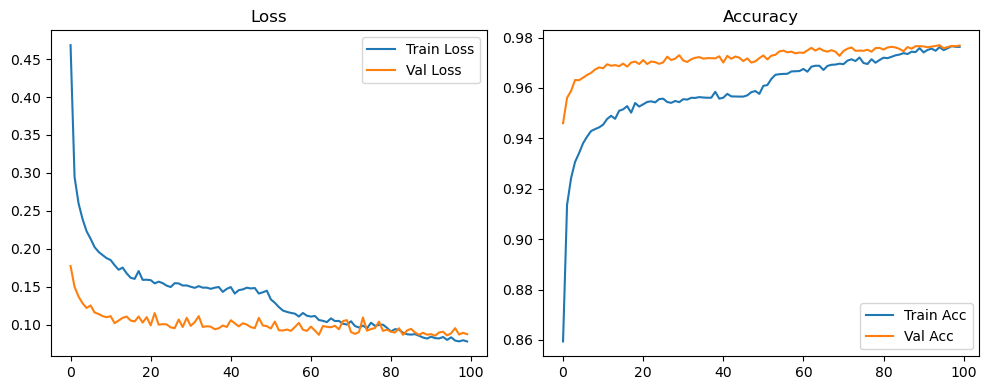

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2580, Acc: 0.9205 | Val Loss: 0.1513, Acc: 0.9550


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9592 | Val Loss: 0.1298, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1019, Acc: 0.9683 | Val Loss: 0.1071, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.1137, Acc: 0.9662


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9764 | Val Loss: 0.1044, Acc: 0.9697


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9805 | Val Loss: 0.1069, Acc: 0.9674


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9836 | Val Loss: 0.1053, Acc: 0.9712


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9848 | Val Loss: 0.1043, Acc: 0.9696


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.1074, Acc: 0.9725


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0946, Acc: 0.9739


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9884 | Val Loss: 0.0957, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9884 | Val Loss: 0.1129, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1014, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1219, Acc: 0.9730


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1176, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.1158, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1196, Acc: 0.9727


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1126, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.1064, Acc: 0.9739


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.1058, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1010, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.1217, Acc: 0.9719


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1210, Acc: 0.9747


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1268, Acc: 0.9714


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1180, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.1200, Acc: 0.9733


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1106, Acc: 0.9726


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1113, Acc: 0.9741


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1161, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9951 | Val Loss: 0.1241, Acc: 0.9732


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1114, Acc: 0.9745


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1213, Acc: 0.9723


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1150, Acc: 0.9721


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1214, Acc: 0.9738


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9738


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1175, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.1290, Acc: 0.9740


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1176, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0946, Acc: 0.9743


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.1187, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1294, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1062, Acc: 0.9742


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1505, Acc: 0.9748


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1117, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.1267, Acc: 0.9737


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1440, Acc: 0.9743


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1462, Acc: 0.9748


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1461, Acc: 0.9732


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1476, Acc: 0.9738


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1188, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1284, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1373, Acc: 0.9774


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1552, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1348, Acc: 0.9782


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1336, Acc: 0.9780


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1587, Acc: 0.9787


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1687, Acc: 0.9780


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1380, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1570, Acc: 0.9778


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1375, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1491, Acc: 0.9780


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1626, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1493, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1468, Acc: 0.9770


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1357, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1350, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1118, Acc: 0.9787


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1384, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1547, Acc: 0.9778


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1388, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1612, Acc: 0.9780


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1465, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1443, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1635, Acc: 0.9789


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1375, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1494, Acc: 0.9789


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1820, Acc: 0.9785


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1494, Acc: 0.9788


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1824, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1572, Acc: 0.9778


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1525, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1407, Acc: 0.9784


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1538, Acc: 0.9793


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1535, Acc: 0.9793


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1537, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1460, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1763, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1666, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1458, Acc: 0.9784


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1443, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1513, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1694, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1650, Acc: 0.9795


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1699, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1710, Acc: 0.9794


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1512, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1554, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1635, Acc: 0.9803


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1592, Acc: 0.9808


Final Test Loss: 0.1435 Accuracy: 0.9816


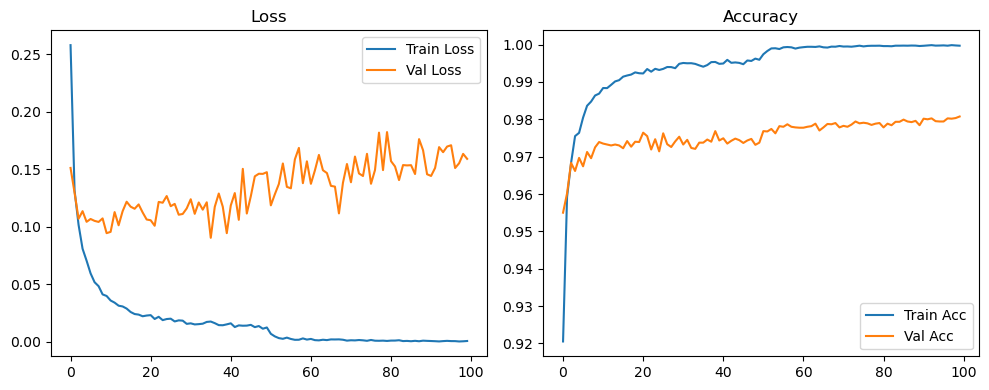

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3083, Acc: 0.9059 | Val Loss: 0.1455, Acc: 0.9542


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1744, Acc: 0.9465 | Val Loss: 0.1205, Acc: 0.9628


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1430, Acc: 0.9573 | Val Loss: 0.1177, Acc: 0.9645


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1205, Acc: 0.9629 | Val Loss: 0.0990, Acc: 0.9690


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1083, Acc: 0.9654 | Val Loss: 0.1040, Acc: 0.9689


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0999, Acc: 0.9690 | Val Loss: 0.1059, Acc: 0.9706


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0920, Acc: 0.9708 | Val Loss: 0.1019, Acc: 0.9716


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0853, Acc: 0.9731 | Val Loss: 0.0924, Acc: 0.9704


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0817, Acc: 0.9739 | Val Loss: 0.0924, Acc: 0.9733


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9749 | Val Loss: 0.0886, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9768 | Val Loss: 0.0946, Acc: 0.9751


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0674, Acc: 0.9788 | Val Loss: 0.0854, Acc: 0.9748


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9792 | Val Loss: 0.0940, Acc: 0.9739


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9798 | Val Loss: 0.0899, Acc: 0.9739


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0619, Acc: 0.9802 | Val Loss: 0.0907, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9814 | Val Loss: 0.0861, Acc: 0.9749


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0875, Acc: 0.9737


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0972, Acc: 0.9736


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9822 | Val Loss: 0.0898, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9835 | Val Loss: 0.0911, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.0966, Acc: 0.9751


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9852 | Val Loss: 0.0843, Acc: 0.9778


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0769, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9851 | Val Loss: 0.0901, Acc: 0.9762


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9842 | Val Loss: 0.0849, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0483, Acc: 0.9850 | Val Loss: 0.0891, Acc: 0.9753


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9842 | Val Loss: 0.0942, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9851 | Val Loss: 0.0916, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9852 | Val Loss: 0.0849, Acc: 0.9768


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9862 | Val Loss: 0.0843, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.0789, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9858 | Val Loss: 0.0970, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.0974, Acc: 0.9770


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0969, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9857 | Val Loss: 0.0876, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.0941, Acc: 0.9769


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9862 | Val Loss: 0.0970, Acc: 0.9770


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9862 | Val Loss: 0.0898, Acc: 0.9762


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.1089, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0894, Acc: 0.9771


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1035, Acc: 0.9746


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9886 | Val Loss: 0.1120, Acc: 0.9757


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9868 | Val Loss: 0.0835, Acc: 0.9757


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.1037, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9865 | Val Loss: 0.0891, Acc: 0.9764


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9859 | Val Loss: 0.0908, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.0788, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.1066, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.1061, Acc: 0.9763


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9774


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0906, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0850, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0828, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9931 | Val Loss: 0.0828, Acc: 0.9797


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0903, Acc: 0.9794


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0993, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0878, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0897, Acc: 0.9810


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0869, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.0934, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0960, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0968, Acc: 0.9805


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0987, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9808


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0906, Acc: 0.9793


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0944, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0855, Acc: 0.9801


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0849, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0896, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0960, Acc: 0.9793


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.0861, Acc: 0.9795


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1006, Acc: 0.9795


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0926, Acc: 0.9796


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0981, Acc: 0.9812


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0976, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0886, Acc: 0.9809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1034, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0940, Acc: 0.9804


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1034, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.0799, Acc: 0.9806


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0903, Acc: 0.9797


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0992, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1012, Acc: 0.9798


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1011, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1023, Acc: 0.9809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0947, Acc: 0.9803


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1028, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0988, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0894, Acc: 0.9816


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0974, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0898, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0995, Acc: 0.9825


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0999, Acc: 0.9817


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1065, Acc: 0.9814


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0914, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0935, Acc: 0.9811


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0953, Acc: 0.9809


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0826, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0983, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0968, Acc: 0.9811


Final Test Loss: 0.0962 Accuracy: 0.9825


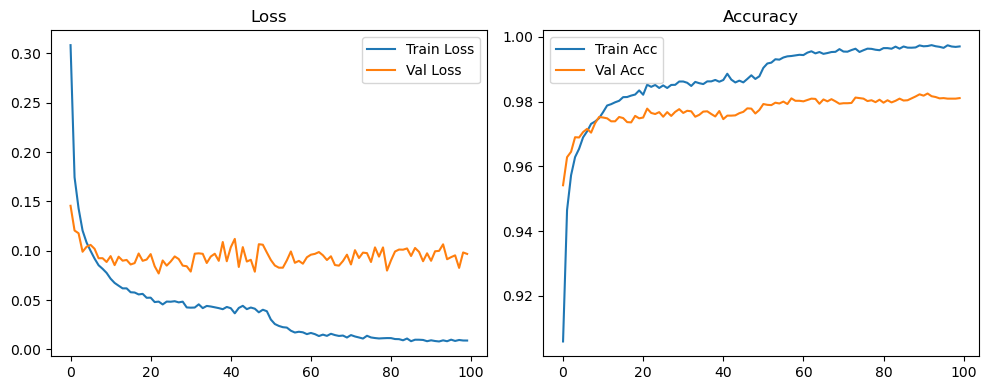

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4684, Acc: 0.8594 | Val Loss: 0.1772, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2946, Acc: 0.9136 | Val Loss: 0.1498, Acc: 0.9561


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2597, Acc: 0.9242 | Val Loss: 0.1368, Acc: 0.9588


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2390, Acc: 0.9307 | Val Loss: 0.1281, Acc: 0.9632


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2231, Acc: 0.9342 | Val Loss: 0.1219, Acc: 0.9631


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.2132, Acc: 0.9381 | Val Loss: 0.1252, Acc: 0.9641


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.2021, Acc: 0.9407 | Val Loss: 0.1160, Acc: 0.9652


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1958, Acc: 0.9429 | Val Loss: 0.1140, Acc: 0.9660


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1916, Acc: 0.9437 | Val Loss: 0.1112, Acc: 0.9673


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1876, Acc: 0.9444 | Val Loss: 0.1097, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1851, Acc: 0.9454 | Val Loss: 0.1111, Acc: 0.9678


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1783, Acc: 0.9477 | Val Loss: 0.1018, Acc: 0.9694


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1723, Acc: 0.9490 | Val Loss: 0.1053, Acc: 0.9688


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1751, Acc: 0.9478 | Val Loss: 0.1089, Acc: 0.9691


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1676, Acc: 0.9510 | Val Loss: 0.1106, Acc: 0.9687


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1617, Acc: 0.9515 | Val Loss: 0.1053, Acc: 0.9697


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1603, Acc: 0.9528 | Val Loss: 0.1041, Acc: 0.9685


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1706, Acc: 0.9502 | Val Loss: 0.1107, Acc: 0.9701


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1590, Acc: 0.9540 | Val Loss: 0.1026, Acc: 0.9705


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1591, Acc: 0.9526 | Val Loss: 0.1098, Acc: 0.9695


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1586, Acc: 0.9535 | Val Loss: 0.0990, Acc: 0.9711


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1543, Acc: 0.9545 | Val Loss: 0.1152, Acc: 0.9695


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1566, Acc: 0.9547 | Val Loss: 0.0998, Acc: 0.9705


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9543 | Val Loss: 0.1005, Acc: 0.9702


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1513, Acc: 0.9556 | Val Loss: 0.1002, Acc: 0.9696


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9557 | Val Loss: 0.0963, Acc: 0.9702


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1546, Acc: 0.9544 | Val Loss: 0.0953, Acc: 0.9724


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1542, Acc: 0.9541 | Val Loss: 0.1067, Acc: 0.9711


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1515, Acc: 0.9549 | Val Loss: 0.0968, Acc: 0.9717


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.1516, Acc: 0.9544 | Val Loss: 0.1089, Acc: 0.9730


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1499, Acc: 0.9556 | Val Loss: 0.0982, Acc: 0.9709


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.1484, Acc: 0.9554 | Val Loss: 0.1033, Acc: 0.9703


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.1507, Acc: 0.9561 | Val Loss: 0.1111, Acc: 0.9714


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9561 | Val Loss: 0.0969, Acc: 0.9720


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.1487, Acc: 0.9564 | Val Loss: 0.0978, Acc: 0.9722


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9562 | Val Loss: 0.0973, Acc: 0.9717


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9561 | Val Loss: 0.0939, Acc: 0.9718


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1495, Acc: 0.9561 | Val Loss: 0.0951, Acc: 0.9718


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9585 | Val Loss: 0.0987, Acc: 0.9718


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9558 | Val Loss: 0.0969, Acc: 0.9726


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.1494, Acc: 0.9561 | Val Loss: 0.1058, Acc: 0.9701


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9577 | Val Loss: 0.1017, Acc: 0.9728


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.1454, Acc: 0.9567 | Val Loss: 0.0976, Acc: 0.9716


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.1464, Acc: 0.9566 | Val Loss: 0.1017, Acc: 0.9725


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.1486, Acc: 0.9566 | Val Loss: 0.1000, Acc: 0.9720


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.1476, Acc: 0.9566 | Val Loss: 0.0966, Acc: 0.9707


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.1482, Acc: 0.9571 | Val Loss: 0.0953, Acc: 0.9718


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9584 | Val Loss: 0.1088, Acc: 0.9701


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.1425, Acc: 0.9588 | Val Loss: 0.0988, Acc: 0.9706


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.1447, Acc: 0.9577 | Val Loss: 0.0979, Acc: 0.9718


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.1319, Acc: 0.9607 | Val Loss: 0.0932, Acc: 0.9722


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.1263, Acc: 0.9617 | Val Loss: 0.0968, Acc: 0.9722


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.1197, Acc: 0.9641 | Val Loss: 0.0932, Acc: 0.9720


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.1190, Acc: 0.9651 | Val Loss: 0.0913, Acc: 0.9734


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.1178, Acc: 0.9651 | Val Loss: 0.0938, Acc: 0.9738


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.1143, Acc: 0.9660 | Val Loss: 0.0896, Acc: 0.9749


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.1108, Acc: 0.9664 | Val Loss: 0.0876, Acc: 0.9750


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.1087, Acc: 0.9673 | Val Loss: 0.0939, Acc: 0.9744


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.1080, Acc: 0.9675 | Val Loss: 0.0924, Acc: 0.9744


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.1067, Acc: 0.9676 | Val Loss: 0.0873, Acc: 0.9748


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.1050, Acc: 0.9692 | Val Loss: 0.0919, Acc: 0.9738


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.1007, Acc: 0.9699 | Val Loss: 0.0899, Acc: 0.9754


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0981, Acc: 0.9710 | Val Loss: 0.0936, Acc: 0.9752


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0986, Acc: 0.9706 | Val Loss: 0.0933, Acc: 0.9753


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9725 | Val Loss: 0.0934, Acc: 0.9750


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.1008, Acc: 0.9705 | Val Loss: 0.0886, Acc: 0.9756


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0951, Acc: 0.9719 | Val Loss: 0.0910, Acc: 0.9759


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0966, Acc: 0.9717 | Val Loss: 0.0854, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0926, Acc: 0.9723 | Val Loss: 0.0899, Acc: 0.9760


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0908, Acc: 0.9723 | Val Loss: 0.0944, Acc: 0.9759


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0935, Acc: 0.9719 | Val Loss: 0.0873, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0888, Acc: 0.9735 | Val Loss: 0.0942, Acc: 0.9768


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0887, Acc: 0.9736 | Val Loss: 0.0858, Acc: 0.9774


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9724 | Val Loss: 0.0935, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0873, Acc: 0.9740 | Val Loss: 0.0875, Acc: 0.9759


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0926, Acc: 0.9721 | Val Loss: 0.0857, Acc: 0.9757


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0921, Acc: 0.9727 | Val Loss: 0.0872, Acc: 0.9758


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0882, Acc: 0.9738 | Val Loss: 0.0943, Acc: 0.9747


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0894, Acc: 0.9740 | Val Loss: 0.0870, Acc: 0.9765


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0865, Acc: 0.9746 | Val Loss: 0.0872, Acc: 0.9761


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0834, Acc: 0.9746 | Val Loss: 0.0903, Acc: 0.9760


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9733 | Val Loss: 0.0903, Acc: 0.9761


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0882, Acc: 0.9738 | Val Loss: 0.0948, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0854, Acc: 0.9743 | Val Loss: 0.0868, Acc: 0.9772


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0857, Acc: 0.9749 | Val Loss: 0.0909, Acc: 0.9757


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0803, Acc: 0.9761 | Val Loss: 0.0932, Acc: 0.9754


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0847, Acc: 0.9746 | Val Loss: 0.0863, Acc: 0.9765


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9758 | Val Loss: 0.0858, Acc: 0.9768


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9754 | Val Loss: 0.0880, Acc: 0.9763


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0798, Acc: 0.9764 | Val Loss: 0.0846, Acc: 0.9762


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0815, Acc: 0.9756 | Val Loss: 0.0892, Acc: 0.9759


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0819, Acc: 0.9756 | Val Loss: 0.0868, Acc: 0.9751


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0792, Acc: 0.9766 | Val Loss: 0.0891, Acc: 0.9765


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0791, Acc: 0.9761 | Val Loss: 0.0905, Acc: 0.9774


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9776 | Val Loss: 0.0867, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9754 | Val Loss: 0.0899, Acc: 0.9770


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0789, Acc: 0.9763 | Val Loss: 0.0891, Acc: 0.9765


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0758, Acc: 0.9771 | Val Loss: 0.0837, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0798, Acc: 0.9765 | Val Loss: 0.0866, Acc: 0.9760


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9770 | Val Loss: 0.0893, Acc: 0.9766


Final Test Loss: 0.0771 Accuracy: 0.9796


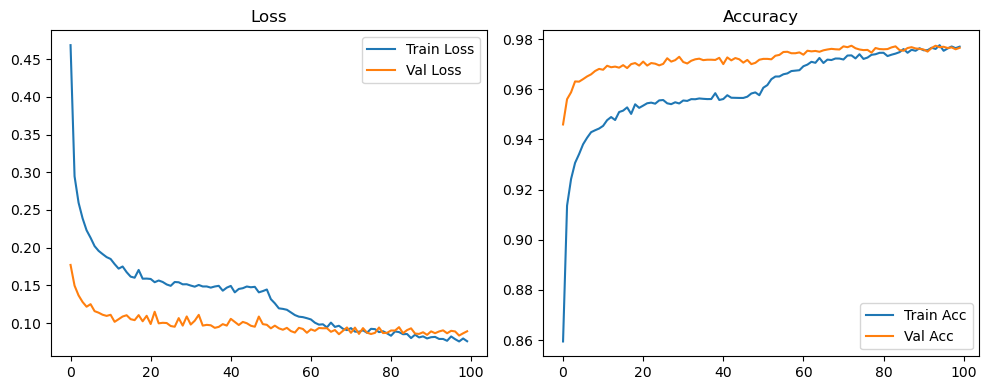

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2383, Acc: 0.9262 | Val Loss: 0.1501, Acc: 0.9537


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1243, Acc: 0.9617 | Val Loss: 0.1168, Acc: 0.9645


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0931, Acc: 0.9711 | Val Loss: 0.1046, Acc: 0.9688


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9764 | Val Loss: 0.1015, Acc: 0.9694


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.0944, Acc: 0.9723


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.1023, Acc: 0.9714


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0963, Acc: 0.9731


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.1046, Acc: 0.9707


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.0967, Acc: 0.9747


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.1016, Acc: 0.9731


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0979, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1007, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1004, Acc: 0.9767


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.1062, Acc: 0.9751


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0972, Acc: 0.9751


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0996, Acc: 0.9758


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1059, Acc: 0.9744


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.1135, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1027, Acc: 0.9771


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1018, Acc: 0.9753


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.1112, Acc: 0.9742


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1286, Acc: 0.9738


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1112, Acc: 0.9751


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.1073, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9765


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1029, Acc: 0.9747


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1148, Acc: 0.9770


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1011, Acc: 0.9770


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1169, Acc: 0.9765


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1164, Acc: 0.9769


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1337, Acc: 0.9733


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1097, Acc: 0.9742


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1252, Acc: 0.9743


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1181, Acc: 0.9761


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1220, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1012, Acc: 0.9772


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1360, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1230, Acc: 0.9751


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1281, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1028, Acc: 0.9769


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1041, Acc: 0.9771


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1274, Acc: 0.9781


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1249, Acc: 0.9764


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1225, Acc: 0.9758


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1399, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1327, Acc: 0.9754


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0977, Acc: 0.9766


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1351, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1066, Acc: 0.9759


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1121, Acc: 0.9773


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1290, Acc: 0.9764


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1330, Acc: 0.9759


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1340, Acc: 0.9772


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1242, Acc: 0.9761


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1161, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1578, Acc: 0.9750


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1265, Acc: 0.9767


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1363, Acc: 0.9752


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1438, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1139, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1263, Acc: 0.9746


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1213, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1218, Acc: 0.9771


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9748


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1471, Acc: 0.9750


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1265, Acc: 0.9763


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1507, Acc: 0.9762


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1294, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1160, Acc: 0.9761


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1312, Acc: 0.9763


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1390, Acc: 0.9771


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1106, Acc: 0.9763


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1347, Acc: 0.9775


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1180, Acc: 0.9763


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1534, Acc: 0.9755


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1297, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1343, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1137, Acc: 0.9778


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1488, Acc: 0.9781


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1187, Acc: 0.9757


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1238, Acc: 0.9766


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1300, Acc: 0.9774


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1324, Acc: 0.9769


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1351, Acc: 0.9769


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1497, Acc: 0.9772


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1031, Acc: 0.9763


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1110, Acc: 0.9763


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1234, Acc: 0.9778


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1263, Acc: 0.9770


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1342, Acc: 0.9759


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1018, Acc: 0.9778


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1604, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1581, Acc: 0.9752


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1323, Acc: 0.9761


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1272, Acc: 0.9756


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1642, Acc: 0.9772


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1289, Acc: 0.9780


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1452, Acc: 0.9766


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1179, Acc: 0.9777


Final Test Loss: 0.1101 Accuracy: 0.9799


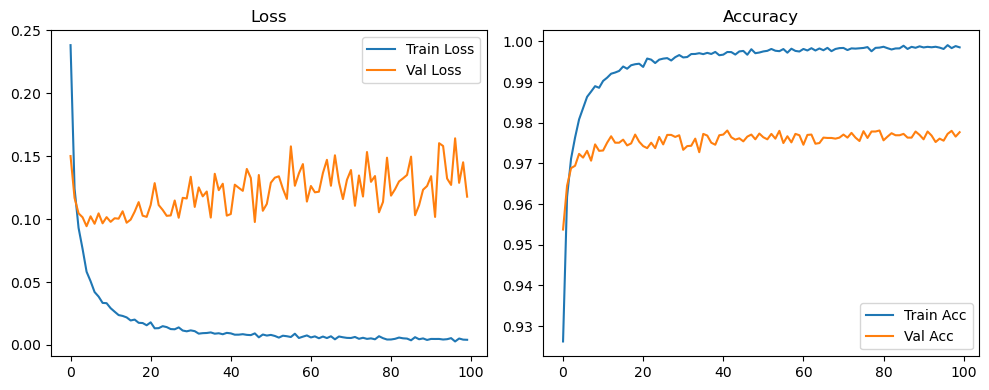

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2904, Acc: 0.9109 | Val Loss: 0.1367, Acc: 0.9572


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1667, Acc: 0.9492 | Val Loss: 0.1221, Acc: 0.9626


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1353, Acc: 0.9583 | Val Loss: 0.1123, Acc: 0.9650


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1132, Acc: 0.9657 | Val Loss: 0.1003, Acc: 0.9697


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9703 | Val Loss: 0.0920, Acc: 0.9714


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9724 | Val Loss: 0.0973, Acc: 0.9695


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9743 | Val Loss: 0.0884, Acc: 0.9747


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9775 | Val Loss: 0.0964, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9784 | Val Loss: 0.0988, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9788 | Val Loss: 0.0856, Acc: 0.9749


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9822 | Val Loss: 0.0962, Acc: 0.9746


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0863, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0859, Acc: 0.9772


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0873, Acc: 0.9763


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9851 | Val Loss: 0.0923, Acc: 0.9746


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9852 | Val Loss: 0.0940, Acc: 0.9769


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9853 | Val Loss: 0.0981, Acc: 0.9756


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 0.0910, Acc: 0.9762


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9870 | Val Loss: 0.0896, Acc: 0.9768


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.0936, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.0851, Acc: 0.9783


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0971, Acc: 0.9776


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.0853, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.1000, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.0811, Acc: 0.9782


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9893 | Val Loss: 0.0884, Acc: 0.9772


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9885 | Val Loss: 0.0862, Acc: 0.9771


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0915, Acc: 0.9769


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0841, Acc: 0.9764


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.0882, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.0879, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0842, Acc: 0.9766


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0858, Acc: 0.9799


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.0840, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.1019, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0857, Acc: 0.9778


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0877, Acc: 0.9785


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0929, Acc: 0.9769


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0905, Acc: 0.9777


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0849, Acc: 0.9772


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0810, Acc: 0.9780


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0945, Acc: 0.9776


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0842, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9912 | Val Loss: 0.0992, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0867, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.1088, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0903, Acc: 0.9786


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0910, Acc: 0.9786


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0898, Acc: 0.9800


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0927, Acc: 0.9790


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0932, Acc: 0.9786


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0900, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0884, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.0895, Acc: 0.9786


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.1052, Acc: 0.9782


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.0892, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0988, Acc: 0.9761


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.1155, Acc: 0.9763


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.1091, Acc: 0.9770


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.0916, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1001, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1096, Acc: 0.9780


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0967, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0905, Acc: 0.9793


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0975, Acc: 0.9780


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9935 | Val Loss: 0.0963, Acc: 0.9777


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1213, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0991, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0971, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0942, Acc: 0.9780


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0899, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0924, Acc: 0.9791


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0903, Acc: 0.9800


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0899, Acc: 0.9788


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0944, Acc: 0.9777


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0964, Acc: 0.9772


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0995, Acc: 0.9780


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.0932, Acc: 0.9783


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0879, Acc: 0.9795


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0983, Acc: 0.9783


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0969, Acc: 0.9788


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.1066, Acc: 0.9782


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1131, Acc: 0.9803


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0961, Acc: 0.9775


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0942, Acc: 0.9771


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.0832, Acc: 0.9794


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0920, Acc: 0.9779


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.0869, Acc: 0.9785


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9938 | Val Loss: 0.0953, Acc: 0.9782


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0963, Acc: 0.9788


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0857, Acc: 0.9779


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0976, Acc: 0.9792


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0939, Acc: 0.9786


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0933, Acc: 0.9804


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0989, Acc: 0.9784


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0864, Acc: 0.9790


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.1020, Acc: 0.9776


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0942, Acc: 0.9782


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0962, Acc: 0.9777


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.1146, Acc: 0.9773


Final Test Loss: 0.1037 Accuracy: 0.9808


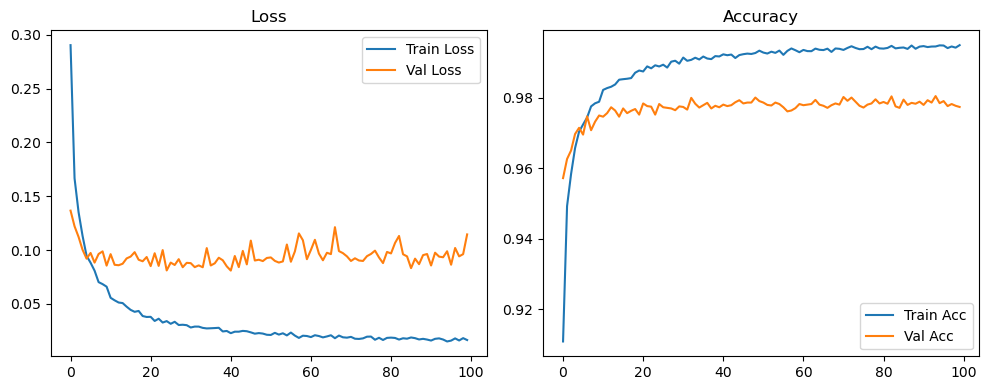

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4501, Acc: 0.8629 | Val Loss: 0.1799, Acc: 0.9431


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2832, Acc: 0.9169 | Val Loss: 0.1427, Acc: 0.9567


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2455, Acc: 0.9284 | Val Loss: 0.1285, Acc: 0.9607


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2159, Acc: 0.9364 | Val Loss: 0.1229, Acc: 0.9628


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2010, Acc: 0.9414 | Val Loss: 0.1158, Acc: 0.9663


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1879, Acc: 0.9445 | Val Loss: 0.1114, Acc: 0.9678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1806, Acc: 0.9468 | Val Loss: 0.1015, Acc: 0.9688


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1648, Acc: 0.9513 | Val Loss: 0.1018, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1672, Acc: 0.9490 | Val Loss: 0.1015, Acc: 0.9702


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1578, Acc: 0.9528 | Val Loss: 0.0999, Acc: 0.9717


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1523, Acc: 0.9547 | Val Loss: 0.1043, Acc: 0.9699


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1494, Acc: 0.9557 | Val Loss: 0.0970, Acc: 0.9722


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1429, Acc: 0.9572 | Val Loss: 0.0929, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1391, Acc: 0.9580 | Val Loss: 0.0973, Acc: 0.9730


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1392, Acc: 0.9586 | Val Loss: 0.0948, Acc: 0.9737


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1348, Acc: 0.9602 | Val Loss: 0.0954, Acc: 0.9737


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1278, Acc: 0.9606 | Val Loss: 0.0961, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1306, Acc: 0.9613 | Val Loss: 0.0864, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1245, Acc: 0.9633 | Val Loss: 0.0926, Acc: 0.9736


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1193, Acc: 0.9644 | Val Loss: 0.0931, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1230, Acc: 0.9627 | Val Loss: 0.0945, Acc: 0.9744


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1152, Acc: 0.9655 | Val Loss: 0.0932, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1173, Acc: 0.9641 | Val Loss: 0.0876, Acc: 0.9749


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1132, Acc: 0.9659 | Val Loss: 0.0906, Acc: 0.9751


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1145, Acc: 0.9654 | Val Loss: 0.0892, Acc: 0.9743


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1134, Acc: 0.9665 | Val Loss: 0.0883, Acc: 0.9764


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9651 | Val Loss: 0.0959, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1102, Acc: 0.9659 | Val Loss: 0.0898, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9668 | Val Loss: 0.0931, Acc: 0.9741


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1053, Acc: 0.9687 | Val Loss: 0.0925, Acc: 0.9760


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9690 | Val Loss: 0.0943, Acc: 0.9757


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9684 | Val Loss: 0.0939, Acc: 0.9742


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9688 | Val Loss: 0.0912, Acc: 0.9751


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.1011, Acc: 0.9689 | Val Loss: 0.0947, Acc: 0.9739


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.1028, Acc: 0.9686 | Val Loss: 0.0937, Acc: 0.9738


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9683 | Val Loss: 0.0997, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0989, Acc: 0.9699 | Val Loss: 0.0946, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9698 | Val Loss: 0.0918, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0977, Acc: 0.9703 | Val Loss: 0.0927, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9699 | Val Loss: 0.0931, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9700 | Val Loss: 0.0977, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0959, Acc: 0.9714 | Val Loss: 0.0923, Acc: 0.9754


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0963, Acc: 0.9713 | Val Loss: 0.0936, Acc: 0.9742


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9710 | Val Loss: 0.0934, Acc: 0.9750


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9709 | Val Loss: 0.0884, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9709 | Val Loss: 0.0918, Acc: 0.9752


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9718 | Val Loss: 0.0967, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9724 | Val Loss: 0.0944, Acc: 0.9762


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9720 | Val Loss: 0.0895, Acc: 0.9760


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0926, Acc: 0.9720 | Val Loss: 0.0887, Acc: 0.9762


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0903, Acc: 0.9722 | Val Loss: 0.0813, Acc: 0.9762


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9708 | Val Loss: 0.0920, Acc: 0.9756


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0900, Acc: 0.9719 | Val Loss: 0.0900, Acc: 0.9757


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0935, Acc: 0.9712 | Val Loss: 0.0867, Acc: 0.9742


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9737 | Val Loss: 0.0935, Acc: 0.9758


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0923, Acc: 0.9717 | Val Loss: 0.0875, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9723 | Val Loss: 0.0894, Acc: 0.9762


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9735 | Val Loss: 0.0918, Acc: 0.9747


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0887, Acc: 0.9725 | Val Loss: 0.0921, Acc: 0.9753


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0893, Acc: 0.9715 | Val Loss: 0.0869, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9740 | Val Loss: 0.0948, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9732 | Val Loss: 0.0943, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9742 | Val Loss: 0.0856, Acc: 0.9775


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0872, Acc: 0.9731 | Val Loss: 0.0860, Acc: 0.9775


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0873, Acc: 0.9740 | Val Loss: 0.0883, Acc: 0.9772


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9733 | Val Loss: 0.0934, Acc: 0.9770


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9732 | Val Loss: 0.0920, Acc: 0.9751


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9731 | Val Loss: 0.0876, Acc: 0.9770


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9729 | Val Loss: 0.0961, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0852, Acc: 0.9744 | Val Loss: 0.0979, Acc: 0.9740


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9738 | Val Loss: 0.0866, Acc: 0.9763


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0859, Acc: 0.9734 | Val Loss: 0.0950, Acc: 0.9758


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9742 | Val Loss: 0.0888, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0845, Acc: 0.9739 | Val Loss: 0.0910, Acc: 0.9755


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9744 | Val Loss: 0.0926, Acc: 0.9758


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0855, Acc: 0.9742 | Val Loss: 0.0934, Acc: 0.9758


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0842, Acc: 0.9746 | Val Loss: 0.0903, Acc: 0.9753


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0839, Acc: 0.9741 | Val Loss: 0.0955, Acc: 0.9748


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.0896, Acc: 0.9764


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9746 | Val Loss: 0.0869, Acc: 0.9758


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0915, Acc: 0.9753


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9735 | Val Loss: 0.0858, Acc: 0.9752


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0874, Acc: 0.9733 | Val Loss: 0.0980, Acc: 0.9765


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9749 | Val Loss: 0.0887, Acc: 0.9756


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9742 | Val Loss: 0.0958, Acc: 0.9757


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0808, Acc: 0.9749 | Val Loss: 0.0871, Acc: 0.9760


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0866, Acc: 0.9742 | Val Loss: 0.1000, Acc: 0.9756


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9738 | Val Loss: 0.0939, Acc: 0.9767


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0831, Acc: 0.9748 | Val Loss: 0.0954, Acc: 0.9759


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9741 | Val Loss: 0.0875, Acc: 0.9754


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9757 | Val Loss: 0.0981, Acc: 0.9760


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0838, Acc: 0.9746 | Val Loss: 0.0841, Acc: 0.9756


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9751 | Val Loss: 0.0880, Acc: 0.9758


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0850, Acc: 0.9739 | Val Loss: 0.0900, Acc: 0.9752


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0825, Acc: 0.9752 | Val Loss: 0.1000, Acc: 0.9767


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9738 | Val Loss: 0.0865, Acc: 0.9762


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9736 | Val Loss: 0.0944, Acc: 0.9757


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0829, Acc: 0.9743 | Val Loss: 0.0985, Acc: 0.9767


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0825, Acc: 0.9755 | Val Loss: 0.0926, Acc: 0.9748


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0820, Acc: 0.9751 | Val Loss: 0.1195, Acc: 0.9745


Final Test Loss: 0.0934 Accuracy: 0.9789


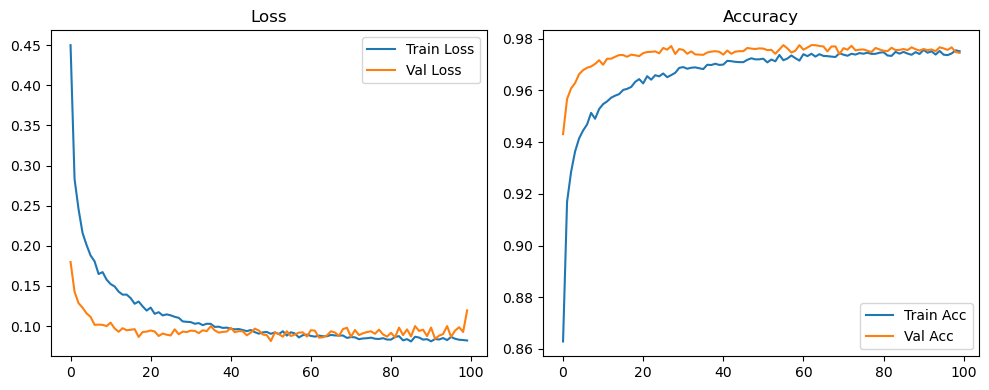

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2383, Acc: 0.9262 | Val Loss: 0.1501, Acc: 0.9537


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1243, Acc: 0.9617 | Val Loss: 0.1168, Acc: 0.9645


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0931, Acc: 0.9711 | Val Loss: 0.1046, Acc: 0.9688


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9764 | Val Loss: 0.1015, Acc: 0.9694


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.0944, Acc: 0.9723


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.1023, Acc: 0.9714


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0963, Acc: 0.9731


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.1046, Acc: 0.9707


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.0967, Acc: 0.9747


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.1016, Acc: 0.9731


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0979, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.1007, Acc: 0.9751


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1004, Acc: 0.9767


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.1062, Acc: 0.9751


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0972, Acc: 0.9751


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0996, Acc: 0.9758


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.1059, Acc: 0.9744


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.1135, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1027, Acc: 0.9771


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1018, Acc: 0.9753


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.1112, Acc: 0.9742


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1286, Acc: 0.9738


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.1112, Acc: 0.9751


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9947 | Val Loss: 0.1073, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9765


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1029, Acc: 0.9747


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1148, Acc: 0.9770


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1011, Acc: 0.9770


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1169, Acc: 0.9765


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1164, Acc: 0.9769


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1337, Acc: 0.9733


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1097, Acc: 0.9742


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1252, Acc: 0.9743


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1181, Acc: 0.9761


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1220, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1012, Acc: 0.9772


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1360, Acc: 0.9768


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1230, Acc: 0.9751


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1281, Acc: 0.9746


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1028, Acc: 0.9769


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1041, Acc: 0.9771


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1274, Acc: 0.9781


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1249, Acc: 0.9764


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.1225, Acc: 0.9758


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1399, Acc: 0.9762


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1327, Acc: 0.9754


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0977, Acc: 0.9766


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1351, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1066, Acc: 0.9759


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.1121, Acc: 0.9773


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1263, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1206, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1366, Acc: 0.9790


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1320, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1430, Acc: 0.9787


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1335, Acc: 0.9789


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1365, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1285, Acc: 0.9800


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1382, Acc: 0.9799


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1644, Acc: 0.9785


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1607, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1565, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1529, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1542, Acc: 0.9784


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1671, Acc: 0.9779


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1563, Acc: 0.9785


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1500, Acc: 0.9787


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1409, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1714, Acc: 0.9766


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1569, Acc: 0.9789


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1490, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1578, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1511, Acc: 0.9779


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1478, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1456, Acc: 0.9768


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9779


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1428, Acc: 0.9778


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1346, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1302, Acc: 0.9777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1455, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1365, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1528, Acc: 0.9783


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1486, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1502, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1622, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1593, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1677, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1862, Acc: 0.9787


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1791, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1747, Acc: 0.9795


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1863, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2007, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1903, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1775, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1907, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1748, Acc: 0.9794


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1718, Acc: 0.9786


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1712, Acc: 0.9794


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1811, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1894, Acc: 0.9791


Final Test Loss: 0.1632 Accuracy: 0.9811


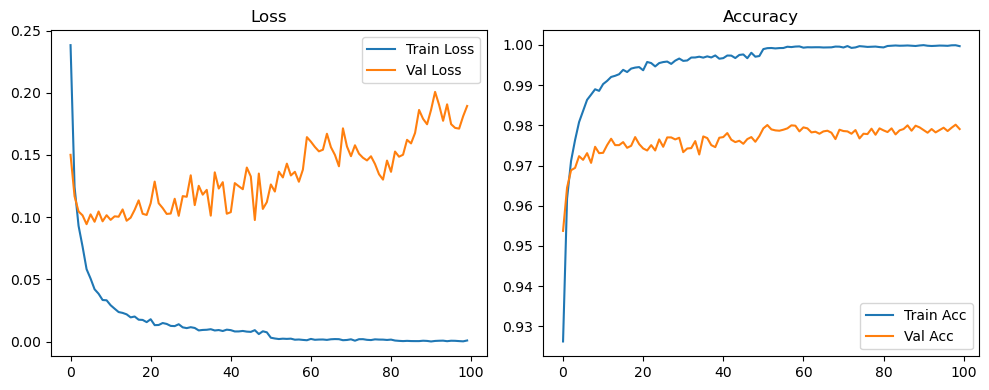

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2904, Acc: 0.9109 | Val Loss: 0.1367, Acc: 0.9572


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1667, Acc: 0.9492 | Val Loss: 0.1221, Acc: 0.9626


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1353, Acc: 0.9583 | Val Loss: 0.1123, Acc: 0.9650


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1132, Acc: 0.9657 | Val Loss: 0.1003, Acc: 0.9697


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0947, Acc: 0.9703 | Val Loss: 0.0920, Acc: 0.9714


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0882, Acc: 0.9724 | Val Loss: 0.0973, Acc: 0.9695


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9743 | Val Loss: 0.0884, Acc: 0.9747


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9775 | Val Loss: 0.0964, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9784 | Val Loss: 0.0988, Acc: 0.9732


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9788 | Val Loss: 0.0856, Acc: 0.9749


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9822 | Val Loss: 0.0962, Acc: 0.9746


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0863, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0859, Acc: 0.9772


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0873, Acc: 0.9763


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9851 | Val Loss: 0.0923, Acc: 0.9746


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9852 | Val Loss: 0.0940, Acc: 0.9769


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9853 | Val Loss: 0.0981, Acc: 0.9756


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 0.0910, Acc: 0.9762


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9870 | Val Loss: 0.0896, Acc: 0.9768


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.0936, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.0851, Acc: 0.9783


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0971, Acc: 0.9776


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.0853, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.1000, Acc: 0.9752


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.0811, Acc: 0.9782


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9893 | Val Loss: 0.0884, Acc: 0.9772


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9885 | Val Loss: 0.0862, Acc: 0.9771


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0915, Acc: 0.9769


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9904 | Val Loss: 0.0841, Acc: 0.9764


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.0882, Acc: 0.9775


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9913 | Val Loss: 0.0879, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.0842, Acc: 0.9766


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0858, Acc: 0.9799


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.0840, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.1019, Acc: 0.9772


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9916 | Val Loss: 0.0857, Acc: 0.9778


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0877, Acc: 0.9785


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0929, Acc: 0.9769


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0905, Acc: 0.9777


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0849, Acc: 0.9772


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0810, Acc: 0.9780


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0945, Acc: 0.9776


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0842, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9912 | Val Loss: 0.0992, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0867, Acc: 0.9792


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9923 | Val Loss: 0.1088, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0903, Acc: 0.9786


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0910, Acc: 0.9786


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0898, Acc: 0.9800


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9933 | Val Loss: 0.0927, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0907, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0957, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0949, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0942, Acc: 0.9785


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0923, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0994, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1035, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0951, Acc: 0.9788


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0942, Acc: 0.9797


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0983, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0995, Acc: 0.9800


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1061, Acc: 0.9790


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1027, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0977, Acc: 0.9799


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0945, Acc: 0.9805


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1090, Acc: 0.9800


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0897, Acc: 0.9806


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0984, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1004, Acc: 0.9795


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0902, Acc: 0.9793


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1070, Acc: 0.9797


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1029, Acc: 0.9797


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1118, Acc: 0.9799


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0976, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0993, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1031, Acc: 0.9787


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0981, Acc: 0.9793


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1124, Acc: 0.9804


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0990, Acc: 0.9801


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1029, Acc: 0.9799


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1035, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1091, Acc: 0.9807


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1092, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1012, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1072, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1012, Acc: 0.9808


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1002, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1025, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1027, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1131, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1075, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0991, Acc: 0.9817


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1021, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1070, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1091, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1019, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0984, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1093, Acc: 0.9802


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1047, Acc: 0.9801


Final Test Loss: 0.1081 Accuracy: 0.9822


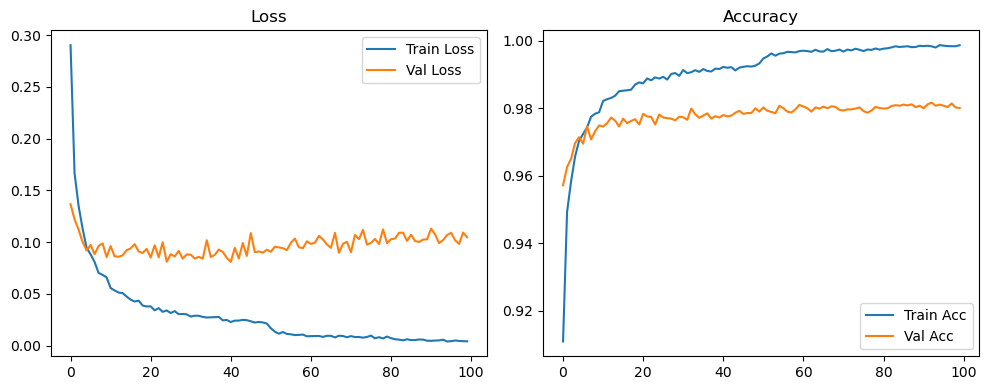

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4501, Acc: 0.8629 | Val Loss: 0.1799, Acc: 0.9431


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2832, Acc: 0.9169 | Val Loss: 0.1427, Acc: 0.9567


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2455, Acc: 0.9284 | Val Loss: 0.1285, Acc: 0.9607


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2159, Acc: 0.9364 | Val Loss: 0.1229, Acc: 0.9628


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2010, Acc: 0.9414 | Val Loss: 0.1158, Acc: 0.9663


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1879, Acc: 0.9445 | Val Loss: 0.1114, Acc: 0.9678


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1806, Acc: 0.9468 | Val Loss: 0.1015, Acc: 0.9688


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1648, Acc: 0.9513 | Val Loss: 0.1018, Acc: 0.9692


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1672, Acc: 0.9490 | Val Loss: 0.1015, Acc: 0.9702


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1578, Acc: 0.9528 | Val Loss: 0.0999, Acc: 0.9717


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1523, Acc: 0.9547 | Val Loss: 0.1043, Acc: 0.9699


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1494, Acc: 0.9557 | Val Loss: 0.0970, Acc: 0.9722


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1429, Acc: 0.9572 | Val Loss: 0.0929, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1391, Acc: 0.9580 | Val Loss: 0.0973, Acc: 0.9730


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1392, Acc: 0.9586 | Val Loss: 0.0948, Acc: 0.9737


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1348, Acc: 0.9602 | Val Loss: 0.0954, Acc: 0.9737


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1278, Acc: 0.9606 | Val Loss: 0.0961, Acc: 0.9730


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.1306, Acc: 0.9613 | Val Loss: 0.0864, Acc: 0.9738


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1245, Acc: 0.9633 | Val Loss: 0.0926, Acc: 0.9736


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.1193, Acc: 0.9644 | Val Loss: 0.0931, Acc: 0.9732


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.1230, Acc: 0.9627 | Val Loss: 0.0945, Acc: 0.9744


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.1152, Acc: 0.9655 | Val Loss: 0.0932, Acc: 0.9748


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.1173, Acc: 0.9641 | Val Loss: 0.0876, Acc: 0.9749


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.1132, Acc: 0.9659 | Val Loss: 0.0906, Acc: 0.9751


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.1145, Acc: 0.9654 | Val Loss: 0.0892, Acc: 0.9743


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.1134, Acc: 0.9665 | Val Loss: 0.0883, Acc: 0.9764


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.1115, Acc: 0.9651 | Val Loss: 0.0959, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.1102, Acc: 0.9659 | Val Loss: 0.0898, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9668 | Val Loss: 0.0931, Acc: 0.9741


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.1053, Acc: 0.9687 | Val Loss: 0.0925, Acc: 0.9760


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9690 | Val Loss: 0.0943, Acc: 0.9757


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9684 | Val Loss: 0.0939, Acc: 0.9742


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.1037, Acc: 0.9688 | Val Loss: 0.0912, Acc: 0.9751


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.1011, Acc: 0.9689 | Val Loss: 0.0947, Acc: 0.9739


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.1028, Acc: 0.9686 | Val Loss: 0.0937, Acc: 0.9738


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9683 | Val Loss: 0.0997, Acc: 0.9738


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0989, Acc: 0.9699 | Val Loss: 0.0946, Acc: 0.9747


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9698 | Val Loss: 0.0918, Acc: 0.9750


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0977, Acc: 0.9703 | Val Loss: 0.0927, Acc: 0.9752


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9699 | Val Loss: 0.0931, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9700 | Val Loss: 0.0977, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0959, Acc: 0.9714 | Val Loss: 0.0923, Acc: 0.9754


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0963, Acc: 0.9713 | Val Loss: 0.0936, Acc: 0.9742


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9710 | Val Loss: 0.0934, Acc: 0.9750


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0937, Acc: 0.9709 | Val Loss: 0.0884, Acc: 0.9752


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0950, Acc: 0.9709 | Val Loss: 0.0918, Acc: 0.9752


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0924, Acc: 0.9718 | Val Loss: 0.0967, Acc: 0.9764


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9724 | Val Loss: 0.0944, Acc: 0.9762


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9720 | Val Loss: 0.0895, Acc: 0.9760


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0926, Acc: 0.9720 | Val Loss: 0.0887, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0813, Acc: 0.9755 | Val Loss: 0.0843, Acc: 0.9777


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9772 | Val Loss: 0.0854, Acc: 0.9780


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0733, Acc: 0.9776 | Val Loss: 0.0850, Acc: 0.9776


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9775 | Val Loss: 0.0827, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9783 | Val Loss: 0.0899, Acc: 0.9781


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9775 | Val Loss: 0.0788, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0681, Acc: 0.9790 | Val Loss: 0.0880, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9802 | Val Loss: 0.0903, Acc: 0.9773


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9790 | Val Loss: 0.0872, Acc: 0.9780


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9802 | Val Loss: 0.0882, Acc: 0.9780


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9804 | Val Loss: 0.0948, Acc: 0.9766


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0637, Acc: 0.9809 | Val Loss: 0.0886, Acc: 0.9783


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0622, Acc: 0.9809 | Val Loss: 0.0890, Acc: 0.9773


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9810 | Val Loss: 0.0893, Acc: 0.9785


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9826 | Val Loss: 0.0913, Acc: 0.9775


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9811 | Val Loss: 0.0899, Acc: 0.9772


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9812 | Val Loss: 0.0869, Acc: 0.9766


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0607, Acc: 0.9816 | Val Loss: 0.0849, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0604, Acc: 0.9815 | Val Loss: 0.0915, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9814 | Val Loss: 0.0957, Acc: 0.9770


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9823 | Val Loss: 0.0903, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9813 | Val Loss: 0.0968, Acc: 0.9773


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9829 | Val Loss: 0.0934, Acc: 0.9777


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9815 | Val Loss: 0.0898, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9829 | Val Loss: 0.0938, Acc: 0.9774


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9819 | Val Loss: 0.0926, Acc: 0.9763


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9831 | Val Loss: 0.0952, Acc: 0.9761


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9824 | Val Loss: 0.0975, Acc: 0.9760


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9828 | Val Loss: 0.0956, Acc: 0.9780


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9821 | Val Loss: 0.0945, Acc: 0.9776


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9839 | Val Loss: 0.0900, Acc: 0.9777


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9828 | Val Loss: 0.0917, Acc: 0.9774


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0977, Acc: 0.9777


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 0.0942, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9846 | Val Loss: 0.0935, Acc: 0.9780


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9851 | Val Loss: 0.1008, Acc: 0.9776


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9844 | Val Loss: 0.0968, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0509, Acc: 0.9846 | Val Loss: 0.0919, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9845 | Val Loss: 0.0957, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0887, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.0965, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0876, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9859 | Val Loss: 0.0975, Acc: 0.9783


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9858 | Val Loss: 0.0961, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9858 | Val Loss: 0.0936, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0468, Acc: 0.9856 | Val Loss: 0.0969, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9864 | Val Loss: 0.0987, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9857 | Val Loss: 0.0929, Acc: 0.9783


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.0994, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0477, Acc: 0.9847 | Val Loss: 0.0955, Acc: 0.9788


Final Test Loss: 0.0799 Accuracy: 0.9809


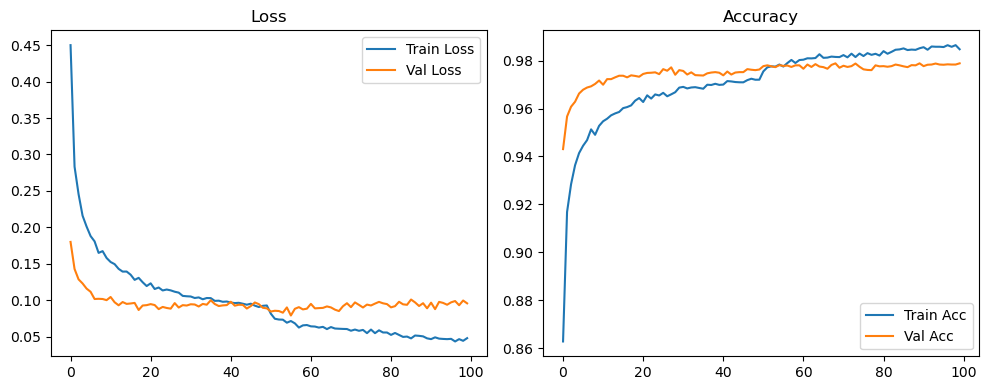

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2240, Acc: 0.9314 | Val Loss: 0.1187, Acc: 0.9651


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1126, Acc: 0.9646 | Val Loss: 0.1084, Acc: 0.9651


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0828, Acc: 0.9733 | Val Loss: 0.1080, Acc: 0.9653


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0663, Acc: 0.9789 | Val Loss: 0.0946, Acc: 0.9734


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0493, Acc: 0.9837 | Val Loss: 0.0900, Acc: 0.9744


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9845 | Val Loss: 0.0979, Acc: 0.9725


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9866 | Val Loss: 0.0947, Acc: 0.9732


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1055, Acc: 0.9708


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.1029, Acc: 0.9734


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.1021, Acc: 0.9728


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1027, Acc: 0.9742


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9723


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1025, Acc: 0.9751


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.1023, Acc: 0.9752


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.1126, Acc: 0.9722


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1072, Acc: 0.9753


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0946, Acc: 0.9771


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1129, Acc: 0.9765


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.1015, Acc: 0.9776


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1156, Acc: 0.9741


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1021, Acc: 0.9769


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1199, Acc: 0.9757


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1110, Acc: 0.9755


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1181, Acc: 0.9745


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1051, Acc: 0.9785


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0989, Acc: 0.9778


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1090, Acc: 0.9780


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1035, Acc: 0.9786


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0977, Acc: 0.9787


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1098, Acc: 0.9780


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1235, Acc: 0.9752


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1138, Acc: 0.9790


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1065, Acc: 0.9771


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1222, Acc: 0.9748


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1138, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1126, Acc: 0.9772


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1084, Acc: 0.9763


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1118, Acc: 0.9775


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1117, Acc: 0.9801


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1125, Acc: 0.9788


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1072, Acc: 0.9772


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1134, Acc: 0.9798


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1168, Acc: 0.9783


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1290, Acc: 0.9758


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1114, Acc: 0.9779


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1132, Acc: 0.9798


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1131, Acc: 0.9780


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1167, Acc: 0.9778


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1242, Acc: 0.9763


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1221, Acc: 0.9754


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1295, Acc: 0.9752


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1257, Acc: 0.9750


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1219, Acc: 0.9766


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1238, Acc: 0.9779


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1286, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1152, Acc: 0.9769


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1215, Acc: 0.9769


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1187, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1168, Acc: 0.9779


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1092, Acc: 0.9782


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1141, Acc: 0.9778


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1174, Acc: 0.9771


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1424, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1382, Acc: 0.9758


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1196, Acc: 0.9780


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1274, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1189, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1202, Acc: 0.9784


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1203, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1249, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1226, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1182, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1207, Acc: 0.9790


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1243, Acc: 0.9793


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1152, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1147, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1201, Acc: 0.9779


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1224, Acc: 0.9779


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1413, Acc: 0.9775


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1374, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1341, Acc: 0.9773


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1241, Acc: 0.9782


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1158, Acc: 0.9793


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9986 | Val Loss: 0.1359, Acc: 0.9778


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1219, Acc: 0.9787


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1245, Acc: 0.9784


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1276, Acc: 0.9782


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1176, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1285, Acc: 0.9779


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1334, Acc: 0.9779


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1313, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1246, Acc: 0.9791


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1178, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1143, Acc: 0.9801


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1276, Acc: 0.9790


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1237, Acc: 0.9792


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1131, Acc: 0.9791


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1286, Acc: 0.9783


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1264, Acc: 0.9784


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1283, Acc: 0.9787


Final Test Loss: 0.1187 Accuracy: 0.9802


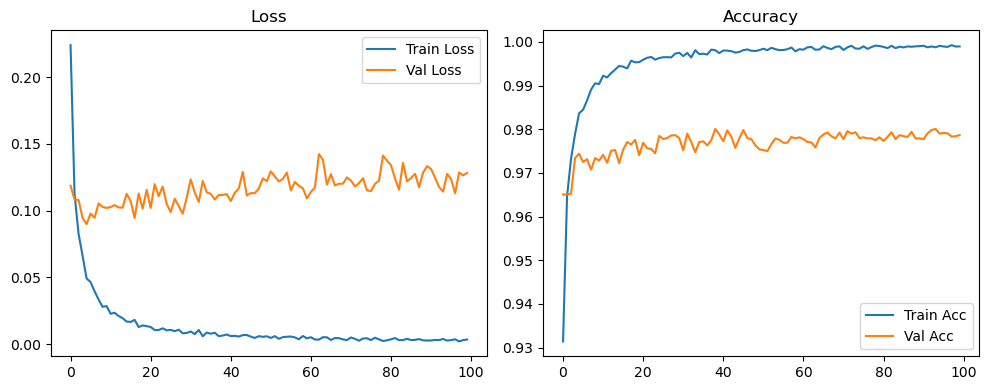

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2863, Acc: 0.9126 | Val Loss: 0.1370, Acc: 0.9573


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1577, Acc: 0.9520 | Val Loss: 0.1111, Acc: 0.9646


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1260, Acc: 0.9612 | Val Loss: 0.1077, Acc: 0.9653


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1084, Acc: 0.9665 | Val Loss: 0.0904, Acc: 0.9724


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0908, Acc: 0.9712 | Val Loss: 0.0902, Acc: 0.9730


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0819, Acc: 0.9743 | Val Loss: 0.0940, Acc: 0.9722


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9755 | Val Loss: 0.0901, Acc: 0.9744


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0655, Acc: 0.9795 | Val Loss: 0.0907, Acc: 0.9731


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9798 | Val Loss: 0.0962, Acc: 0.9727


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9806 | Val Loss: 0.0895, Acc: 0.9762


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9829 | Val Loss: 0.0929, Acc: 0.9744


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9843 | Val Loss: 0.0853, Acc: 0.9752


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9851 | Val Loss: 0.0885, Acc: 0.9768


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9853 | Val Loss: 0.0858, Acc: 0.9780


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9861 | Val Loss: 0.0894, Acc: 0.9752


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9869 | Val Loss: 0.0785, Acc: 0.9781


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.0862, Acc: 0.9765


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.0863, Acc: 0.9763


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9883 | Val Loss: 0.0849, Acc: 0.9767


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0959, Acc: 0.9778


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.0897, Acc: 0.9764


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9902 | Val Loss: 0.0882, Acc: 0.9772


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0902, Acc: 0.9771


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.0934, Acc: 0.9765


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.0906, Acc: 0.9772


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.0889, Acc: 0.9774


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.0942, Acc: 0.9775


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9909 | Val Loss: 0.0865, Acc: 0.9786


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0874, Acc: 0.9785


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.0880, Acc: 0.9792


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0899, Acc: 0.9777


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0871, Acc: 0.9783


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0895, Acc: 0.9782


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0931, Acc: 0.9786


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0958, Acc: 0.9767


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0958, Acc: 0.9781


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0837, Acc: 0.9804


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0911, Acc: 0.9775


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.0995, Acc: 0.9756


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0923, Acc: 0.9790


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0872, Acc: 0.9778


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0902, Acc: 0.9793


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.0901, Acc: 0.9792


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9934 | Val Loss: 0.0940, Acc: 0.9780


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0966, Acc: 0.9788


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0937, Acc: 0.9788


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0936, Acc: 0.9783


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0990, Acc: 0.9793


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0919, Acc: 0.9780


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0942, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0984, Acc: 0.9775


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0941, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0898, Acc: 0.9804


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0978, Acc: 0.9776


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0980, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0912, Acc: 0.9807


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0972, Acc: 0.9797


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1045, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.0919, Acc: 0.9790


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0984, Acc: 0.9781


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0929, Acc: 0.9793


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0952, Acc: 0.9776


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.1073, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0935, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.1008, Acc: 0.9787


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0934, Acc: 0.9795


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1029, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0892, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1012, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0997, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1054, Acc: 0.9783


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0971, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1065, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1064, Acc: 0.9785


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1026, Acc: 0.9788


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0925, Acc: 0.9790


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1046, Acc: 0.9777


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0990, Acc: 0.9791


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0955, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0977, Acc: 0.9796


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0966, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1032, Acc: 0.9788


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0987, Acc: 0.9797


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1043, Acc: 0.9791


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0973, Acc: 0.9797


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1020, Acc: 0.9790


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0970, Acc: 0.9798


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1018, Acc: 0.9796


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1094, Acc: 0.9800


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1007, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0884, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1026, Acc: 0.9790


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1000, Acc: 0.9791


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0929, Acc: 0.9812


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1044, Acc: 0.9799


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1042, Acc: 0.9795


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0992, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1053, Acc: 0.9788


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1061, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1051, Acc: 0.9798


Final Test Loss: 0.0946 Accuracy: 0.9808


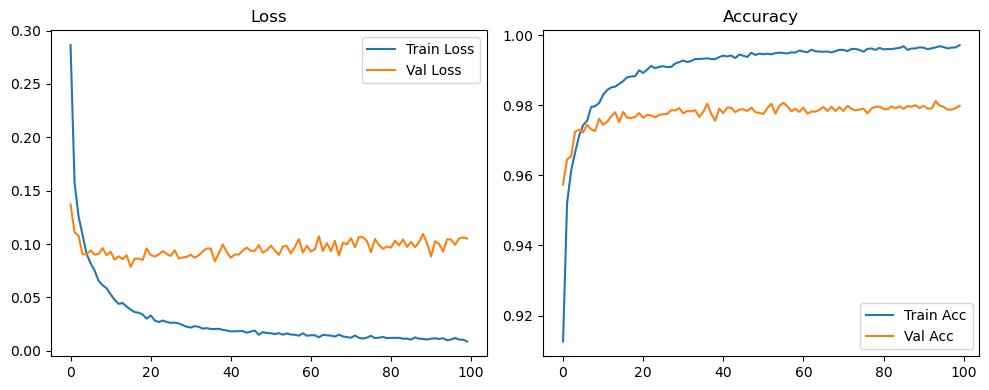

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4615, Acc: 0.8597 | Val Loss: 0.1853, Acc: 0.9424


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2816, Acc: 0.9153 | Val Loss: 0.1453, Acc: 0.9533


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2409, Acc: 0.9276 | Val Loss: 0.1297, Acc: 0.9605


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2119, Acc: 0.9359 | Val Loss: 0.1185, Acc: 0.9645


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1930, Acc: 0.9417 | Val Loss: 0.1099, Acc: 0.9667


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1839, Acc: 0.9456 | Val Loss: 0.1035, Acc: 0.9676


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1655, Acc: 0.9502 | Val Loss: 0.1011, Acc: 0.9692


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1550, Acc: 0.9525 | Val Loss: 0.0988, Acc: 0.9708


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1521, Acc: 0.9535 | Val Loss: 0.0953, Acc: 0.9718


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1454, Acc: 0.9547 | Val Loss: 0.0930, Acc: 0.9705


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1391, Acc: 0.9563 | Val Loss: 0.0975, Acc: 0.9713


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1366, Acc: 0.9583 | Val Loss: 0.0916, Acc: 0.9732


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1300, Acc: 0.9606 | Val Loss: 0.0901, Acc: 0.9744


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1251, Acc: 0.9608 | Val Loss: 0.0913, Acc: 0.9726


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1207, Acc: 0.9626 | Val Loss: 0.0905, Acc: 0.9726


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1153, Acc: 0.9651 | Val Loss: 0.0895, Acc: 0.9745


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.0866, Acc: 0.9741


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1114, Acc: 0.9654 | Val Loss: 0.0866, Acc: 0.9740


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1093, Acc: 0.9667 | Val Loss: 0.0862, Acc: 0.9748


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1048, Acc: 0.9677 | Val Loss: 0.0882, Acc: 0.9742


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1066, Acc: 0.9680 | Val Loss: 0.0877, Acc: 0.9750


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.1031, Acc: 0.9681 | Val Loss: 0.0857, Acc: 0.9752


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.1028, Acc: 0.9679 | Val Loss: 0.0889, Acc: 0.9762


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0983, Acc: 0.9694 | Val Loss: 0.0920, Acc: 0.9747


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0976, Acc: 0.9688 | Val Loss: 0.0880, Acc: 0.9744


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0961, Acc: 0.9702 | Val Loss: 0.0837, Acc: 0.9769


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9705 | Val Loss: 0.0861, Acc: 0.9758


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0906, Acc: 0.9725 | Val Loss: 0.0847, Acc: 0.9766


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0891, Acc: 0.9728 | Val Loss: 0.0867, Acc: 0.9759


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9731 | Val Loss: 0.0840, Acc: 0.9775


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0866, Acc: 0.9723 | Val Loss: 0.0867, Acc: 0.9752


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9738 | Val Loss: 0.0838, Acc: 0.9767


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0869, Acc: 0.9728 | Val Loss: 0.0819, Acc: 0.9777


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0828, Acc: 0.9748 | Val Loss: 0.0872, Acc: 0.9770


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0834, Acc: 0.9744 | Val Loss: 0.0843, Acc: 0.9767


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0827, Acc: 0.9748 | Val Loss: 0.0858, Acc: 0.9768


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0818, Acc: 0.9740 | Val Loss: 0.0863, Acc: 0.9769


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0799, Acc: 0.9748 | Val Loss: 0.0835, Acc: 0.9771


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0769, Acc: 0.9753 | Val Loss: 0.0856, Acc: 0.9771


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0778, Acc: 0.9758 | Val Loss: 0.0851, Acc: 0.9762


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0792, Acc: 0.9757 | Val Loss: 0.0870, Acc: 0.9775


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9760 | Val Loss: 0.0869, Acc: 0.9769


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9765 | Val Loss: 0.0879, Acc: 0.9776


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0755, Acc: 0.9763 | Val Loss: 0.0895, Acc: 0.9770


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9773 | Val Loss: 0.0882, Acc: 0.9775


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0767, Acc: 0.9766 | Val Loss: 0.0888, Acc: 0.9768


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0737, Acc: 0.9768 | Val Loss: 0.0897, Acc: 0.9772


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0687, Acc: 0.9785 | Val Loss: 0.0913, Acc: 0.9758


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0709, Acc: 0.9779 | Val Loss: 0.0869, Acc: 0.9770


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9786 | Val Loss: 0.0920, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0699, Acc: 0.9775 | Val Loss: 0.0859, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9785 | Val Loss: 0.0928, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9776 | Val Loss: 0.0903, Acc: 0.9772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.0907, Acc: 0.9785


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9786 | Val Loss: 0.0874, Acc: 0.9780


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9785 | Val Loss: 0.0841, Acc: 0.9786


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0645, Acc: 0.9797 | Val Loss: 0.0852, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0662, Acc: 0.9795 | Val Loss: 0.0938, Acc: 0.9762


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0669, Acc: 0.9790 | Val Loss: 0.0871, Acc: 0.9767


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9805 | Val Loss: 0.0881, Acc: 0.9780


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0634, Acc: 0.9799 | Val Loss: 0.0898, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0639, Acc: 0.9802 | Val Loss: 0.0886, Acc: 0.9775


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0849, Acc: 0.9776


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9805 | Val Loss: 0.0926, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9802 | Val Loss: 0.0894, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9800 | Val Loss: 0.0834, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9807 | Val Loss: 0.0949, Acc: 0.9770


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0600, Acc: 0.9814 | Val Loss: 0.0868, Acc: 0.9785


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9805 | Val Loss: 0.0864, Acc: 0.9788


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9812 | Val Loss: 0.0862, Acc: 0.9781


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9810 | Val Loss: 0.0865, Acc: 0.9768


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9816 | Val Loss: 0.0903, Acc: 0.9770


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9815 | Val Loss: 0.0885, Acc: 0.9775


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9804 | Val Loss: 0.0897, Acc: 0.9769


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9823 | Val Loss: 0.0875, Acc: 0.9779


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9823 | Val Loss: 0.0919, Acc: 0.9773


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9831 | Val Loss: 0.0937, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9811 | Val Loss: 0.0906, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0577, Acc: 0.9811 | Val Loss: 0.0884, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9818 | Val Loss: 0.0893, Acc: 0.9780


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0571, Acc: 0.9819 | Val Loss: 0.0889, Acc: 0.9769


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9815 | Val Loss: 0.0878, Acc: 0.9766


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.0903, Acc: 0.9768


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.0954, Acc: 0.9776


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9825 | Val Loss: 0.1014, Acc: 0.9754


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9811 | Val Loss: 0.0905, Acc: 0.9772


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9828 | Val Loss: 0.0940, Acc: 0.9762


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.0934, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9817 | Val Loss: 0.0948, Acc: 0.9775


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9832 | Val Loss: 0.0897, Acc: 0.9768


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9832 | Val Loss: 0.0940, Acc: 0.9754


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9824 | Val Loss: 0.0916, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9833 | Val Loss: 0.0894, Acc: 0.9777


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0569, Acc: 0.9822 | Val Loss: 0.0900, Acc: 0.9778


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9824 | Val Loss: 0.0914, Acc: 0.9764


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9824 | Val Loss: 0.0942, Acc: 0.9772


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0522, Acc: 0.9836 | Val Loss: 0.0921, Acc: 0.9765


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9833 | Val Loss: 0.0873, Acc: 0.9770


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9824 | Val Loss: 0.0849, Acc: 0.9772


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0888, Acc: 0.9783


Final Test Loss: 0.0849 Accuracy: 0.9800


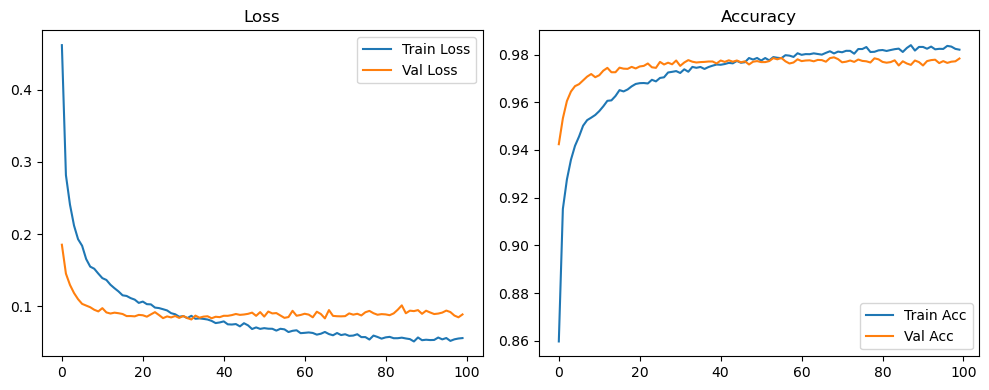

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2276, Acc: 0.9314 | Val Loss: 0.1195, Acc: 0.9632


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1059, Acc: 0.9669 | Val Loss: 0.1044, Acc: 0.9664


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9757 | Val Loss: 0.0991, Acc: 0.9687


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9810 | Val Loss: 0.0913, Acc: 0.9729


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9830 | Val Loss: 0.0949, Acc: 0.9714


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9862 | Val Loss: 0.0959, Acc: 0.9722


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.1074, Acc: 0.9699


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.1016, Acc: 0.9707


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.1003, Acc: 0.9749


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9907 | Val Loss: 0.0945, Acc: 0.9739


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9925 | Val Loss: 0.0915, Acc: 0.9748


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9928 | Val Loss: 0.0986, Acc: 0.9747


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.1090, Acc: 0.9749


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0932, Acc: 0.9775


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1051, Acc: 0.9736


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0994, Acc: 0.9758


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1078, Acc: 0.9756


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0991, Acc: 0.9763


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1057, Acc: 0.9757


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1050, Acc: 0.9756


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1072, Acc: 0.9752


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.1044, Acc: 0.9775


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1158, Acc: 0.9742


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1165, Acc: 0.9750


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1161, Acc: 0.9751


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1072, Acc: 0.9774


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1047, Acc: 0.9772


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1052, Acc: 0.9762


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1041, Acc: 0.9773


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1113, Acc: 0.9761


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1159, Acc: 0.9749


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1085, Acc: 0.9761


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1144, Acc: 0.9762


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1249, Acc: 0.9748


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1192, Acc: 0.9758


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1052, Acc: 0.9780


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1156, Acc: 0.9768


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1175, Acc: 0.9770


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1251, Acc: 0.9753


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1086, Acc: 0.9789


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1177, Acc: 0.9766


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1176, Acc: 0.9773


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1105, Acc: 0.9790


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1185, Acc: 0.9770


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1159, Acc: 0.9761


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1065, Acc: 0.9772


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1076, Acc: 0.9788


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1163, Acc: 0.9776


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1179, Acc: 0.9752


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1138, Acc: 0.9784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1208, Acc: 0.9759


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1132, Acc: 0.9772


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1218, Acc: 0.9775


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1137, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1189, Acc: 0.9790


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1150, Acc: 0.9765


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1074, Acc: 0.9789


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1224, Acc: 0.9763


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1177, Acc: 0.9782


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1184, Acc: 0.9770


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1193, Acc: 0.9773


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1141, Acc: 0.9782


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1098, Acc: 0.9788


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1085, Acc: 0.9792


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1139, Acc: 0.9789


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1135, Acc: 0.9779


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1153, Acc: 0.9787


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1212, Acc: 0.9779


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1254, Acc: 0.9756


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1130, Acc: 0.9790


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1284, Acc: 0.9768


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1211, Acc: 0.9785


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1139, Acc: 0.9784


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.1211, Acc: 0.9782


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9781


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1171, Acc: 0.9785


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1260, Acc: 0.9792


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1256, Acc: 0.9785


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1127, Acc: 0.9794


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9794


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1244, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1223, Acc: 0.9784


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1216, Acc: 0.9793


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1189, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9793


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1322, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1294, Acc: 0.9780


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1125, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1276, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1292, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1211, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1181, Acc: 0.9799


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1211, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1200, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1209, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1209, Acc: 0.9771


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1280, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1338, Acc: 0.9789


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1348, Acc: 0.9790


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1223, Acc: 0.9790


Final Test Loss: 0.1122 Accuracy: 0.9794


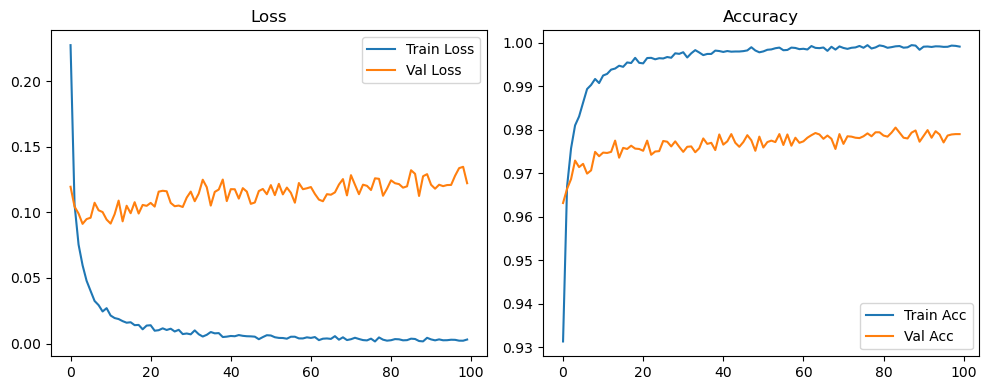

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2997, Acc: 0.9085 | Val Loss: 0.1322, Acc: 0.9602


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1545, Acc: 0.9517 | Val Loss: 0.1097, Acc: 0.9658


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1230, Acc: 0.9617 | Val Loss: 0.0985, Acc: 0.9696


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1056, Acc: 0.9675 | Val Loss: 0.0895, Acc: 0.9718


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9707 | Val Loss: 0.0890, Acc: 0.9737


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9739 | Val Loss: 0.0885, Acc: 0.9735


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0712, Acc: 0.9773 | Val Loss: 0.0854, Acc: 0.9745


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0623, Acc: 0.9812 | Val Loss: 0.0829, Acc: 0.9746


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9794 | Val Loss: 0.0920, Acc: 0.9735


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9805 | Val Loss: 0.0794, Acc: 0.9778


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9836 | Val Loss: 0.0848, Acc: 0.9759


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9842 | Val Loss: 0.0810, Acc: 0.9773


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9857 | Val Loss: 0.0892, Acc: 0.9754


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9852 | Val Loss: 0.0883, Acc: 0.9768


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9871 | Val Loss: 0.0942, Acc: 0.9752


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9875 | Val Loss: 0.0898, Acc: 0.9777


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.0867, Acc: 0.9755


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.0951, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.0861, Acc: 0.9767


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0909, Acc: 0.9764


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9885 | Val Loss: 0.1022, Acc: 0.9744


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.0842, Acc: 0.9787


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9903 | Val Loss: 0.0909, Acc: 0.9758


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0950, Acc: 0.9768


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0880, Acc: 0.9782


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0862, Acc: 0.9782


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0884, Acc: 0.9784


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0798, Acc: 0.9808


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0858, Acc: 0.9792


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0904, Acc: 0.9792


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0900, Acc: 0.9788


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.0890, Acc: 0.9784


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9919 | Val Loss: 0.0873, Acc: 0.9771


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0919, Acc: 0.9776


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0905, Acc: 0.9780


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0900, Acc: 0.9782


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0904, Acc: 0.9793


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0903, Acc: 0.9778


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9943 | Val Loss: 0.0938, Acc: 0.9779


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0885, Acc: 0.9800


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9943 | Val Loss: 0.0907, Acc: 0.9778


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0888, Acc: 0.9798


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0939, Acc: 0.9794


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0850, Acc: 0.9802


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0967, Acc: 0.9775


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0918, Acc: 0.9798


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0919, Acc: 0.9799


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.0921, Acc: 0.9790


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0926, Acc: 0.9799


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9953 | Val Loss: 0.0953, Acc: 0.9784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0912, Acc: 0.9783


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0894, Acc: 0.9793


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0925, Acc: 0.9785


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0938, Acc: 0.9792


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0890, Acc: 0.9804


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0919, Acc: 0.9805


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0919, Acc: 0.9793


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0957, Acc: 0.9794


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.0927, Acc: 0.9798


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0931, Acc: 0.9788


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1005, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0989, Acc: 0.9789


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0998, Acc: 0.9788


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0904, Acc: 0.9800


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9956 | Val Loss: 0.0937, Acc: 0.9801


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0974, Acc: 0.9788


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0994, Acc: 0.9787


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0977, Acc: 0.9789


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1023, Acc: 0.9789


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0999, Acc: 0.9788


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.1030, Acc: 0.9789


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0993, Acc: 0.9788


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0963, Acc: 0.9807


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0989, Acc: 0.9799


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1003, Acc: 0.9792


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.0972, Acc: 0.9802


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0979, Acc: 0.9802


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0993, Acc: 0.9807


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.1073, Acc: 0.9789


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0999, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0919, Acc: 0.9805


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1003, Acc: 0.9787


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0997, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1009, Acc: 0.9793


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1098, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1032, Acc: 0.9805


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1019, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0929, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0961, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0916, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1000, Acc: 0.9794


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0961, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0998, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1005, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1018, Acc: 0.9803


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0987, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1007, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0946, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0970, Acc: 0.9800


Final Test Loss: 0.0958 Accuracy: 0.9807


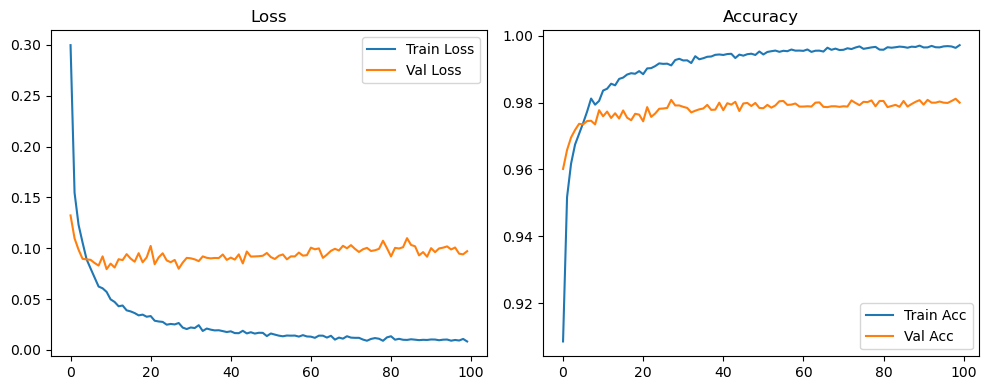

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5110, Acc: 0.8465 | Val Loss: 0.1919, Acc: 0.9417


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2864, Acc: 0.9130 | Val Loss: 0.1496, Acc: 0.9527


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2427, Acc: 0.9271 | Val Loss: 0.1304, Acc: 0.9594


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2204, Acc: 0.9336 | Val Loss: 0.1232, Acc: 0.9609


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1965, Acc: 0.9403 | Val Loss: 0.1119, Acc: 0.9667


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1805, Acc: 0.9460 | Val Loss: 0.1118, Acc: 0.9655


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1671, Acc: 0.9490 | Val Loss: 0.1011, Acc: 0.9693


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1592, Acc: 0.9510 | Val Loss: 0.0999, Acc: 0.9695


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1507, Acc: 0.9530 | Val Loss: 0.1006, Acc: 0.9704


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1439, Acc: 0.9559 | Val Loss: 0.0957, Acc: 0.9711


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1395, Acc: 0.9575 | Val Loss: 0.0966, Acc: 0.9717


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1348, Acc: 0.9587 | Val Loss: 0.0890, Acc: 0.9742


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1280, Acc: 0.9610 | Val Loss: 0.0915, Acc: 0.9737


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1244, Acc: 0.9616 | Val Loss: 0.0872, Acc: 0.9745


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1183, Acc: 0.9632 | Val Loss: 0.0922, Acc: 0.9729


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1135, Acc: 0.9647 | Val Loss: 0.0873, Acc: 0.9755


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1103, Acc: 0.9662 | Val Loss: 0.0867, Acc: 0.9752


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9651 | Val Loss: 0.0902, Acc: 0.9741


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1076, Acc: 0.9664 | Val Loss: 0.0836, Acc: 0.9762


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.0859, Acc: 0.9762


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1045, Acc: 0.9666 | Val Loss: 0.0857, Acc: 0.9748


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0989, Acc: 0.9687 | Val Loss: 0.0851, Acc: 0.9739


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0955, Acc: 0.9707 | Val Loss: 0.0869, Acc: 0.9748


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0898, Acc: 0.9714 | Val Loss: 0.0949, Acc: 0.9748


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0967, Acc: 0.9696 | Val Loss: 0.0860, Acc: 0.9758


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0910, Acc: 0.9721 | Val Loss: 0.0839, Acc: 0.9763


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0891, Acc: 0.9722 | Val Loss: 0.0858, Acc: 0.9768


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9732 | Val Loss: 0.0852, Acc: 0.9759


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0846, Acc: 0.9726 | Val Loss: 0.0827, Acc: 0.9775


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0836, Acc: 0.9730 | Val Loss: 0.0847, Acc: 0.9772


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0802, Acc: 0.9739 | Val Loss: 0.0868, Acc: 0.9765


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0790, Acc: 0.9745 | Val Loss: 0.0820, Acc: 0.9766


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9750 | Val Loss: 0.0814, Acc: 0.9772


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0783, Acc: 0.9754 | Val Loss: 0.0805, Acc: 0.9771


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0794, Acc: 0.9742 | Val Loss: 0.0858, Acc: 0.9762


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0776, Acc: 0.9756 | Val Loss: 0.0857, Acc: 0.9765


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9768 | Val Loss: 0.0842, Acc: 0.9772


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0759, Acc: 0.9756 | Val Loss: 0.0839, Acc: 0.9768


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0717, Acc: 0.9772 | Val Loss: 0.0873, Acc: 0.9765


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9768 | Val Loss: 0.0805, Acc: 0.9778


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9758 | Val Loss: 0.0818, Acc: 0.9768


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0691, Acc: 0.9778 | Val Loss: 0.0827, Acc: 0.9777


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0685, Acc: 0.9780 | Val Loss: 0.0836, Acc: 0.9771


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9781 | Val Loss: 0.0848, Acc: 0.9779


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0672, Acc: 0.9786 | Val Loss: 0.0847, Acc: 0.9775


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9769 | Val Loss: 0.0850, Acc: 0.9766


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9787 | Val Loss: 0.0884, Acc: 0.9766


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0639, Acc: 0.9798 | Val Loss: 0.0932, Acc: 0.9758


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9791 | Val Loss: 0.0900, Acc: 0.9772


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0678, Acc: 0.9780 | Val Loss: 0.0869, Acc: 0.9778


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9788 | Val Loss: 0.0855, Acc: 0.9765


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9795 | Val Loss: 0.0918, Acc: 0.9770


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9796 | Val Loss: 0.0884, Acc: 0.9765


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9798 | Val Loss: 0.0909, Acc: 0.9763


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0655, Acc: 0.9794 | Val Loss: 0.0862, Acc: 0.9778


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0640, Acc: 0.9792 | Val Loss: 0.0852, Acc: 0.9766


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9800 | Val Loss: 0.0896, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9805 | Val Loss: 0.0870, Acc: 0.9766


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0621, Acc: 0.9798 | Val Loss: 0.0848, Acc: 0.9768


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0624, Acc: 0.9804 | Val Loss: 0.0866, Acc: 0.9780


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9821 | Val Loss: 0.0881, Acc: 0.9771


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0585, Acc: 0.9807 | Val Loss: 0.0856, Acc: 0.9782


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.0898, Acc: 0.9781


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9820 | Val Loss: 0.0923, Acc: 0.9768


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9819 | Val Loss: 0.0860, Acc: 0.9773


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0577, Acc: 0.9814 | Val Loss: 0.0937, Acc: 0.9758


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9815 | Val Loss: 0.0890, Acc: 0.9770


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9821 | Val Loss: 0.0862, Acc: 0.9768


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0588, Acc: 0.9812 | Val Loss: 0.0862, Acc: 0.9778


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0553, Acc: 0.9826 | Val Loss: 0.0886, Acc: 0.9770


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9822 | Val Loss: 0.0908, Acc: 0.9767


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9819 | Val Loss: 0.0872, Acc: 0.9764


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 0.0882, Acc: 0.9772


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0530, Acc: 0.9828 | Val Loss: 0.0919, Acc: 0.9774


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0546, Acc: 0.9824 | Val Loss: 0.0902, Acc: 0.9763


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0540, Acc: 0.9818 | Val Loss: 0.0851, Acc: 0.9778


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9835 | Val Loss: 0.0901, Acc: 0.9777


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9825 | Val Loss: 0.0881, Acc: 0.9778


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9826 | Val Loss: 0.0852, Acc: 0.9793


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9835 | Val Loss: 0.0855, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9839 | Val Loss: 0.0858, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0543, Acc: 0.9828 | Val Loss: 0.0875, Acc: 0.9773


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9824 | Val Loss: 0.0861, Acc: 0.9775


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0840, Acc: 0.9784


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9828 | Val Loss: 0.0894, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0492, Acc: 0.9839 | Val Loss: 0.0928, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9824 | Val Loss: 0.0895, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9838 | Val Loss: 0.0888, Acc: 0.9773


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0513, Acc: 0.9832 | Val Loss: 0.0882, Acc: 0.9768


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9842 | Val Loss: 0.0862, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9838 | Val Loss: 0.0900, Acc: 0.9770


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9842 | Val Loss: 0.0910, Acc: 0.9771


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9839 | Val Loss: 0.0886, Acc: 0.9773


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9844 | Val Loss: 0.0898, Acc: 0.9780


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9846 | Val Loss: 0.0892, Acc: 0.9780


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9844 | Val Loss: 0.0942, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.0924, Acc: 0.9771


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9839 | Val Loss: 0.0913, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9857 | Val Loss: 0.0919, Acc: 0.9772


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9856 | Val Loss: 0.0920, Acc: 0.9779


Final Test Loss: 0.0849 Accuracy: 0.9804


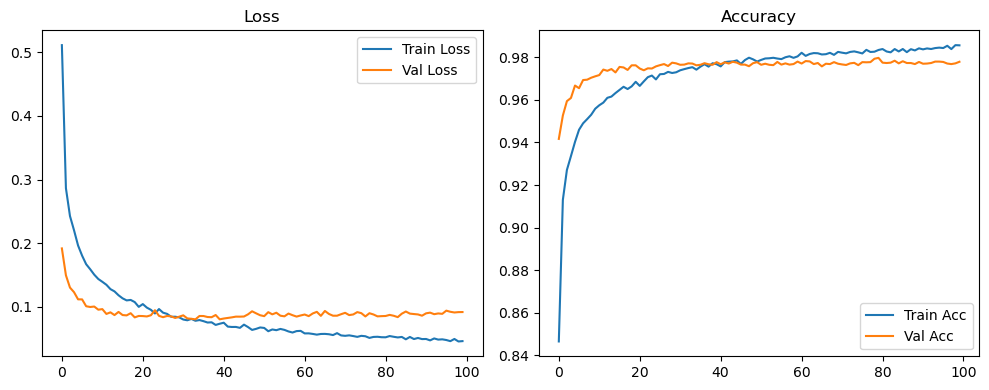

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2310, Acc: 0.9293 | Val Loss: 0.1397, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9647 | Val Loss: 0.1182, Acc: 0.9625


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.1116, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9801 | Val Loss: 0.1035, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9818 | Val Loss: 0.0982, Acc: 0.9717


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.1059, Acc: 0.9703


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9874 | Val Loss: 0.1041, Acc: 0.9736


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1047, Acc: 0.9718


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9891 | Val Loss: 0.1141, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.1118, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1222, Acc: 0.9720


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1044, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1160, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1164, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1097, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.1030, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9733


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1061, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1220, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1218, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1041, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1139, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1085, Acc: 0.9732


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1161, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1164, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1114, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1491, Acc: 0.9707


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1113, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1125, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1341, Acc: 0.9729


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9762


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1061, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1188, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1208, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1159, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1388, Acc: 0.9737


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1241, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1318, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1032, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1345, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1200, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1336, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1293, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1445, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1536, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1393, Acc: 0.9738


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1453, Acc: 0.9748


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1372, Acc: 0.9766


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1682, Acc: 0.9736


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1417, Acc: 0.9752


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1232, Acc: 0.9752


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1304, Acc: 0.9748


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1393, Acc: 0.9738


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1231, Acc: 0.9762


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1328, Acc: 0.9752


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1544, Acc: 0.9757


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1086, Acc: 0.9749


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1333, Acc: 0.9748


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1155, Acc: 0.9758


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1149, Acc: 0.9757


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1254, Acc: 0.9763


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1242, Acc: 0.9742


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1129, Acc: 0.9760


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1213, Acc: 0.9761


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1310, Acc: 0.9768


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1319, Acc: 0.9780


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1343, Acc: 0.9768


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1049, Acc: 0.9768


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1201, Acc: 0.9759


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1042, Acc: 0.9742


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1539, Acc: 0.9751


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1296, Acc: 0.9776


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1354, Acc: 0.9772


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1410, Acc: 0.9778


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1193, Acc: 0.9766


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1101, Acc: 0.9772


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1352, Acc: 0.9748


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1291, Acc: 0.9773


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1488, Acc: 0.9742


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1354, Acc: 0.9764


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1326, Acc: 0.9745


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1616, Acc: 0.9739


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1202, Acc: 0.9758


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1335, Acc: 0.9765


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1460, Acc: 0.9757


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1299, Acc: 0.9758


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1400, Acc: 0.9754


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1637, Acc: 0.9753


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1457, Acc: 0.9752


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1124, Acc: 0.9768


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1435, Acc: 0.9766


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9764


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1523, Acc: 0.9748


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1405, Acc: 0.9758


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1061, Acc: 0.9767


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1267, Acc: 0.9792


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1433, Acc: 0.9738


Final Test Loss: 0.1318 Accuracy: 0.9778


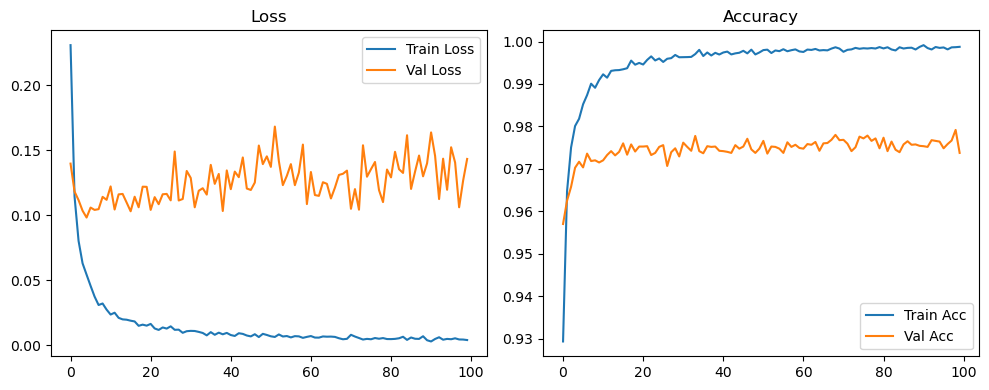

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2795, Acc: 0.9144 | Val Loss: 0.1426, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9531 | Val Loss: 0.1139, Acc: 0.9654


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1158, Acc: 0.9644 | Val Loss: 0.1181, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9701 | Val Loss: 0.1129, Acc: 0.9660


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9720 | Val Loss: 0.1019, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9747 | Val Loss: 0.0936, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9784 | Val Loss: 0.0927, Acc: 0.9726


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0897, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1003, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9812 | Val Loss: 0.0931, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.0983, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.0996, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9843 | Val Loss: 0.0934, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.0911, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0929, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.0938, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.0962, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0966, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1011, Acc: 0.9744


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.1019, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1080, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0934, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1034, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1088, Acc: 0.9765


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0924, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0967, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0957, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0902, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0975, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0960, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0970, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0974, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0975, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1057, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0969, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1126, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1178, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0912, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0922, Acc: 0.9776


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0927, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0988, Acc: 0.9766


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0983, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1003, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1096, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0998, Acc: 0.9764


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1134, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.1005, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1120, Acc: 0.9752


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9936 | Val Loss: 0.0981, Acc: 0.9768


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.1179, Acc: 0.9758


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1082, Acc: 0.9756


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.1033, Acc: 0.9760


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.1178, Acc: 0.9761


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1047, Acc: 0.9772


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0953, Acc: 0.9784


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1190, Acc: 0.9783


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1057, Acc: 0.9768


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.1203, Acc: 0.9774


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1170, Acc: 0.9757


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.1121, Acc: 0.9796


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0966, Acc: 0.9788


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1075, Acc: 0.9785


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1107, Acc: 0.9767


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9941 | Val Loss: 0.0917, Acc: 0.9770


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0903, Acc: 0.9777


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0970, Acc: 0.9776


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0937, Acc: 0.9772


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1036, Acc: 0.9752


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.1089, Acc: 0.9772


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0993, Acc: 0.9767


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1046, Acc: 0.9777


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9766


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0934, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0957, Acc: 0.9765


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.1021, Acc: 0.9758


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.1203, Acc: 0.9770


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1192, Acc: 0.9758


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1166, Acc: 0.9767


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0976, Acc: 0.9763


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1104, Acc: 0.9763


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.1106, Acc: 0.9767


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1163, Acc: 0.9762


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1243, Acc: 0.9771


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0932, Acc: 0.9771


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.1032, Acc: 0.9776


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0996, Acc: 0.9767


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1084, Acc: 0.9779


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.1094, Acc: 0.9782


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0988, Acc: 0.9772


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0858, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.1118, Acc: 0.9792


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9950 | Val Loss: 0.1010, Acc: 0.9776


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0993, Acc: 0.9781


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1034, Acc: 0.9778


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1106, Acc: 0.9782


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1085, Acc: 0.9782


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.1110, Acc: 0.9776


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1065, Acc: 0.9778


Final Test Loss: 0.1008 Accuracy: 0.9794


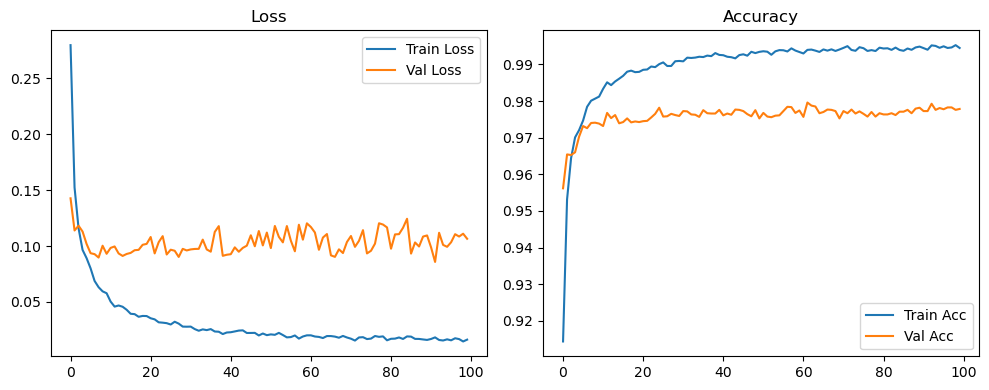

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4370, Acc: 0.8665 | Val Loss: 0.1740, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2730, Acc: 0.9200 | Val Loss: 0.1491, Acc: 0.9548


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2218, Acc: 0.9343 | Val Loss: 0.1327, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9421 | Val Loss: 0.1228, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9467 | Val Loss: 0.1169, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9483 | Val Loss: 0.1176, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1674, Acc: 0.9500 | Val Loss: 0.1132, Acc: 0.9677


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1557, Acc: 0.9540 | Val Loss: 0.1042, Acc: 0.9680


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9545 | Val Loss: 0.1080, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9565 | Val Loss: 0.1155, Acc: 0.9680


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1462, Acc: 0.9560 | Val Loss: 0.1072, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1347, Acc: 0.9595 | Val Loss: 0.1032, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.1052, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.1033, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9613 | Val Loss: 0.1038, Acc: 0.9717


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9628 | Val Loss: 0.0987, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9630 | Val Loss: 0.0954, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9636 | Val Loss: 0.1010, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9651 | Val Loss: 0.0943, Acc: 0.9750


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9656 | Val Loss: 0.1011, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9656 | Val Loss: 0.0985, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9656 | Val Loss: 0.0932, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9665 | Val Loss: 0.0893, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9686 | Val Loss: 0.0960, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9688 | Val Loss: 0.0934, Acc: 0.9726


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9664 | Val Loss: 0.0879, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9688 | Val Loss: 0.0930, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9693 | Val Loss: 0.0906, Acc: 0.9747


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0914, Acc: 0.9749


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9709 | Val Loss: 0.0896, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9694 | Val Loss: 0.0873, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9707 | Val Loss: 0.0896, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9718 | Val Loss: 0.0984, Acc: 0.9728


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9709 | Val Loss: 0.1001, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9712 | Val Loss: 0.0933, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9721 | Val Loss: 0.0926, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.0897, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9696 | Val Loss: 0.0929, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9704 | Val Loss: 0.0862, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9703 | Val Loss: 0.0951, Acc: 0.9755


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9719 | Val Loss: 0.1064, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9727 | Val Loss: 0.0978, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9719 | Val Loss: 0.0936, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9716 | Val Loss: 0.0933, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9726 | Val Loss: 0.0964, Acc: 0.9740


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9711 | Val Loss: 0.0943, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9716 | Val Loss: 0.1017, Acc: 0.9729


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9719 | Val Loss: 0.0957, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9721 | Val Loss: 0.0939, Acc: 0.9752


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9731 | Val Loss: 0.0922, Acc: 0.9742


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9745 | Val Loss: 0.0963, Acc: 0.9750


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9732 | Val Loss: 0.0959, Acc: 0.9735


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0900, Acc: 0.9732 | Val Loss: 0.0927, Acc: 0.9762


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9729 | Val Loss: 0.1043, Acc: 0.9751


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9730 | Val Loss: 0.0941, Acc: 0.9742


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0883, Acc: 0.9740 | Val Loss: 0.0917, Acc: 0.9748


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9730 | Val Loss: 0.0948, Acc: 0.9748


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0898, Acc: 0.9727 | Val Loss: 0.0942, Acc: 0.9738


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0884, Acc: 0.9737 | Val Loss: 0.0869, Acc: 0.9758


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9729 | Val Loss: 0.1015, Acc: 0.9752


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0895, Acc: 0.9729 | Val Loss: 0.0954, Acc: 0.9736


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9737 | Val Loss: 0.0899, Acc: 0.9738


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0905, Acc: 0.9729 | Val Loss: 0.0929, Acc: 0.9756


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0873, Acc: 0.9743 | Val Loss: 0.1099, Acc: 0.9739


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0929, Acc: 0.9717 | Val Loss: 0.1036, Acc: 0.9741


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0886, Acc: 0.9732 | Val Loss: 0.0962, Acc: 0.9757


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9751 | Val Loss: 0.0908, Acc: 0.9754


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9741 | Val Loss: 0.0913, Acc: 0.9758


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0876, Acc: 0.9737 | Val Loss: 0.0976, Acc: 0.9742


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0871, Acc: 0.9741 | Val Loss: 0.0960, Acc: 0.9736


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9740 | Val Loss: 0.0929, Acc: 0.9745


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9758 | Val Loss: 0.1103, Acc: 0.9753


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9747 | Val Loss: 0.0969, Acc: 0.9754


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9754 | Val Loss: 0.0882, Acc: 0.9745


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9756 | Val Loss: 0.0983, Acc: 0.9752


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9753 | Val Loss: 0.1004, Acc: 0.9742


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9743 | Val Loss: 0.0963, Acc: 0.9750


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9750 | Val Loss: 0.0974, Acc: 0.9748


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9747 | Val Loss: 0.0903, Acc: 0.9739


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0832, Acc: 0.9752 | Val Loss: 0.1067, Acc: 0.9739


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0830, Acc: 0.9751 | Val Loss: 0.1008, Acc: 0.9737


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0835, Acc: 0.9745 | Val Loss: 0.0930, Acc: 0.9736


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9761 | Val Loss: 0.0923, Acc: 0.9741


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9757 | Val Loss: 0.0977, Acc: 0.9731


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9749 | Val Loss: 0.0894, Acc: 0.9738


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0843, Acc: 0.9752 | Val Loss: 0.1037, Acc: 0.9753


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9739 | Val Loss: 0.0993, Acc: 0.9750


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0850, Acc: 0.9743 | Val Loss: 0.0976, Acc: 0.9761


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9748 | Val Loss: 0.1025, Acc: 0.9759


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9758 | Val Loss: 0.0915, Acc: 0.9741


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0820, Acc: 0.9754 | Val Loss: 0.0867, Acc: 0.9745


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0840, Acc: 0.9746 | Val Loss: 0.1180, Acc: 0.9746


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9748 | Val Loss: 0.0949, Acc: 0.9738


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9746 | Val Loss: 0.0923, Acc: 0.9761


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0835, Acc: 0.9743 | Val Loss: 0.0917, Acc: 0.9755


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0810, Acc: 0.9755 | Val Loss: 0.0919, Acc: 0.9756


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9757 | Val Loss: 0.1072, Acc: 0.9752


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9749 | Val Loss: 0.1006, Acc: 0.9748


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9748 | Val Loss: 0.1051, Acc: 0.9746


Final Test Loss: 0.0931 Accuracy: 0.9779


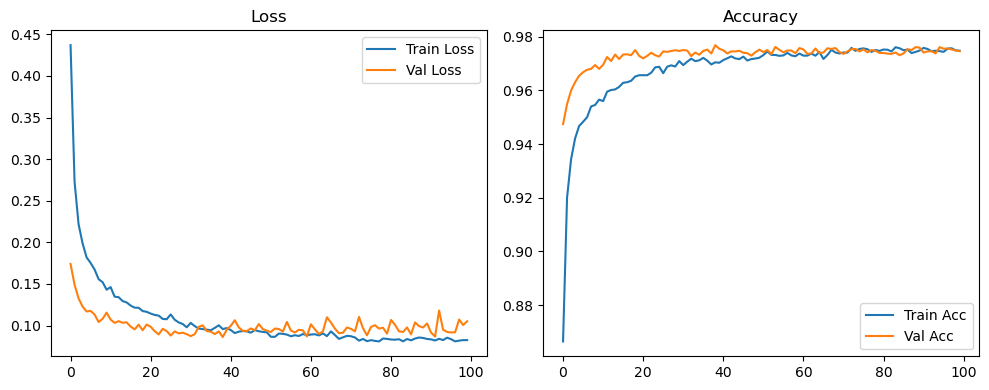

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2310, Acc: 0.9293 | Val Loss: 0.1397, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9647 | Val Loss: 0.1182, Acc: 0.9625


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.1116, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9801 | Val Loss: 0.1035, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9818 | Val Loss: 0.0982, Acc: 0.9717


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.1059, Acc: 0.9703


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9874 | Val Loss: 0.1041, Acc: 0.9736


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1047, Acc: 0.9718


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9891 | Val Loss: 0.1141, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.1118, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1222, Acc: 0.9720


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1044, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1160, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1164, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1097, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.1030, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9733


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1061, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1220, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1218, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1041, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1139, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1085, Acc: 0.9732


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1161, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1164, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1114, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1491, Acc: 0.9707


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1113, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1125, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1341, Acc: 0.9729


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9762


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1061, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1188, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1208, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1159, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1388, Acc: 0.9737


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1241, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1318, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1032, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1345, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1200, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1336, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1293, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1445, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1536, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1393, Acc: 0.9738


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1453, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1340, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1514, Acc: 0.9777


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1547, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1403, Acc: 0.9779


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1526, Acc: 0.9791


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1394, Acc: 0.9787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1869, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1567, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1717, Acc: 0.9764


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1206, Acc: 0.9780


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1204, Acc: 0.9779


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1419, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1605, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1523, Acc: 0.9788


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1523, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1703, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1674, Acc: 0.9769


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1391, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1554, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1562, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1770, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1444, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1419, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1582, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1738, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1276, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1577, Acc: 0.9783


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1308, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1630, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1629, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1645, Acc: 0.9783


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1607, Acc: 0.9790


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1476, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1478, Acc: 0.9786


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1473, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1564, Acc: 0.9800


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1640, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1706, Acc: 0.9801


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1721, Acc: 0.9792


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1818, Acc: 0.9799


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1869, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1682, Acc: 0.9796


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1922, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1786, Acc: 0.9787


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1607, Acc: 0.9803


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1810, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1646, Acc: 0.9807


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1590, Acc: 0.9799


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1597, Acc: 0.9811


Final Test Loss: 0.1484 Accuracy: 0.9804


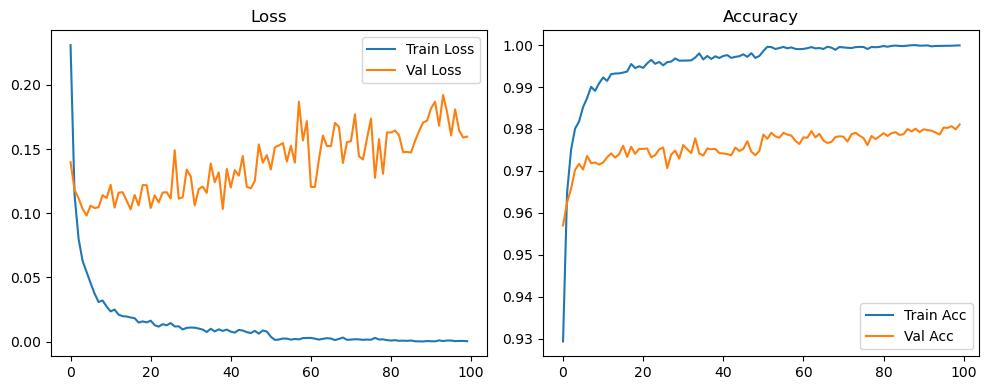

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2795, Acc: 0.9144 | Val Loss: 0.1426, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9531 | Val Loss: 0.1139, Acc: 0.9654


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1158, Acc: 0.9644 | Val Loss: 0.1181, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9701 | Val Loss: 0.1129, Acc: 0.9660


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9720 | Val Loss: 0.1019, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9747 | Val Loss: 0.0936, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9784 | Val Loss: 0.0927, Acc: 0.9726


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0897, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1003, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9812 | Val Loss: 0.0931, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.0983, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.0996, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9843 | Val Loss: 0.0934, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.0911, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0929, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.0938, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.0962, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0966, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1011, Acc: 0.9744


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.1019, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1080, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0934, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1034, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1088, Acc: 0.9765


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0924, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0967, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0957, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0902, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0975, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0960, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0970, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0974, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0975, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1057, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0969, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1126, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1178, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0912, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0922, Acc: 0.9776


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0927, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0988, Acc: 0.9766


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0983, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1003, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1096, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0998, Acc: 0.9764


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1134, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.1005, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1120, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.1001, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1075, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1026, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0987, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1011, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1084, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1032, Acc: 0.9807


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0963, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1027, Acc: 0.9800


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1170, Acc: 0.9801


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1120, Acc: 0.9790


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1268, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1092, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1130, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1207, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1098, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1018, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0961, Acc: 0.9786


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1004, Acc: 0.9796


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1136, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.1229, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1120, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0992, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1108, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1200, Acc: 0.9791


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0885, Acc: 0.9804


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1067, Acc: 0.9799


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1156, Acc: 0.9787


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1229, Acc: 0.9784


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1054, Acc: 0.9781


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1086, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1169, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1122, Acc: 0.9795


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1081, Acc: 0.9800


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1135, Acc: 0.9794


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9794


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1209, Acc: 0.9795


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1105, Acc: 0.9802


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1006, Acc: 0.9796


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1163, Acc: 0.9798


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1037, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1150, Acc: 0.9795


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1075, Acc: 0.9810


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1204, Acc: 0.9810


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1199, Acc: 0.9789


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1155, Acc: 0.9795


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1138, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1101, Acc: 0.9798


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1227, Acc: 0.9791


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1145, Acc: 0.9797


Final Test Loss: 0.1023 Accuracy: 0.9826


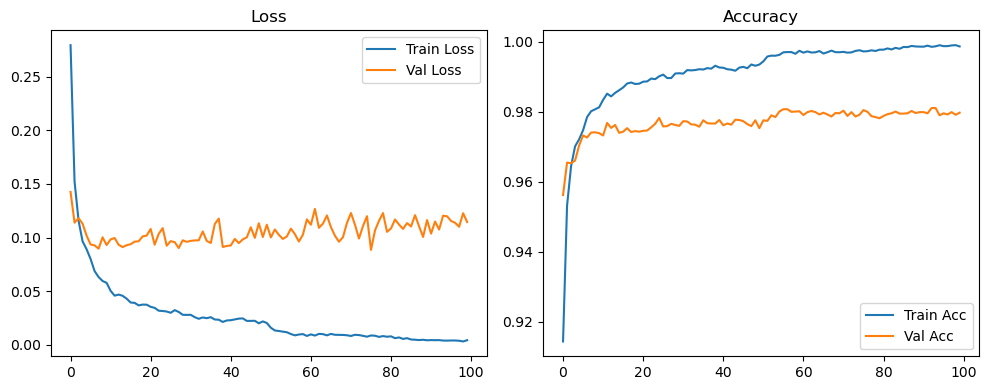

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4370, Acc: 0.8665 | Val Loss: 0.1740, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2730, Acc: 0.9200 | Val Loss: 0.1491, Acc: 0.9548


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2218, Acc: 0.9343 | Val Loss: 0.1327, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9421 | Val Loss: 0.1228, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9467 | Val Loss: 0.1169, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9483 | Val Loss: 0.1176, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1674, Acc: 0.9500 | Val Loss: 0.1132, Acc: 0.9677


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1557, Acc: 0.9540 | Val Loss: 0.1042, Acc: 0.9680


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9545 | Val Loss: 0.1080, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9565 | Val Loss: 0.1155, Acc: 0.9680


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1462, Acc: 0.9560 | Val Loss: 0.1072, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1347, Acc: 0.9595 | Val Loss: 0.1032, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.1052, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.1033, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9613 | Val Loss: 0.1038, Acc: 0.9717


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9628 | Val Loss: 0.0987, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9630 | Val Loss: 0.0954, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9636 | Val Loss: 0.1010, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9651 | Val Loss: 0.0943, Acc: 0.9750


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9656 | Val Loss: 0.1011, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9656 | Val Loss: 0.0985, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9656 | Val Loss: 0.0932, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9665 | Val Loss: 0.0893, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9686 | Val Loss: 0.0960, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9688 | Val Loss: 0.0934, Acc: 0.9726


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9664 | Val Loss: 0.0879, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9688 | Val Loss: 0.0930, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9693 | Val Loss: 0.0906, Acc: 0.9747


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0914, Acc: 0.9749


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9709 | Val Loss: 0.0896, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9694 | Val Loss: 0.0873, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9707 | Val Loss: 0.0896, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9718 | Val Loss: 0.0984, Acc: 0.9728


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9709 | Val Loss: 0.1001, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9712 | Val Loss: 0.0933, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9721 | Val Loss: 0.0926, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.0897, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9696 | Val Loss: 0.0929, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9704 | Val Loss: 0.0862, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9703 | Val Loss: 0.0951, Acc: 0.9755


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9719 | Val Loss: 0.1064, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9727 | Val Loss: 0.0978, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9719 | Val Loss: 0.0936, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9716 | Val Loss: 0.0933, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9726 | Val Loss: 0.0964, Acc: 0.9740


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9711 | Val Loss: 0.0943, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9716 | Val Loss: 0.1017, Acc: 0.9729


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9719 | Val Loss: 0.0957, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9721 | Val Loss: 0.0939, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9761 | Val Loss: 0.0923, Acc: 0.9765


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9791 | Val Loss: 0.0917, Acc: 0.9758


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9784 | Val Loss: 0.0908, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9780 | Val Loss: 0.0949, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9795 | Val Loss: 0.1051, Acc: 0.9762


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9796 | Val Loss: 0.0986, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9797 | Val Loss: 0.0890, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9815 | Val Loss: 0.0977, Acc: 0.9756


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9814 | Val Loss: 0.0970, Acc: 0.9762


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9802 | Val Loss: 0.0922, Acc: 0.9767


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9808 | Val Loss: 0.0982, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9811 | Val Loss: 0.0982, Acc: 0.9751


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9807 | Val Loss: 0.0978, Acc: 0.9759


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9817 | Val Loss: 0.0928, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9822 | Val Loss: 0.0946, Acc: 0.9761


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9818 | Val Loss: 0.0851, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9819 | Val Loss: 0.0920, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9832 | Val Loss: 0.0882, Acc: 0.9765


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9822 | Val Loss: 0.0916, Acc: 0.9758


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9814 | Val Loss: 0.0956, Acc: 0.9752


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9827 | Val Loss: 0.0930, Acc: 0.9759


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9828 | Val Loss: 0.0968, Acc: 0.9748


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9835 | Val Loss: 0.0992, Acc: 0.9767


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9829 | Val Loss: 0.0971, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9831 | Val Loss: 0.0990, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9829 | Val Loss: 0.0878, Acc: 0.9750


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9833 | Val Loss: 0.0891, Acc: 0.9761


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9839 | Val Loss: 0.0978, Acc: 0.9739


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 0.1046, Acc: 0.9760


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9828 | Val Loss: 0.1008, Acc: 0.9781


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9838 | Val Loss: 0.1002, Acc: 0.9778


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9860 | Val Loss: 0.0977, Acc: 0.9773


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9850 | Val Loss: 0.0947, Acc: 0.9769


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9864 | Val Loss: 0.0906, Acc: 0.9781


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9856 | Val Loss: 0.0916, Acc: 0.9771


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0435, Acc: 0.9870 | Val Loss: 0.0998, Acc: 0.9772


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9865 | Val Loss: 0.1013, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9861 | Val Loss: 0.0963, Acc: 0.9775


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9861 | Val Loss: 0.0974, Acc: 0.9768


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.0899, Acc: 0.9769


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0985, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9878 | Val Loss: 0.0915, Acc: 0.9775


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9870 | Val Loss: 0.0999, Acc: 0.9772


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9871 | Val Loss: 0.0954, Acc: 0.9770


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.1021, Acc: 0.9766


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9878 | Val Loss: 0.1046, Acc: 0.9769


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9874 | Val Loss: 0.0952, Acc: 0.9776


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.0883, Acc: 0.9773


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9879 | Val Loss: 0.0955, Acc: 0.9774


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.0977, Acc: 0.9772


Final Test Loss: 0.0826 Accuracy: 0.9795


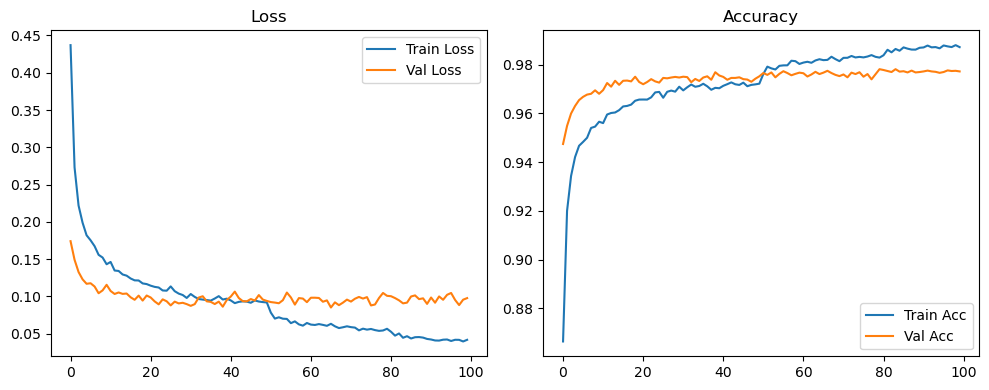

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2310, Acc: 0.9293 | Val Loss: 0.1397, Acc: 0.9570


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1143, Acc: 0.9647 | Val Loss: 0.1182, Acc: 0.9625


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.1116, Acc: 0.9657


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9801 | Val Loss: 0.1035, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9818 | Val Loss: 0.0982, Acc: 0.9717


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.1059, Acc: 0.9703


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9874 | Val Loss: 0.1041, Acc: 0.9736


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1047, Acc: 0.9718


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9891 | Val Loss: 0.1141, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.1118, Acc: 0.9715


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.1222, Acc: 0.9720


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1044, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1160, Acc: 0.9742


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1164, Acc: 0.9732


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1097, Acc: 0.9740


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.1030, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.1142, Acc: 0.9733


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9955 | Val Loss: 0.1061, Acc: 0.9758


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1220, Acc: 0.9741


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.1218, Acc: 0.9752


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1041, Acc: 0.9752


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1139, Acc: 0.9753


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9965 | Val Loss: 0.1085, Acc: 0.9732


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1161, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1164, Acc: 0.9752


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1114, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1491, Acc: 0.9707


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1113, Acc: 0.9739


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1125, Acc: 0.9748


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1341, Acc: 0.9729


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9762


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1061, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.1188, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1208, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1159, Acc: 0.9742


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1388, Acc: 0.9737


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1241, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1318, Acc: 0.9752


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1032, Acc: 0.9752


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1345, Acc: 0.9742


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1200, Acc: 0.9742


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1336, Acc: 0.9740


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1293, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1445, Acc: 0.9756


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1194, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1252, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1536, Acc: 0.9746


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1393, Acc: 0.9738


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1453, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1340, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1514, Acc: 0.9777


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1528, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1547, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1403, Acc: 0.9779


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1526, Acc: 0.9791


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1394, Acc: 0.9787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1869, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1567, Acc: 0.9772


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1717, Acc: 0.9764


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1206, Acc: 0.9780


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1204, Acc: 0.9779


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1419, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1605, Acc: 0.9780


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1523, Acc: 0.9788


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1523, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1703, Acc: 0.9767


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1674, Acc: 0.9769


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1391, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1554, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1562, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1770, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1444, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1419, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1582, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1738, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1276, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1577, Acc: 0.9783


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1308, Acc: 0.9776


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1630, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1590, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1562, Acc: 0.9790


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1612, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1529, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1589, Acc: 0.9790


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1604, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1642, Acc: 0.9786


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1720, Acc: 0.9789


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1761, Acc: 0.9789


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1704, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1752, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1761, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1755, Acc: 0.9793


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1747, Acc: 0.9790


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1683, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1725, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1695, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1741, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1669, Acc: 0.9808


Final Test Loss: 0.1461 Accuracy: 0.9813


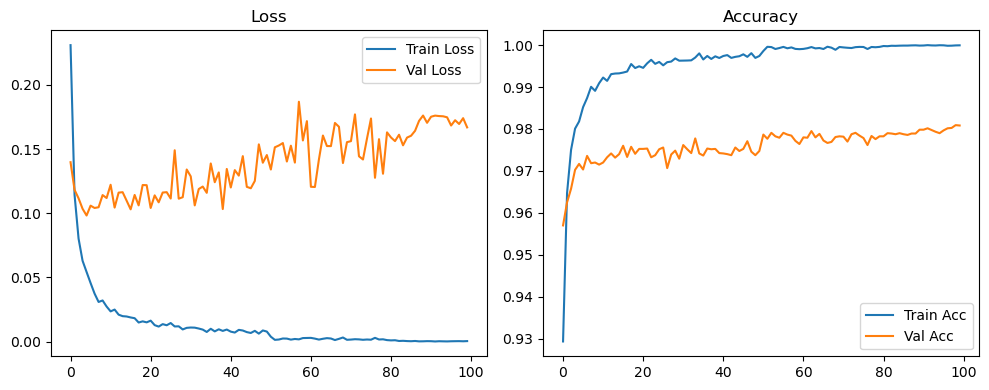

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2795, Acc: 0.9144 | Val Loss: 0.1426, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9531 | Val Loss: 0.1139, Acc: 0.9654


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1158, Acc: 0.9644 | Val Loss: 0.1181, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9701 | Val Loss: 0.1129, Acc: 0.9660


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9720 | Val Loss: 0.1019, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9747 | Val Loss: 0.0936, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9784 | Val Loss: 0.0927, Acc: 0.9726


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0897, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1003, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9812 | Val Loss: 0.0931, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.0983, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.0996, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9843 | Val Loss: 0.0934, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.0911, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0929, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.0938, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.0962, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0966, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1011, Acc: 0.9744


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.1019, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1080, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0934, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1034, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1088, Acc: 0.9765


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0924, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0967, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0957, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0902, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0975, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0960, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0970, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0974, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0975, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1057, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0969, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1126, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1178, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0912, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0922, Acc: 0.9776


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0927, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0988, Acc: 0.9766


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0983, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1003, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1096, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0998, Acc: 0.9764


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1134, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.1005, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1120, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.1001, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1075, Acc: 0.9773


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1026, Acc: 0.9789


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0987, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1011, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1084, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1032, Acc: 0.9807


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0963, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1027, Acc: 0.9800


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1170, Acc: 0.9801


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1120, Acc: 0.9790


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1268, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1092, Acc: 0.9802


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1130, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1207, Acc: 0.9792


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1098, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1018, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0961, Acc: 0.9786


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1004, Acc: 0.9796


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1136, Acc: 0.9795


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.1229, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1120, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0992, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1108, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1200, Acc: 0.9791


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0885, Acc: 0.9804


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1067, Acc: 0.9799


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1156, Acc: 0.9787


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1229, Acc: 0.9784


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1054, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1032, Acc: 0.9784


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1136, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9794


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1105, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1081, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1146, Acc: 0.9801


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1130, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1089, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.1147, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1137, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1090, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1096, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1118, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1187, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1184, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1149, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1174, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1193, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1286, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1204, Acc: 0.9795


Final Test Loss: 0.1082 Accuracy: 0.9821


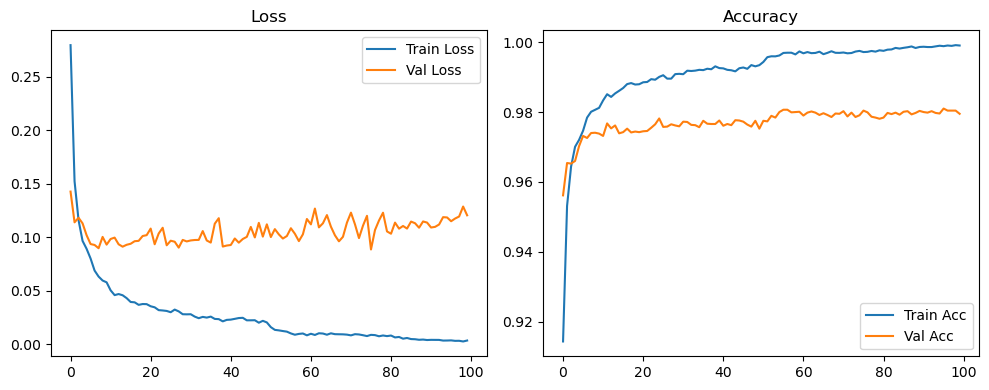

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4370, Acc: 0.8665 | Val Loss: 0.1740, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2730, Acc: 0.9200 | Val Loss: 0.1491, Acc: 0.9548


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2218, Acc: 0.9343 | Val Loss: 0.1327, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9421 | Val Loss: 0.1228, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9467 | Val Loss: 0.1169, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9483 | Val Loss: 0.1176, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1674, Acc: 0.9500 | Val Loss: 0.1132, Acc: 0.9677


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1557, Acc: 0.9540 | Val Loss: 0.1042, Acc: 0.9680


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9545 | Val Loss: 0.1080, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9565 | Val Loss: 0.1155, Acc: 0.9680


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1462, Acc: 0.9560 | Val Loss: 0.1072, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1347, Acc: 0.9595 | Val Loss: 0.1032, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.1052, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.1033, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9613 | Val Loss: 0.1038, Acc: 0.9717


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9628 | Val Loss: 0.0987, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9630 | Val Loss: 0.0954, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9636 | Val Loss: 0.1010, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9651 | Val Loss: 0.0943, Acc: 0.9750


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9656 | Val Loss: 0.1011, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9656 | Val Loss: 0.0985, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9656 | Val Loss: 0.0932, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9665 | Val Loss: 0.0893, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9686 | Val Loss: 0.0960, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9688 | Val Loss: 0.0934, Acc: 0.9726


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9664 | Val Loss: 0.0879, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9688 | Val Loss: 0.0930, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9693 | Val Loss: 0.0906, Acc: 0.9747


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0914, Acc: 0.9749


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9709 | Val Loss: 0.0896, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9694 | Val Loss: 0.0873, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9707 | Val Loss: 0.0896, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9718 | Val Loss: 0.0984, Acc: 0.9728


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9709 | Val Loss: 0.1001, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9712 | Val Loss: 0.0933, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9721 | Val Loss: 0.0926, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.0897, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9696 | Val Loss: 0.0929, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9704 | Val Loss: 0.0862, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9703 | Val Loss: 0.0951, Acc: 0.9755


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9719 | Val Loss: 0.1064, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9727 | Val Loss: 0.0978, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9719 | Val Loss: 0.0936, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9716 | Val Loss: 0.0933, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9726 | Val Loss: 0.0964, Acc: 0.9740


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9711 | Val Loss: 0.0943, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9716 | Val Loss: 0.1017, Acc: 0.9729


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9719 | Val Loss: 0.0957, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9721 | Val Loss: 0.0939, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9761 | Val Loss: 0.0923, Acc: 0.9765


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0702, Acc: 0.9791 | Val Loss: 0.0917, Acc: 0.9758


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9784 | Val Loss: 0.0908, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0700, Acc: 0.9780 | Val Loss: 0.0949, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9795 | Val Loss: 0.1051, Acc: 0.9762


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0641, Acc: 0.9796 | Val Loss: 0.0986, Acc: 0.9772


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9797 | Val Loss: 0.0890, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9815 | Val Loss: 0.0977, Acc: 0.9756


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9814 | Val Loss: 0.0970, Acc: 0.9762


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9802 | Val Loss: 0.0922, Acc: 0.9767


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9808 | Val Loss: 0.0982, Acc: 0.9764


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9811 | Val Loss: 0.0982, Acc: 0.9751


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9807 | Val Loss: 0.0978, Acc: 0.9759


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9817 | Val Loss: 0.0928, Acc: 0.9770


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9822 | Val Loss: 0.0946, Acc: 0.9761


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9818 | Val Loss: 0.0851, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9819 | Val Loss: 0.0920, Acc: 0.9774


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9832 | Val Loss: 0.0882, Acc: 0.9765


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9822 | Val Loss: 0.0916, Acc: 0.9758


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9814 | Val Loss: 0.0956, Acc: 0.9752


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9827 | Val Loss: 0.0930, Acc: 0.9759


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9828 | Val Loss: 0.0968, Acc: 0.9748


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9835 | Val Loss: 0.0992, Acc: 0.9767


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9829 | Val Loss: 0.0971, Acc: 0.9761


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9831 | Val Loss: 0.0990, Acc: 0.9768


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9829 | Val Loss: 0.0878, Acc: 0.9750


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9833 | Val Loss: 0.0891, Acc: 0.9761


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9839 | Val Loss: 0.0978, Acc: 0.9739


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 0.1046, Acc: 0.9760


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0565, Acc: 0.9828 | Val Loss: 0.1008, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0525, Acc: 0.9839 | Val Loss: 0.0975, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9853 | Val Loss: 0.0947, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0504, Acc: 0.9843 | Val Loss: 0.0955, Acc: 0.9776


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9868 | Val Loss: 0.0968, Acc: 0.9776


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.0937, Acc: 0.9771


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9864 | Val Loss: 0.0977, Acc: 0.9773


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9868 | Val Loss: 0.0950, Acc: 0.9775


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.0995, Acc: 0.9771


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9861 | Val Loss: 0.0961, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9868 | Val Loss: 0.0879, Acc: 0.9789


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9863 | Val Loss: 0.0965, Acc: 0.9775


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9878 | Val Loss: 0.0912, Acc: 0.9781


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.0993, Acc: 0.9774


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9877 | Val Loss: 0.0989, Acc: 0.9779


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9876 | Val Loss: 0.0974, Acc: 0.9774


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.0977, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9773


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.0907, Acc: 0.9781


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.0968, Acc: 0.9777


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9875 | Val Loss: 0.0945, Acc: 0.9776


Final Test Loss: 0.0820 Accuracy: 0.9800


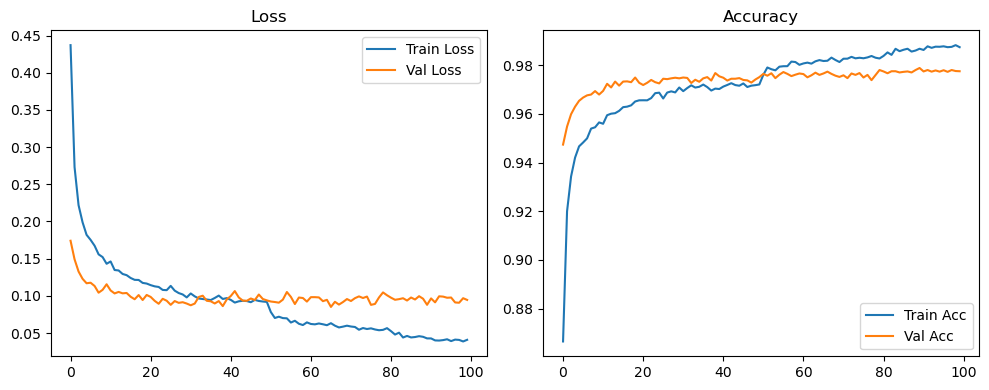

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2299, Acc: 0.9303 | Val Loss: 0.1398, Acc: 0.9579


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1154, Acc: 0.9641 | Val Loss: 0.1108, Acc: 0.9648


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9751 | Val Loss: 0.1115, Acc: 0.9664


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9796 | Val Loss: 0.1101, Acc: 0.9688


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9835 | Val Loss: 0.1114, Acc: 0.9687


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.1111, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9876 | Val Loss: 0.1063, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.1051, Acc: 0.9709


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9892 | Val Loss: 0.1112, Acc: 0.9722


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.1059, Acc: 0.9731


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.1162, Acc: 0.9736


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9912 | Val Loss: 0.1073, Acc: 0.9735


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1022, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1224, Acc: 0.9723


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.1231, Acc: 0.9718


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1160, Acc: 0.9726


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1095, Acc: 0.9733


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1301, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1385, Acc: 0.9683


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1171, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1223, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1187, Acc: 0.9732


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1152, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.1202, Acc: 0.9739


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1146, Acc: 0.9730


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1279, Acc: 0.9751


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1239, Acc: 0.9713


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1196, Acc: 0.9755


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1017, Acc: 0.9744


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1090, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1387, Acc: 0.9737


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1058, Acc: 0.9759


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1299, Acc: 0.9719


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1364, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1214, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1291, Acc: 0.9755


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1241, Acc: 0.9754


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1375, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1267, Acc: 0.9742


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1125, Acc: 0.9751


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1463, Acc: 0.9727


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1292, Acc: 0.9756


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1171, Acc: 0.9760


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1490, Acc: 0.9755


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1397, Acc: 0.9722


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1464, Acc: 0.9743


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1581, Acc: 0.9758


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1553, Acc: 0.9735


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1131, Acc: 0.9743


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1129, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1140, Acc: 0.9791


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1289, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1317, Acc: 0.9807


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1345, Acc: 0.9802


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1470, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1407, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1457, Acc: 0.9800


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1466, Acc: 0.9809


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1573, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1611, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1525, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1569, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1613, Acc: 0.9806


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1505, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1620, Acc: 0.9802


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1529, Acc: 0.9804


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1573, Acc: 0.9797


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1571, Acc: 0.9791


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1690, Acc: 0.9796


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1654, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1705, Acc: 0.9784


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1610, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1729, Acc: 0.9787


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1862, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1807, Acc: 0.9792


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1868, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1552, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1478, Acc: 0.9798


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1610, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1729, Acc: 0.9795


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1715, Acc: 0.9801


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1715, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1663, Acc: 0.9805


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1632, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1633, Acc: 0.9799


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1686, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1673, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1741, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1788, Acc: 0.9805


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1744, Acc: 0.9805


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1802, Acc: 0.9803


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1772, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1767, Acc: 0.9805


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1715, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1794, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1787, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1839, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1821, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1790, Acc: 0.9805


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1796, Acc: 0.9799


Final Test Loss: 0.1761 Accuracy: 0.9798


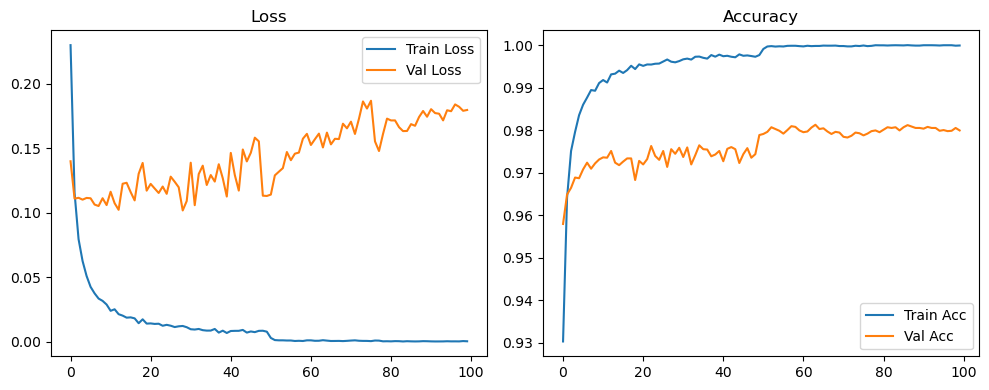

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2795, Acc: 0.9144 | Val Loss: 0.1426, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1523, Acc: 0.9531 | Val Loss: 0.1139, Acc: 0.9654


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1158, Acc: 0.9644 | Val Loss: 0.1181, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0965, Acc: 0.9701 | Val Loss: 0.1129, Acc: 0.9660


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0892, Acc: 0.9720 | Val Loss: 0.1019, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9747 | Val Loss: 0.0936, Acc: 0.9732


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9784 | Val Loss: 0.0927, Acc: 0.9726


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0897, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.1003, Acc: 0.9741


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0578, Acc: 0.9812 | Val Loss: 0.0931, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9833 | Val Loss: 0.0983, Acc: 0.9732


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.0996, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9843 | Val Loss: 0.0934, Acc: 0.9753


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.0911, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0929, Acc: 0.9739


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9869 | Val Loss: 0.0938, Acc: 0.9742


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.0962, Acc: 0.9752


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.0966, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1011, Acc: 0.9744


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.1019, Acc: 0.9742


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9885 | Val Loss: 0.1080, Acc: 0.9745


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0934, Acc: 0.9746


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.1034, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.1088, Acc: 0.9765


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0924, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0967, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0957, Acc: 0.9758


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0902, Acc: 0.9765


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0975, Acc: 0.9762


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0960, Acc: 0.9759


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0970, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0974, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0975, Acc: 0.9763


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.1057, Acc: 0.9762


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0969, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9924 | Val Loss: 0.1126, Acc: 0.9767


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1178, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0912, Acc: 0.9766


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0922, Acc: 0.9776


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0927, Acc: 0.9761


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0988, Acc: 0.9766


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0949, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0983, Acc: 0.9777


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1003, Acc: 0.9776


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1096, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0998, Acc: 0.9764


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1134, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.1005, Acc: 0.9775


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1120, Acc: 0.9752


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0961, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0980, Acc: 0.9783


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1021, Acc: 0.9791


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1090, Acc: 0.9784


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1064, Acc: 0.9783


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1094, Acc: 0.9786


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1104, Acc: 0.9797


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1084, Acc: 0.9801


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1070, Acc: 0.9794


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1144, Acc: 0.9810


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9810


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1118, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1089, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1155, Acc: 0.9812


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1058, Acc: 0.9803


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1133, Acc: 0.9799


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1031, Acc: 0.9807


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1079, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1065, Acc: 0.9807


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1149, Acc: 0.9801


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1164, Acc: 0.9805


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1212, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1085, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1153, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1178, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1013, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1255, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1228, Acc: 0.9801


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1177, Acc: 0.9792


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1089, Acc: 0.9800


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1095, Acc: 0.9806


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1075, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1181, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1120, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1127, Acc: 0.9793


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1155, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1072, Acc: 0.9809


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1183, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1141, Acc: 0.9804


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1107, Acc: 0.9799


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1156, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1074, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1118, Acc: 0.9805


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1176, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1201, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1254, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1200, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1218, Acc: 0.9810


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1228, Acc: 0.9804


Final Test Loss: 0.1082 Accuracy: 0.9829


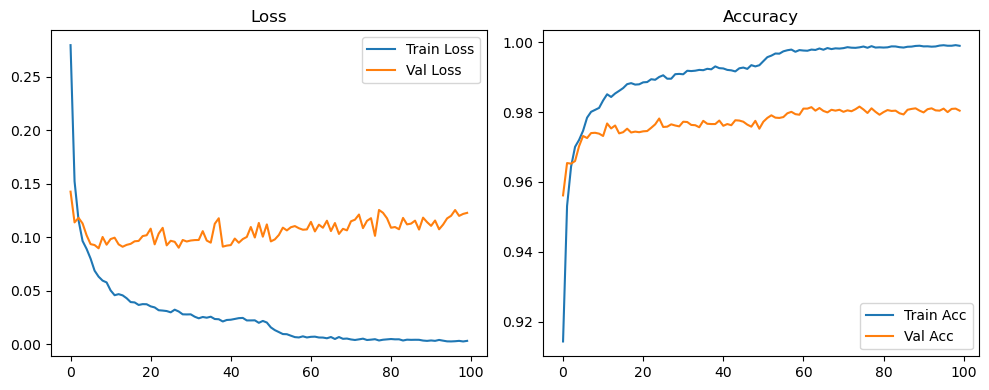

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4370, Acc: 0.8665 | Val Loss: 0.1740, Acc: 0.9474


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2730, Acc: 0.9200 | Val Loss: 0.1491, Acc: 0.9548


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2218, Acc: 0.9343 | Val Loss: 0.1327, Acc: 0.9599


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1989, Acc: 0.9421 | Val Loss: 0.1228, Acc: 0.9630


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1820, Acc: 0.9467 | Val Loss: 0.1169, Acc: 0.9654


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1753, Acc: 0.9483 | Val Loss: 0.1176, Acc: 0.9667


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1674, Acc: 0.9500 | Val Loss: 0.1132, Acc: 0.9677


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1557, Acc: 0.9540 | Val Loss: 0.1042, Acc: 0.9680


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1521, Acc: 0.9545 | Val Loss: 0.1080, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1431, Acc: 0.9565 | Val Loss: 0.1155, Acc: 0.9680


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1462, Acc: 0.9560 | Val Loss: 0.1072, Acc: 0.9695


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1347, Acc: 0.9595 | Val Loss: 0.1032, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1341, Acc: 0.9601 | Val Loss: 0.1052, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.1033, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1278, Acc: 0.9613 | Val Loss: 0.1038, Acc: 0.9717


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1240, Acc: 0.9628 | Val Loss: 0.0987, Acc: 0.9733


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.1215, Acc: 0.9630 | Val Loss: 0.0954, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9636 | Val Loss: 0.1010, Acc: 0.9731


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.1174, Acc: 0.9651 | Val Loss: 0.0943, Acc: 0.9750


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.1165, Acc: 0.9656 | Val Loss: 0.1011, Acc: 0.9728


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9656 | Val Loss: 0.0985, Acc: 0.9719


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.1127, Acc: 0.9656 | Val Loss: 0.0932, Acc: 0.9728


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.1119, Acc: 0.9665 | Val Loss: 0.0893, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.1079, Acc: 0.9686 | Val Loss: 0.0960, Acc: 0.9731


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.1076, Acc: 0.9688 | Val Loss: 0.0934, Acc: 0.9726


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.1134, Acc: 0.9664 | Val Loss: 0.0879, Acc: 0.9745


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9688 | Val Loss: 0.0930, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9693 | Val Loss: 0.0906, Acc: 0.9747


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0914, Acc: 0.9749


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9709 | Val Loss: 0.0896, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9694 | Val Loss: 0.0873, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0993, Acc: 0.9707 | Val Loss: 0.0896, Acc: 0.9748


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0964, Acc: 0.9718 | Val Loss: 0.0984, Acc: 0.9728


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9709 | Val Loss: 0.1001, Acc: 0.9741


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0950, Acc: 0.9712 | Val Loss: 0.0933, Acc: 0.9732


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0943, Acc: 0.9721 | Val Loss: 0.0926, Acc: 0.9747


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0971, Acc: 0.9711 | Val Loss: 0.0897, Acc: 0.9752


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.1003, Acc: 0.9696 | Val Loss: 0.0929, Acc: 0.9738


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9704 | Val Loss: 0.0862, Acc: 0.9768


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0969, Acc: 0.9703 | Val Loss: 0.0951, Acc: 0.9755


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9749


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0909, Acc: 0.9719 | Val Loss: 0.1064, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9727 | Val Loss: 0.0978, Acc: 0.9745


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0933, Acc: 0.9719 | Val Loss: 0.0936, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9716 | Val Loss: 0.0933, Acc: 0.9748


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9726 | Val Loss: 0.0964, Acc: 0.9740


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0945, Acc: 0.9711 | Val Loss: 0.0943, Acc: 0.9738


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9716 | Val Loss: 0.1017, Acc: 0.9729


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0923, Acc: 0.9719 | Val Loss: 0.0957, Acc: 0.9742


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0918, Acc: 0.9721 | Val Loss: 0.0939, Acc: 0.9752


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0774, Acc: 0.9765 | Val Loss: 0.0908, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0698, Acc: 0.9792 | Val Loss: 0.0920, Acc: 0.9759


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9792 | Val Loss: 0.0955, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9796 | Val Loss: 0.0942, Acc: 0.9752


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0659, Acc: 0.9795 | Val Loss: 0.0916, Acc: 0.9770


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9812 | Val Loss: 0.0942, Acc: 0.9775


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9807 | Val Loss: 0.0882, Acc: 0.9778


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9815 | Val Loss: 0.0895, Acc: 0.9775


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0580, Acc: 0.9820 | Val Loss: 0.0914, Acc: 0.9762


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0593, Acc: 0.9819 | Val Loss: 0.0917, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0561, Acc: 0.9831 | Val Loss: 0.0949, Acc: 0.9768


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9825 | Val Loss: 0.0958, Acc: 0.9770


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 0.0912, Acc: 0.9774


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9838 | Val Loss: 0.0910, Acc: 0.9773


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9840 | Val Loss: 0.0864, Acc: 0.9763


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9826 | Val Loss: 0.0868, Acc: 0.9783


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9841 | Val Loss: 0.0944, Acc: 0.9771


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9849 | Val Loss: 0.0832, Acc: 0.9782


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9846 | Val Loss: 0.0895, Acc: 0.9768


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9845 | Val Loss: 0.0932, Acc: 0.9774


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9849 | Val Loss: 0.0940, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9861 | Val Loss: 0.1003, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9852 | Val Loss: 0.0944, Acc: 0.9774


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9858 | Val Loss: 0.0970, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.0975, Acc: 0.9779


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9856 | Val Loss: 0.0904, Acc: 0.9774


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9861 | Val Loss: 0.0876, Acc: 0.9784


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9865 | Val Loss: 0.0943, Acc: 0.9767


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9865 | Val Loss: 0.0973, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9857 | Val Loss: 0.0930, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9857 | Val Loss: 0.0975, Acc: 0.9770


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9875 | Val Loss: 0.0958, Acc: 0.9767


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9868 | Val Loss: 0.0979, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9879 | Val Loss: 0.0985, Acc: 0.9771


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9868 | Val Loss: 0.0937, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9881 | Val Loss: 0.0951, Acc: 0.9773


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0432, Acc: 0.9870 | Val Loss: 0.0951, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 0.0960, Acc: 0.9773


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.0938, Acc: 0.9776


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9880 | Val Loss: 0.0902, Acc: 0.9770


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9870 | Val Loss: 0.0939, Acc: 0.9769


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9881 | Val Loss: 0.0909, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9876 | Val Loss: 0.0980, Acc: 0.9771


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9877 | Val Loss: 0.1004, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0393, Acc: 0.9878 | Val Loss: 0.1014, Acc: 0.9770


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9888 | Val Loss: 0.1008, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9884 | Val Loss: 0.0923, Acc: 0.9782


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9886 | Val Loss: 0.0958, Acc: 0.9771


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9883 | Val Loss: 0.0951, Acc: 0.9777


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.0949, Acc: 0.9778


Final Test Loss: 0.0845 Accuracy: 0.9804


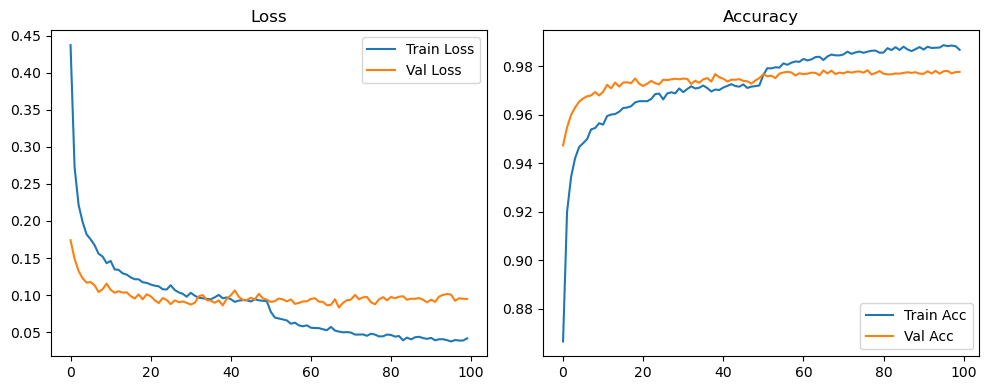

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2192, Acc: 0.9333 | Val Loss: 0.1271, Acc: 0.9622


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1080, Acc: 0.9668 | Val Loss: 0.1142, Acc: 0.9651


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9761 | Val Loss: 0.1237, Acc: 0.9616


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9808 | Val Loss: 0.1094, Acc: 0.9695


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9841 | Val Loss: 0.1051, Acc: 0.9715


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9872 | Val Loss: 0.1058, Acc: 0.9719


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1079, Acc: 0.9716


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1087, Acc: 0.9701


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9911 | Val Loss: 0.1008, Acc: 0.9750


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1090, Acc: 0.9741


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0949, Acc: 0.9770


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1165, Acc: 0.9723


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1114, Acc: 0.9747


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1253, Acc: 0.9706


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1147, Acc: 0.9726


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1111, Acc: 0.9733


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.1082, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1079, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1020, Acc: 0.9787


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1069, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1077, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1038, Acc: 0.9776


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1068, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1221, Acc: 0.9745


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1119, Acc: 0.9748


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.1032, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1073, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1155, Acc: 0.9751


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1137, Acc: 0.9764


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1158, Acc: 0.9774


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1186, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1315, Acc: 0.9746


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1049, Acc: 0.9767


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1141, Acc: 0.9759


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1137, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1183, Acc: 0.9766


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1283, Acc: 0.9741


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1099, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1331, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1168, Acc: 0.9746


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1179, Acc: 0.9756


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1217, Acc: 0.9768


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1231, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1249, Acc: 0.9774


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1321, Acc: 0.9774


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1184, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1147, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1317, Acc: 0.9778


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1182, Acc: 0.9785


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1132, Acc: 0.9759


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1255, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1221, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1180, Acc: 0.9782


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1337, Acc: 0.9774


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1203, Acc: 0.9778


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1281, Acc: 0.9757


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1228, Acc: 0.9784


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1230, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1199, Acc: 0.9786


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1205, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1106, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1311, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1171, Acc: 0.9771


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1334, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1209, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1238, Acc: 0.9765


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1382, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1264, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1346, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1248, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1263, Acc: 0.9777


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1233, Acc: 0.9783


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1224, Acc: 0.9786


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1144, Acc: 0.9777


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1464, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1254, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1113, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1425, Acc: 0.9782


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1275, Acc: 0.9778


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1281, Acc: 0.9782


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9774


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1345, Acc: 0.9764


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1128, Acc: 0.9772


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1171, Acc: 0.9782


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1169, Acc: 0.9778


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1191, Acc: 0.9778


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1351, Acc: 0.9768


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1336, Acc: 0.9786


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1080, Acc: 0.9772


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1275, Acc: 0.9788


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1276, Acc: 0.9754


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1180, Acc: 0.9783


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1241, Acc: 0.9770


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1458, Acc: 0.9758


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1148, Acc: 0.9795


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1454, Acc: 0.9758


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1330, Acc: 0.9781


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1263, Acc: 0.9770


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1474, Acc: 0.9775


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1493, Acc: 0.9768


Final Test Loss: 0.1312 Accuracy: 0.9777


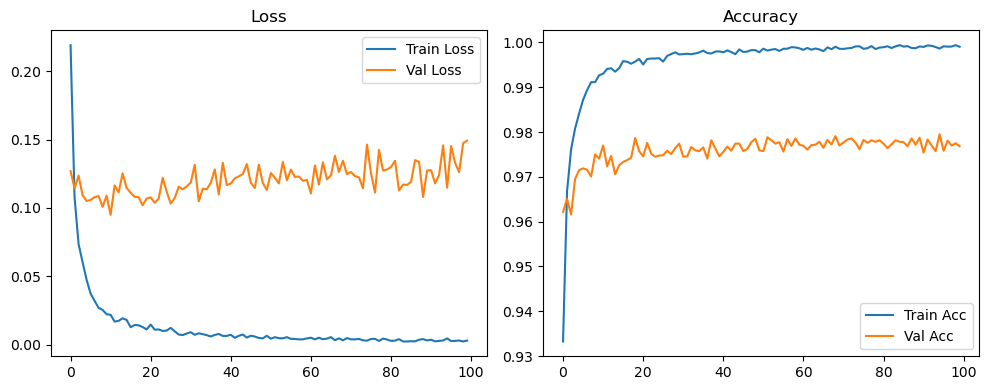

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2729, Acc: 0.9166 | Val Loss: 0.1387, Acc: 0.9587


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1474, Acc: 0.9550 | Val Loss: 0.1144, Acc: 0.9627


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1126, Acc: 0.9655 | Val Loss: 0.1083, Acc: 0.9680


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9714 | Val Loss: 0.1032, Acc: 0.9697


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9732 | Val Loss: 0.0953, Acc: 0.9717


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9776 | Val Loss: 0.0932, Acc: 0.9727


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9791 | Val Loss: 0.0854, Acc: 0.9765


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 0.0853, Acc: 0.9756


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9824 | Val Loss: 0.0888, Acc: 0.9757


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0897, Acc: 0.9751


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9866 | Val Loss: 0.0906, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0897, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0881, Acc: 0.9763


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1101, Acc: 0.9717


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0890, Acc: 0.9765


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0922, Acc: 0.9745


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0933, Acc: 0.9757


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0937, Acc: 0.9770


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0917, Acc: 0.9770


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0861, Acc: 0.9782


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0987, Acc: 0.9752


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0848, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0981, Acc: 0.9762


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0998, Acc: 0.9752


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0953, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0963, Acc: 0.9769


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0912, Acc: 0.9765


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0949, Acc: 0.9772


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0982, Acc: 0.9767


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1051, Acc: 0.9781


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0968, Acc: 0.9795


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0964, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0974, Acc: 0.9778


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0905, Acc: 0.9791


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0907, Acc: 0.9774


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0904, Acc: 0.9780


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0983, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0883, Acc: 0.9785


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1000, Acc: 0.9765


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0877, Acc: 0.9782


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0996, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1005, Acc: 0.9779


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0967, Acc: 0.9786


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0968, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0922, Acc: 0.9784


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1008, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0937, Acc: 0.9788


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0949, Acc: 0.9780


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0909, Acc: 0.9797


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0975, Acc: 0.9789


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0930, Acc: 0.9782


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0974, Acc: 0.9786


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1014, Acc: 0.9793


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0990, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0947, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1006, Acc: 0.9786


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0885, Acc: 0.9799


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0941, Acc: 0.9789


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0941, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0996, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1107, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1185, Acc: 0.9785


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.0997, Acc: 0.9791


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0999, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0984, Acc: 0.9790


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.0996, Acc: 0.9788


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.1044, Acc: 0.9779


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1064, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0881, Acc: 0.9787


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1007, Acc: 0.9785


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0977, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1018, Acc: 0.9777


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1141, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0886, Acc: 0.9794


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1006, Acc: 0.9789


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1119, Acc: 0.9786


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0876, Acc: 0.9783


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0908, Acc: 0.9792


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0986, Acc: 0.9793


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1006, Acc: 0.9788


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0883, Acc: 0.9799


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1036, Acc: 0.9806


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0983, Acc: 0.9778


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0979, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1035, Acc: 0.9779


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0983, Acc: 0.9796


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1029, Acc: 0.9792


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1070, Acc: 0.9787


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0966, Acc: 0.9776


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0979, Acc: 0.9783


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0997, Acc: 0.9789


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1094, Acc: 0.9786


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1162, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1082, Acc: 0.9766


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0868, Acc: 0.9790


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0984, Acc: 0.9786


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1075, Acc: 0.9784


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1009, Acc: 0.9783


Final Test Loss: 0.0908 Accuracy: 0.9806


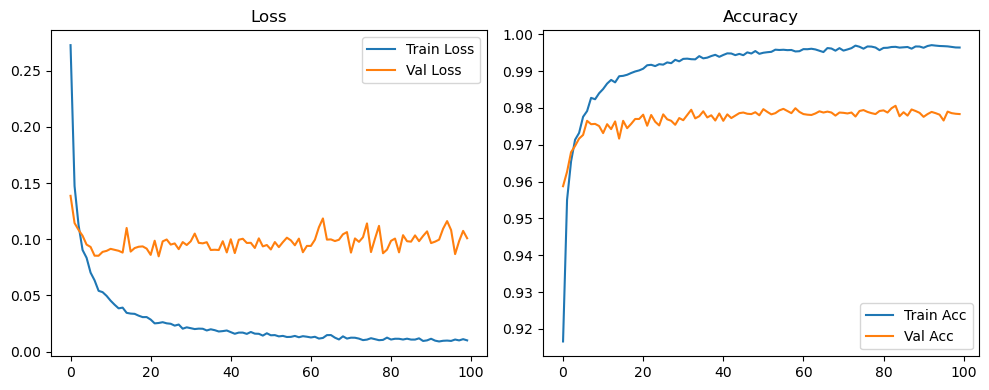

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4327, Acc: 0.8678 | Val Loss: 0.1777, Acc: 0.9452


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2605, Acc: 0.9228 | Val Loss: 0.1380, Acc: 0.9570


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2153, Acc: 0.9364 | Val Loss: 0.1293, Acc: 0.9604


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1873, Acc: 0.9439 | Val Loss: 0.1224, Acc: 0.9634


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1756, Acc: 0.9472 | Val Loss: 0.1130, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1598, Acc: 0.9524 | Val Loss: 0.1048, Acc: 0.9692


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1453, Acc: 0.9562 | Val Loss: 0.1025, Acc: 0.9698


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1434, Acc: 0.9575 | Val Loss: 0.0960, Acc: 0.9723


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1359, Acc: 0.9594 | Val Loss: 0.1059, Acc: 0.9695


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1330, Acc: 0.9600 | Val Loss: 0.1000, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1261, Acc: 0.9616 | Val Loss: 0.0964, Acc: 0.9724


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1192, Acc: 0.9644 | Val Loss: 0.0960, Acc: 0.9730


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1119, Acc: 0.9657 | Val Loss: 0.0948, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1125, Acc: 0.9657 | Val Loss: 0.0940, Acc: 0.9741


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1077, Acc: 0.9673 | Val Loss: 0.0950, Acc: 0.9723


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1053, Acc: 0.9680 | Val Loss: 0.0927, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9689 | Val Loss: 0.0930, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9699 | Val Loss: 0.0901, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0903, Acc: 0.9743


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9718 | Val Loss: 0.0942, Acc: 0.9745


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9706 | Val Loss: 0.0933, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0906, Acc: 0.9715 | Val Loss: 0.0920, Acc: 0.9752


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0917, Acc: 0.9719 | Val Loss: 0.0874, Acc: 0.9758


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9722 | Val Loss: 0.0948, Acc: 0.9735


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9731 | Val Loss: 0.0949, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9733 | Val Loss: 0.0850, Acc: 0.9764


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9742 | Val Loss: 0.0961, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9725 | Val Loss: 0.0860, Acc: 0.9762


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0825, Acc: 0.9742 | Val Loss: 0.0871, Acc: 0.9750


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9740 | Val Loss: 0.0880, Acc: 0.9755


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9749 | Val Loss: 0.0913, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9755 | Val Loss: 0.0896, Acc: 0.9753


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9757 | Val Loss: 0.0877, Acc: 0.9761


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9769 | Val Loss: 0.0916, Acc: 0.9754


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9770 | Val Loss: 0.0957, Acc: 0.9757


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9772 | Val Loss: 0.0927, Acc: 0.9754


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9770 | Val Loss: 0.0872, Acc: 0.9749


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9770 | Val Loss: 0.0896, Acc: 0.9769


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9790 | Val Loss: 0.0911, Acc: 0.9768


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9790 | Val Loss: 0.0882, Acc: 0.9753


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.0948, Acc: 0.9751


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9794 | Val Loss: 0.0898, Acc: 0.9772


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9794 | Val Loss: 0.0905, Acc: 0.9745


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.0930, Acc: 0.9770


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9787 | Val Loss: 0.0908, Acc: 0.9755


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9787 | Val Loss: 0.0886, Acc: 0.9767


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9799 | Val Loss: 0.0883, Acc: 0.9765


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9811 | Val Loss: 0.0913, Acc: 0.9765


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9802 | Val Loss: 0.0917, Acc: 0.9757


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9804 | Val Loss: 0.0997, Acc: 0.9757


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0631, Acc: 0.9799 | Val Loss: 0.0893, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9807 | Val Loss: 0.0973, Acc: 0.9754


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9804 | Val Loss: 0.0887, Acc: 0.9765


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9801 | Val Loss: 0.0892, Acc: 0.9758


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0606, Acc: 0.9813 | Val Loss: 0.0960, Acc: 0.9757


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9805 | Val Loss: 0.0930, Acc: 0.9752


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9803 | Val Loss: 0.0955, Acc: 0.9758


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9820 | Val Loss: 0.0950, Acc: 0.9760


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0595, Acc: 0.9811 | Val Loss: 0.0947, Acc: 0.9762


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9804 | Val Loss: 0.0939, Acc: 0.9762


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9818 | Val Loss: 0.1007, Acc: 0.9756


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9820 | Val Loss: 0.1011, Acc: 0.9764


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9828 | Val Loss: 0.0960, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9823 | Val Loss: 0.0931, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0575, Acc: 0.9823 | Val Loss: 0.0888, Acc: 0.9768


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9811 | Val Loss: 0.0870, Acc: 0.9771


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9815 | Val Loss: 0.0939, Acc: 0.9759


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0587, Acc: 0.9819 | Val Loss: 0.0937, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0558, Acc: 0.9828 | Val Loss: 0.0895, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9828 | Val Loss: 0.0975, Acc: 0.9771


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9819 | Val Loss: 0.0871, Acc: 0.9777


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9839 | Val Loss: 0.0909, Acc: 0.9776


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9831 | Val Loss: 0.0888, Acc: 0.9776


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9820 | Val Loss: 0.0881, Acc: 0.9766


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.0952, Acc: 0.9761


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9835 | Val Loss: 0.0854, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9829 | Val Loss: 0.0824, Acc: 0.9773


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9826 | Val Loss: 0.0926, Acc: 0.9767


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9842 | Val Loss: 0.0939, Acc: 0.9771


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 0.0937, Acc: 0.9778


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9833 | Val Loss: 0.0885, Acc: 0.9778


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9832 | Val Loss: 0.0952, Acc: 0.9760


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9843 | Val Loss: 0.0945, Acc: 0.9778


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9834 | Val Loss: 0.0917, Acc: 0.9771


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9830 | Val Loss: 0.0851, Acc: 0.9766


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0994, Acc: 0.9772


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9845 | Val Loss: 0.0928, Acc: 0.9773


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9831 | Val Loss: 0.0986, Acc: 0.9768


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9844 | Val Loss: 0.0903, Acc: 0.9773


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9831 | Val Loss: 0.0952, Acc: 0.9783


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9839 | Val Loss: 0.0861, Acc: 0.9771


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.0973, Acc: 0.9768


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9838 | Val Loss: 0.0986, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.0998, Acc: 0.9764


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.0908, Acc: 0.9776


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.0969, Acc: 0.9768


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0497, Acc: 0.9847 | Val Loss: 0.1039, Acc: 0.9765


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9843 | Val Loss: 0.0970, Acc: 0.9771


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.0931, Acc: 0.9779


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9854 | Val Loss: 0.0958, Acc: 0.9772


Final Test Loss: 0.0888 Accuracy: 0.9799


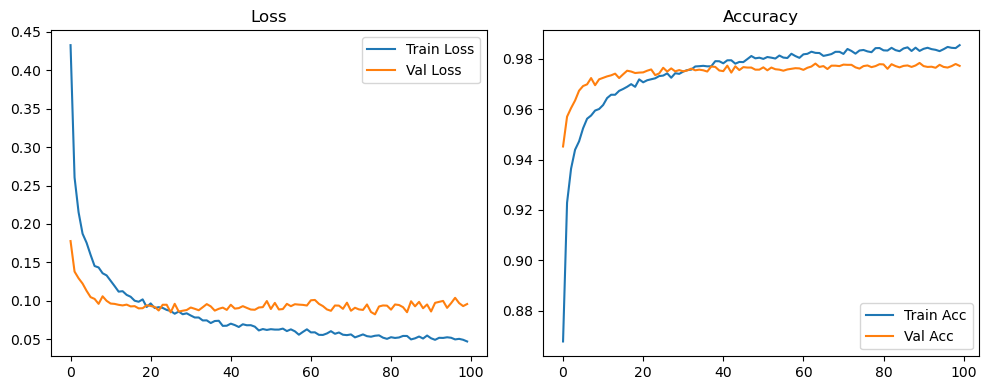

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2192, Acc: 0.9333 | Val Loss: 0.1271, Acc: 0.9622


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1080, Acc: 0.9668 | Val Loss: 0.1142, Acc: 0.9651


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9761 | Val Loss: 0.1237, Acc: 0.9616


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9808 | Val Loss: 0.1094, Acc: 0.9695


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9841 | Val Loss: 0.1051, Acc: 0.9715


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9872 | Val Loss: 0.1058, Acc: 0.9719


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1079, Acc: 0.9716


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1087, Acc: 0.9701


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9911 | Val Loss: 0.1008, Acc: 0.9750


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1090, Acc: 0.9741


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0949, Acc: 0.9770


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1165, Acc: 0.9723


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1114, Acc: 0.9747


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1253, Acc: 0.9706


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.1147, Acc: 0.9726


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1111, Acc: 0.9733


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9957 | Val Loss: 0.1082, Acc: 0.9738


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1079, Acc: 0.9742


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1020, Acc: 0.9787


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1069, Acc: 0.9758


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1077, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1038, Acc: 0.9776


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1068, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.1221, Acc: 0.9745


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1119, Acc: 0.9748


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.1032, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1073, Acc: 0.9758


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1155, Acc: 0.9751


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1137, Acc: 0.9764


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1158, Acc: 0.9774


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1186, Acc: 0.9745


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1315, Acc: 0.9746


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1049, Acc: 0.9767


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1141, Acc: 0.9759


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1137, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1183, Acc: 0.9766


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1283, Acc: 0.9741


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1099, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1331, Acc: 0.9763


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1168, Acc: 0.9746


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1179, Acc: 0.9756


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1217, Acc: 0.9768


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1231, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1249, Acc: 0.9774


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1321, Acc: 0.9774


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1184, Acc: 0.9758


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1147, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1317, Acc: 0.9778


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1182, Acc: 0.9785


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1132, Acc: 0.9759


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1113, Acc: 0.9787


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1225, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1237, Acc: 0.9791


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1307, Acc: 0.9777


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1195, Acc: 0.9782


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1281, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1278, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1378, Acc: 0.9790


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1364, Acc: 0.9791


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1377, Acc: 0.9785


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1379, Acc: 0.9792


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1405, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1517, Acc: 0.9780


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1405, Acc: 0.9781


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1417, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1347, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1308, Acc: 0.9797


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1348, Acc: 0.9794


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9789


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1594, Acc: 0.9768


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1334, Acc: 0.9791


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1457, Acc: 0.9790


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1372, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1393, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1475, Acc: 0.9792


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1434, Acc: 0.9787


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1393, Acc: 0.9812


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1440, Acc: 0.9786


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1356, Acc: 0.9813


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1452, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1463, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1537, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1559, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1473, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1520, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1507, Acc: 0.9801


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1502, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1456, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1509, Acc: 0.9809


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1466, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1460, Acc: 0.9807


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1514, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1486, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1450, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1449, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1508, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1506, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1517, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1479, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1461, Acc: 0.9815


Final Test Loss: 0.1307 Accuracy: 0.9819


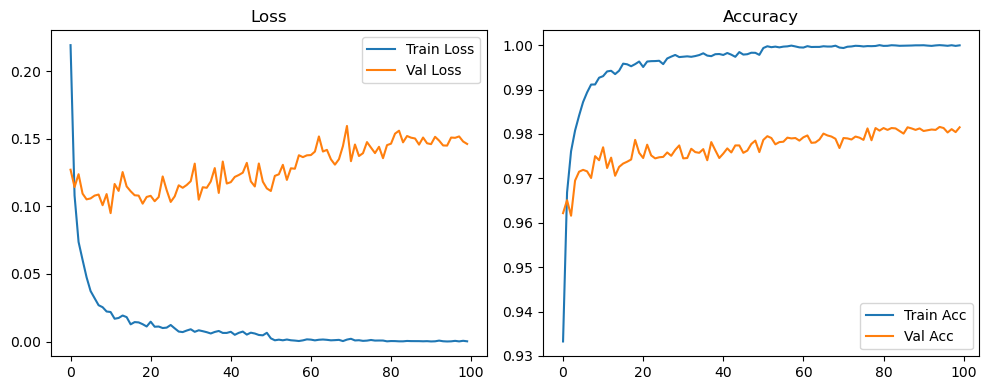

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2729, Acc: 0.9166 | Val Loss: 0.1387, Acc: 0.9587


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1474, Acc: 0.9550 | Val Loss: 0.1144, Acc: 0.9627


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1126, Acc: 0.9655 | Val Loss: 0.1083, Acc: 0.9680


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0905, Acc: 0.9714 | Val Loss: 0.1032, Acc: 0.9697


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9732 | Val Loss: 0.0953, Acc: 0.9717


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9776 | Val Loss: 0.0932, Acc: 0.9727


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9791 | Val Loss: 0.0854, Acc: 0.9765


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9827 | Val Loss: 0.0853, Acc: 0.9756


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9824 | Val Loss: 0.0888, Acc: 0.9757


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0897, Acc: 0.9751


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9851 | Val Loss: 0.0915, Acc: 0.9732


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9866 | Val Loss: 0.0906, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9876 | Val Loss: 0.0897, Acc: 0.9742


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0881, Acc: 0.9763


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1101, Acc: 0.9717


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0890, Acc: 0.9765


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9890 | Val Loss: 0.0922, Acc: 0.9745


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0933, Acc: 0.9757


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0937, Acc: 0.9770


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0917, Acc: 0.9770


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0861, Acc: 0.9782


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0987, Acc: 0.9752


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0848, Acc: 0.9781


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0981, Acc: 0.9762


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0998, Acc: 0.9752


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0953, Acc: 0.9782


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0963, Acc: 0.9769


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0912, Acc: 0.9765


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0975, Acc: 0.9754


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0949, Acc: 0.9772


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9933 | Val Loss: 0.0982, Acc: 0.9767


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1051, Acc: 0.9781


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0968, Acc: 0.9795


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0964, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0974, Acc: 0.9778


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0905, Acc: 0.9791


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0907, Acc: 0.9774


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0904, Acc: 0.9780


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0983, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0883, Acc: 0.9785


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1000, Acc: 0.9765


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0877, Acc: 0.9782


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0996, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1005, Acc: 0.9779


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0967, Acc: 0.9786


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0968, Acc: 0.9788


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0922, Acc: 0.9784


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1008, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0937, Acc: 0.9788


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0949, Acc: 0.9780


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0969, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0967, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1017, Acc: 0.9797


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1004, Acc: 0.9806


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0969, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1031, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1041, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1012, Acc: 0.9805


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0971, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1027, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9785


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1073, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1107, Acc: 0.9794


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1102, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1053, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1054, Acc: 0.9803


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1059, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1065, Acc: 0.9805


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0991, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1000, Acc: 0.9815


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1057, Acc: 0.9796


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1029, Acc: 0.9794


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0997, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1071, Acc: 0.9814


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1113, Acc: 0.9805


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1090, Acc: 0.9809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1097, Acc: 0.9807


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1063, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1130, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1021, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1035, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1055, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1097, Acc: 0.9800


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1114, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1082, Acc: 0.9806


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1129, Acc: 0.9806


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1054, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1121, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1002, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1002, Acc: 0.9816


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1042, Acc: 0.9809


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1107, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1129, Acc: 0.9813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1184, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1155, Acc: 0.9805


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1124, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1145, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1098, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1124, Acc: 0.9809


Final Test Loss: 0.1125 Accuracy: 0.9826


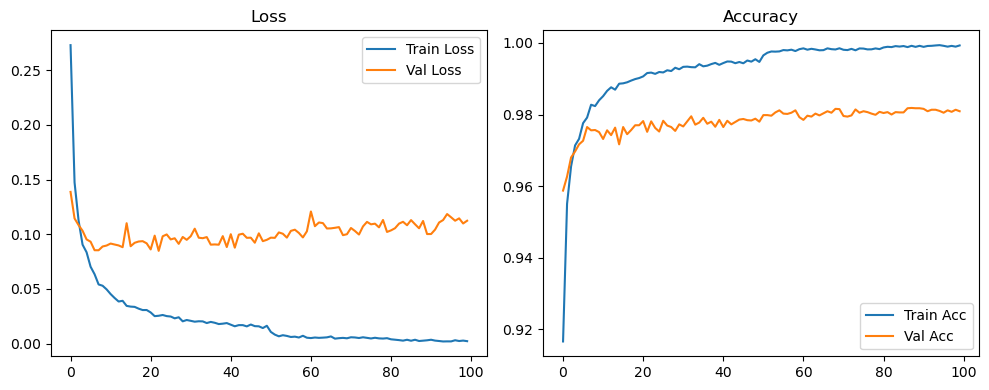

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4327, Acc: 0.8678 | Val Loss: 0.1777, Acc: 0.9452


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2605, Acc: 0.9228 | Val Loss: 0.1380, Acc: 0.9570


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2153, Acc: 0.9364 | Val Loss: 0.1293, Acc: 0.9604


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1873, Acc: 0.9439 | Val Loss: 0.1224, Acc: 0.9634


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1756, Acc: 0.9472 | Val Loss: 0.1130, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1598, Acc: 0.9524 | Val Loss: 0.1048, Acc: 0.9692


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1453, Acc: 0.9562 | Val Loss: 0.1025, Acc: 0.9698


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1434, Acc: 0.9575 | Val Loss: 0.0960, Acc: 0.9723


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1359, Acc: 0.9594 | Val Loss: 0.1059, Acc: 0.9695


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1330, Acc: 0.9600 | Val Loss: 0.1000, Acc: 0.9718


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1261, Acc: 0.9616 | Val Loss: 0.0964, Acc: 0.9724


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1192, Acc: 0.9644 | Val Loss: 0.0960, Acc: 0.9730


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1119, Acc: 0.9657 | Val Loss: 0.0948, Acc: 0.9734


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1125, Acc: 0.9657 | Val Loss: 0.0940, Acc: 0.9741


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.1077, Acc: 0.9673 | Val Loss: 0.0950, Acc: 0.9723


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.1053, Acc: 0.9680 | Val Loss: 0.0927, Acc: 0.9738


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9689 | Val Loss: 0.0930, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9699 | Val Loss: 0.0901, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.1018, Acc: 0.9689 | Val Loss: 0.0903, Acc: 0.9743


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9718 | Val Loss: 0.0942, Acc: 0.9745


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0966, Acc: 0.9706 | Val Loss: 0.0933, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0906, Acc: 0.9715 | Val Loss: 0.0920, Acc: 0.9752


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0917, Acc: 0.9719 | Val Loss: 0.0874, Acc: 0.9758


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9722 | Val Loss: 0.0948, Acc: 0.9735


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0881, Acc: 0.9731 | Val Loss: 0.0949, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9733 | Val Loss: 0.0850, Acc: 0.9764


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0832, Acc: 0.9742 | Val Loss: 0.0961, Acc: 0.9749


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9725 | Val Loss: 0.0860, Acc: 0.9762


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0825, Acc: 0.9742 | Val Loss: 0.0871, Acc: 0.9750


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0837, Acc: 0.9740 | Val Loss: 0.0880, Acc: 0.9755


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0809, Acc: 0.9749 | Val Loss: 0.0913, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9755 | Val Loss: 0.0896, Acc: 0.9753


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9757 | Val Loss: 0.0877, Acc: 0.9761


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0744, Acc: 0.9769 | Val Loss: 0.0916, Acc: 0.9754


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0745, Acc: 0.9770 | Val Loss: 0.0957, Acc: 0.9757


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0711, Acc: 0.9772 | Val Loss: 0.0927, Acc: 0.9754


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0737, Acc: 0.9770 | Val Loss: 0.0872, Acc: 0.9749


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0740, Acc: 0.9770 | Val Loss: 0.0896, Acc: 0.9769


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0674, Acc: 0.9790 | Val Loss: 0.0911, Acc: 0.9768


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9790 | Val Loss: 0.0882, Acc: 0.9753


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0703, Acc: 0.9782 | Val Loss: 0.0948, Acc: 0.9751


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9794 | Val Loss: 0.0898, Acc: 0.9772


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0659, Acc: 0.9794 | Val Loss: 0.0905, Acc: 0.9745


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.0930, Acc: 0.9770


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0682, Acc: 0.9787 | Val Loss: 0.0908, Acc: 0.9755


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9787 | Val Loss: 0.0886, Acc: 0.9767


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0663, Acc: 0.9799 | Val Loss: 0.0883, Acc: 0.9765


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9811 | Val Loss: 0.0913, Acc: 0.9765


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9802 | Val Loss: 0.0917, Acc: 0.9757


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0621, Acc: 0.9804 | Val Loss: 0.0997, Acc: 0.9757


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9821 | Val Loss: 0.0899, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9847 | Val Loss: 0.0917, Acc: 0.9770


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9848 | Val Loss: 0.0916, Acc: 0.9772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9857 | Val Loss: 0.0953, Acc: 0.9767


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9860 | Val Loss: 0.0962, Acc: 0.9768


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9859 | Val Loss: 0.0924, Acc: 0.9781


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0877, Acc: 0.9783


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.1037, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9868 | Val Loss: 0.0929, Acc: 0.9771


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9872 | Val Loss: 0.0922, Acc: 0.9777


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0951, Acc: 0.9773


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0954, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9883 | Val Loss: 0.0947, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9882 | Val Loss: 0.0957, Acc: 0.9779


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0971, Acc: 0.9767


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9874 | Val Loss: 0.0898, Acc: 0.9780


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9872 | Val Loss: 0.0964, Acc: 0.9776


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9883 | Val Loss: 0.0984, Acc: 0.9774


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0912, Acc: 0.9790


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.0946, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.0996, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.1059, Acc: 0.9777


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9878 | Val Loss: 0.0914, Acc: 0.9777


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.0879, Acc: 0.9789


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9893 | Val Loss: 0.0933, Acc: 0.9785


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9894 | Val Loss: 0.0886, Acc: 0.9780


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9886 | Val Loss: 0.0931, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0972, Acc: 0.9777


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9894 | Val Loss: 0.0967, Acc: 0.9787


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0340, Acc: 0.9893 | Val Loss: 0.0959, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0963, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0975, Acc: 0.9782


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.1018, Acc: 0.9786


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.0964, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.0985, Acc: 0.9784


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.1002, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0988, Acc: 0.9776


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9909 | Val Loss: 0.1001, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9912 | Val Loss: 0.0984, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9903 | Val Loss: 0.0958, Acc: 0.9786


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.1010, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.1006, Acc: 0.9772


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9911 | Val Loss: 0.1018, Acc: 0.9774


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9913 | Val Loss: 0.1004, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1005, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1020, Acc: 0.9776


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.1011, Acc: 0.9774


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0994, Acc: 0.9779


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.1042, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0961, Acc: 0.9787


Final Test Loss: 0.0925 Accuracy: 0.9811


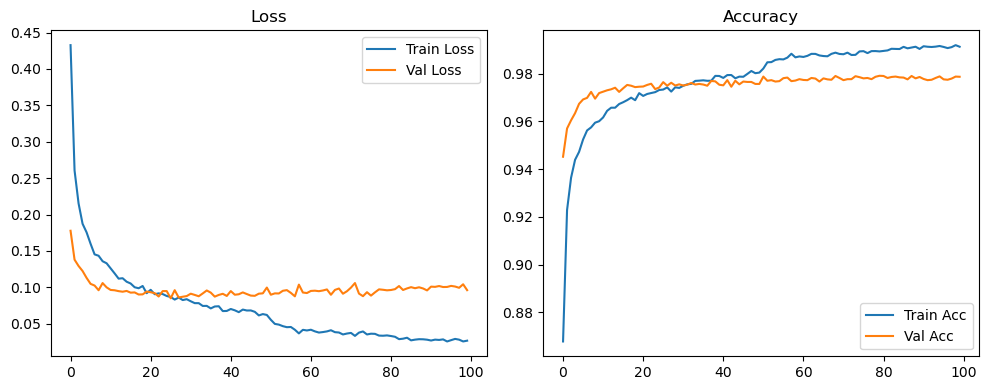

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2165, Acc: 0.9338 | Val Loss: 0.1187, Acc: 0.9619


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0985, Acc: 0.9690 | Val Loss: 0.1101, Acc: 0.9652


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.1090, Acc: 0.9651


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0970, Acc: 0.9721


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.1059, Acc: 0.9709


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 0.1040, Acc: 0.9716


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.1059, Acc: 0.9715


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.1075, Acc: 0.9714


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.1224, Acc: 0.9687


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.1264, Acc: 0.9701


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1080, Acc: 0.9706


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1124, Acc: 0.9728


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1138, Acc: 0.9752


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.1166, Acc: 0.9754


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1122, Acc: 0.9758


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1260, Acc: 0.9730


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.1171, Acc: 0.9755


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1173, Acc: 0.9742


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1226, Acc: 0.9742


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1091, Acc: 0.9748


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1058, Acc: 0.9773


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1016, Acc: 0.9778


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1214, Acc: 0.9734


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1207, Acc: 0.9749


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1276, Acc: 0.9742


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1104, Acc: 0.9767


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1234, Acc: 0.9755


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1147, Acc: 0.9766


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1221, Acc: 0.9754


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1326, Acc: 0.9742


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1287, Acc: 0.9758


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1205, Acc: 0.9762


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1247, Acc: 0.9760


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1177, Acc: 0.9773


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.1259, Acc: 0.9768


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1210, Acc: 0.9756


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1264, Acc: 0.9767


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1203, Acc: 0.9767


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1209, Acc: 0.9761


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1208, Acc: 0.9775


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1209, Acc: 0.9771


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1195, Acc: 0.9782


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1244, Acc: 0.9772


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1186, Acc: 0.9764


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1315, Acc: 0.9773


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1222, Acc: 0.9783


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1408, Acc: 0.9752


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9757


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1206, Acc: 0.9776


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1274, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1333, Acc: 0.9763


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1311, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1256, Acc: 0.9774


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1349, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1209, Acc: 0.9758


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1133, Acc: 0.9792


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1209, Acc: 0.9779


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1416, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1265, Acc: 0.9770


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1179, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1318, Acc: 0.9772


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1239, Acc: 0.9776


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1312, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1286, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1380, Acc: 0.9768


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1402, Acc: 0.9761


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1269, Acc: 0.9771


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1201, Acc: 0.9785


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1362, Acc: 0.9770


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1460, Acc: 0.9746


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1377, Acc: 0.9766


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1316, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1389, Acc: 0.9780


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1370, Acc: 0.9760


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1314, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1355, Acc: 0.9787


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1331, Acc: 0.9780


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1389, Acc: 0.9784


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1422, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1282, Acc: 0.9772


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1295, Acc: 0.9782


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1396, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1344, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1160, Acc: 0.9796


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1289, Acc: 0.9782


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1230, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1142, Acc: 0.9803


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1213, Acc: 0.9792


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1258, Acc: 0.9779


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1087, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1214, Acc: 0.9784


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1209, Acc: 0.9793


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1204, Acc: 0.9792


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1078, Acc: 0.9779


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1082, Acc: 0.9782


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1139, Acc: 0.9800


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1258, Acc: 0.9778


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1342, Acc: 0.9784


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1293, Acc: 0.9781


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1140, Acc: 0.9795


Final Test Loss: 0.1121 Accuracy: 0.9798


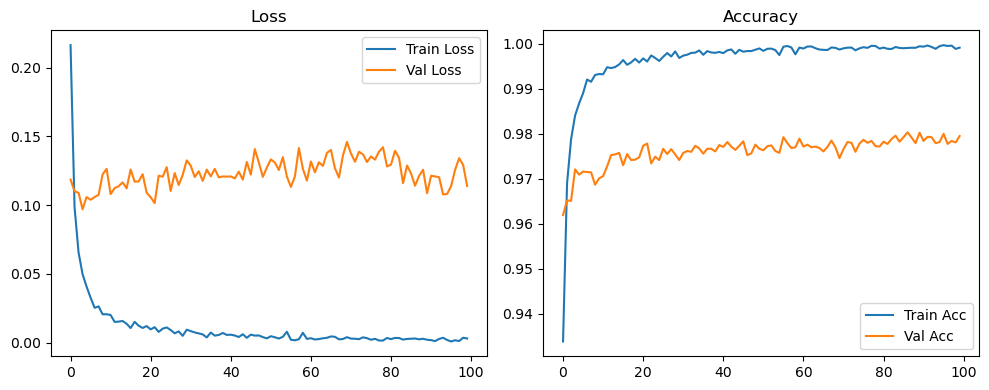

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2809, Acc: 0.9147 | Val Loss: 0.1312, Acc: 0.9596


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1420, Acc: 0.9557 | Val Loss: 0.1095, Acc: 0.9639


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1096, Acc: 0.9644 | Val Loss: 0.1038, Acc: 0.9682


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0890, Acc: 0.9723 | Val Loss: 0.0959, Acc: 0.9715


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0782, Acc: 0.9749 | Val Loss: 0.0932, Acc: 0.9731


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9777 | Val Loss: 0.0954, Acc: 0.9722


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9811 | Val Loss: 0.0887, Acc: 0.9750


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9834 | Val Loss: 0.0829, Acc: 0.9759


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9841 | Val Loss: 0.0913, Acc: 0.9741


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0487, Acc: 0.9839 | Val Loss: 0.0951, Acc: 0.9736


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9859 | Val Loss: 0.0907, Acc: 0.9763


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9871 | Val Loss: 0.0864, Acc: 0.9762


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9871 | Val Loss: 0.0973, Acc: 0.9732


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9886 | Val Loss: 0.0920, Acc: 0.9762


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9887 | Val Loss: 0.1034, Acc: 0.9738


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0895, Acc: 0.9765


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0932, Acc: 0.9753


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9896 | Val Loss: 0.0922, Acc: 0.9769


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.0933, Acc: 0.9773


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0907, Acc: 0.9774


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0951, Acc: 0.9765


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0950, Acc: 0.9775


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0916, Acc: 0.9761


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.0936, Acc: 0.9766


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0901, Acc: 0.9784


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0937, Acc: 0.9763


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0929, Acc: 0.9778


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0948, Acc: 0.9779


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.0867, Acc: 0.9791


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0966, Acc: 0.9780


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0949, Acc: 0.9783


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0930, Acc: 0.9789


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1002, Acc: 0.9783


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0999, Acc: 0.9773


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1002, Acc: 0.9781


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0925, Acc: 0.9790


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0967, Acc: 0.9789


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0952, Acc: 0.9782


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1012, Acc: 0.9781


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0958, Acc: 0.9778


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0938, Acc: 0.9777


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0982, Acc: 0.9778


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0985, Acc: 0.9782


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9778


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.1059, Acc: 0.9776


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0966, Acc: 0.9780


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1027, Acc: 0.9780


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1024, Acc: 0.9782


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.1023, Acc: 0.9774


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1027, Acc: 0.9787


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0967, Acc: 0.9787


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1065, Acc: 0.9765


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0956, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1075, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1031, Acc: 0.9780


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0987, Acc: 0.9783


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1004, Acc: 0.9793


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0938, Acc: 0.9795


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1021, Acc: 0.9785


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1028, Acc: 0.9783


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1031, Acc: 0.9783


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1031, Acc: 0.9792


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1092, Acc: 0.9783


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0957, Acc: 0.9790


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1053, Acc: 0.9788


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.1006, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1023, Acc: 0.9802


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0942, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1003, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0978, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1071, Acc: 0.9779


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0985, Acc: 0.9786


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0904, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9807


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0998, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1047, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1069, Acc: 0.9797


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1038, Acc: 0.9786


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1030, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1004, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0970, Acc: 0.9795


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1007, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1048, Acc: 0.9786


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1018, Acc: 0.9789


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1041, Acc: 0.9796


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.1008, Acc: 0.9794


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0978, Acc: 0.9796


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1018, Acc: 0.9795


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0985, Acc: 0.9803


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9791


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1060, Acc: 0.9791


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1120, Acc: 0.9775


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1039, Acc: 0.9791


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.1108, Acc: 0.9783


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1077, Acc: 0.9784


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1084, Acc: 0.9798


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1082, Acc: 0.9792


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1048, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0959, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1023, Acc: 0.9807


Final Test Loss: 0.0891 Accuracy: 0.9815


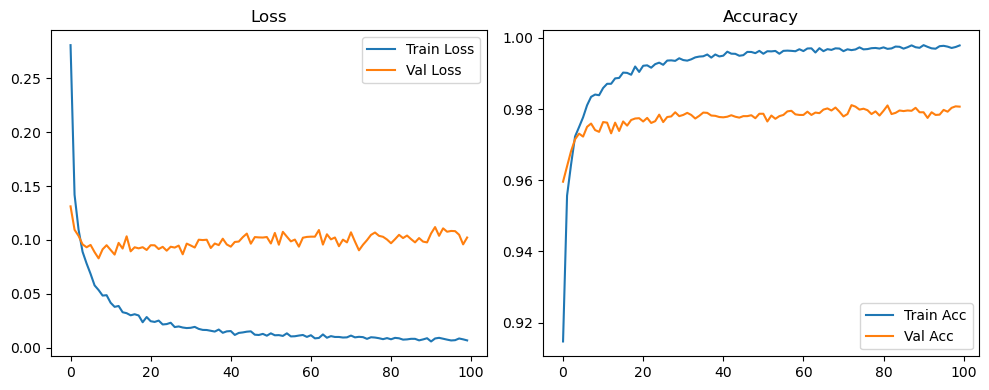

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4651, Acc: 0.8579 | Val Loss: 0.1846, Acc: 0.9443


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2634, Acc: 0.9215 | Val Loss: 0.1500, Acc: 0.9532


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2209, Acc: 0.9329 | Val Loss: 0.1346, Acc: 0.9589


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1943, Acc: 0.9413 | Val Loss: 0.1243, Acc: 0.9625


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1739, Acc: 0.9464 | Val Loss: 0.1089, Acc: 0.9666


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1614, Acc: 0.9514 | Val Loss: 0.1059, Acc: 0.9683


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1478, Acc: 0.9557 | Val Loss: 0.1027, Acc: 0.9696


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1383, Acc: 0.9587 | Val Loss: 0.0977, Acc: 0.9698


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1304, Acc: 0.9596 | Val Loss: 0.1006, Acc: 0.9708


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1303, Acc: 0.9601 | Val Loss: 0.1035, Acc: 0.9715


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1229, Acc: 0.9630 | Val Loss: 0.0926, Acc: 0.9732


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1108, Acc: 0.9655 | Val Loss: 0.0894, Acc: 0.9728


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1094, Acc: 0.9662 | Val Loss: 0.0891, Acc: 0.9739


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1075, Acc: 0.9666 | Val Loss: 0.0915, Acc: 0.9736


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1015, Acc: 0.9681 | Val Loss: 0.0928, Acc: 0.9733


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0979, Acc: 0.9699 | Val Loss: 0.0873, Acc: 0.9745


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0956, Acc: 0.9695 | Val Loss: 0.0870, Acc: 0.9746


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0966, Acc: 0.9695 | Val Loss: 0.0874, Acc: 0.9743


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0917, Acc: 0.9706 | Val Loss: 0.0861, Acc: 0.9751


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9729 | Val Loss: 0.0933, Acc: 0.9749


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9732 | Val Loss: 0.0858, Acc: 0.9760


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0854, Acc: 0.9730 | Val Loss: 0.0913, Acc: 0.9744


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9747 | Val Loss: 0.0917, Acc: 0.9748


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9750 | Val Loss: 0.0925, Acc: 0.9746


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9760 | Val Loss: 0.0903, Acc: 0.9752


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0783, Acc: 0.9760 | Val Loss: 0.0841, Acc: 0.9760


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0761, Acc: 0.9756 | Val Loss: 0.0890, Acc: 0.9768


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9763 | Val Loss: 0.0871, Acc: 0.9759


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0730, Acc: 0.9764 | Val Loss: 0.0882, Acc: 0.9761


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0690, Acc: 0.9781 | Val Loss: 0.0933, Acc: 0.9761


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9779 | Val Loss: 0.0910, Acc: 0.9758


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0672, Acc: 0.9783 | Val Loss: 0.0921, Acc: 0.9757


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9803 | Val Loss: 0.0907, Acc: 0.9752


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9780 | Val Loss: 0.0900, Acc: 0.9764


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9794 | Val Loss: 0.0928, Acc: 0.9753


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9798 | Val Loss: 0.0931, Acc: 0.9757


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0652, Acc: 0.9797 | Val Loss: 0.0891, Acc: 0.9774


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9804 | Val Loss: 0.0880, Acc: 0.9763


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9805 | Val Loss: 0.0871, Acc: 0.9763


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0614, Acc: 0.9806 | Val Loss: 0.0869, Acc: 0.9780


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9806 | Val Loss: 0.0862, Acc: 0.9782


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9818 | Val Loss: 0.0892, Acc: 0.9770


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9821 | Val Loss: 0.0911, Acc: 0.9765


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9825 | Val Loss: 0.0884, Acc: 0.9775


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0570, Acc: 0.9816 | Val Loss: 0.0931, Acc: 0.9758


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9829 | Val Loss: 0.0890, Acc: 0.9761


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9823 | Val Loss: 0.0924, Acc: 0.9777


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0550, Acc: 0.9818 | Val Loss: 0.0914, Acc: 0.9767


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9823 | Val Loss: 0.0905, Acc: 0.9765


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9825 | Val Loss: 0.0906, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9825 | Val Loss: 0.0917, Acc: 0.9766


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9836 | Val Loss: 0.0903, Acc: 0.9776


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0531, Acc: 0.9831 | Val Loss: 0.0892, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9827 | Val Loss: 0.0938, Acc: 0.9760


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0518, Acc: 0.9834 | Val Loss: 0.0899, Acc: 0.9764


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9846 | Val Loss: 0.0891, Acc: 0.9775


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9846 | Val Loss: 0.0902, Acc: 0.9781


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0481, Acc: 0.9850 | Val Loss: 0.0922, Acc: 0.9768


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.0929, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0490, Acc: 0.9845 | Val Loss: 0.0883, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 0.0939, Acc: 0.9757


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9845 | Val Loss: 0.0932, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9859 | Val Loss: 0.0928, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.0965, Acc: 0.9761


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0485, Acc: 0.9847 | Val Loss: 0.0966, Acc: 0.9778


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9848 | Val Loss: 0.0920, Acc: 0.9765


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.1001, Acc: 0.9765


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9856 | Val Loss: 0.0938, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.0974, Acc: 0.9782


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9851 | Val Loss: 0.0957, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 0.0955, Acc: 0.9773


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9865 | Val Loss: 0.0979, Acc: 0.9773


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9860 | Val Loss: 0.0933, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9856 | Val Loss: 0.0956, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9864 | Val Loss: 0.0931, Acc: 0.9777


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9857 | Val Loss: 0.0946, Acc: 0.9764


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9858 | Val Loss: 0.0945, Acc: 0.9770


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.0994, Acc: 0.9771


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 0.1020, Acc: 0.9759


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0986, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9856 | Val Loss: 0.0980, Acc: 0.9766


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.1016, Acc: 0.9763


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.0947, Acc: 0.9763


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9874 | Val Loss: 0.0961, Acc: 0.9783


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.1000, Acc: 0.9772


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0996, Acc: 0.9762


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9870 | Val Loss: 0.0935, Acc: 0.9779


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0411, Acc: 0.9866 | Val Loss: 0.0975, Acc: 0.9778


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9874 | Val Loss: 0.0944, Acc: 0.9763


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9871 | Val Loss: 0.0989, Acc: 0.9768


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9873 | Val Loss: 0.1036, Acc: 0.9762


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.0974, Acc: 0.9776


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 0.0947, Acc: 0.9775


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9870 | Val Loss: 0.0953, Acc: 0.9776


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.0940, Acc: 0.9779


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0990, Acc: 0.9759


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9881 | Val Loss: 0.1015, Acc: 0.9754


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0959, Acc: 0.9771


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9881 | Val Loss: 0.0976, Acc: 0.9768


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9883 | Val Loss: 0.0953, Acc: 0.9771


Final Test Loss: 0.0849 Accuracy: 0.9798


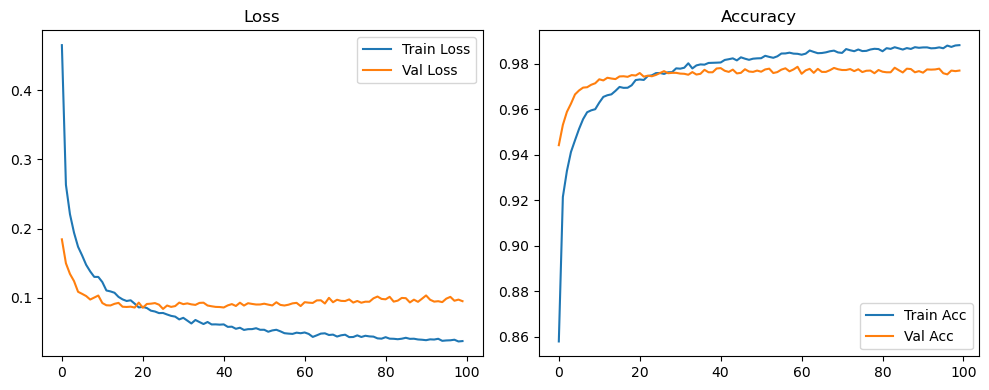

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2318, Acc: 0.9326 | Val Loss: 0.1243, Acc: 0.9625


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0927, Acc: 0.9712 | Val Loss: 0.1058, Acc: 0.9640


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9806 | Val Loss: 0.1030, Acc: 0.9681


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 0.0996, Acc: 0.9698


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0370, Acc: 0.9875 | Val Loss: 0.0910, Acc: 0.9738


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.1044, Acc: 0.9706


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0989, Acc: 0.9730


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0932, Acc: 0.9738


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1089, Acc: 0.9734


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.1095, Acc: 0.9722


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0926, Acc: 0.9752


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1023, Acc: 0.9751


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1005, Acc: 0.9755


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1097, Acc: 0.9752


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.1215, Acc: 0.9728


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1142, Acc: 0.9737


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1064, Acc: 0.9758


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1217, Acc: 0.9742


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1089, Acc: 0.9764


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1160, Acc: 0.9738


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1097, Acc: 0.9764


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1095, Acc: 0.9770


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1176, Acc: 0.9737


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1177, Acc: 0.9742


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1071, Acc: 0.9762


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1021, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1152, Acc: 0.9749


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1140, Acc: 0.9772


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1274, Acc: 0.9740


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1228, Acc: 0.9743


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1268, Acc: 0.9738


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1151, Acc: 0.9752


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1164, Acc: 0.9769


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1071, Acc: 0.9777


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1087, Acc: 0.9785


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1219, Acc: 0.9744


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1214, Acc: 0.9742


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1106, Acc: 0.9774


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1265, Acc: 0.9750


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1094, Acc: 0.9767


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1093, Acc: 0.9782


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1160, Acc: 0.9778


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1231, Acc: 0.9748


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1104, Acc: 0.9774


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1328, Acc: 0.9748


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1205, Acc: 0.9771


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1165, Acc: 0.9785


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1194, Acc: 0.9773


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1211, Acc: 0.9780


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1199, Acc: 0.9772


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1173, Acc: 0.9769


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1090, Acc: 0.9794


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1237, Acc: 0.9770


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1174, Acc: 0.9771


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1317, Acc: 0.9762


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1232, Acc: 0.9782


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1189, Acc: 0.9778


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1167, Acc: 0.9787


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1129, Acc: 0.9785


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9788


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1285, Acc: 0.9774


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1253, Acc: 0.9777


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1263, Acc: 0.9771


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1232, Acc: 0.9783


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1282, Acc: 0.9774


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1261, Acc: 0.9768


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1176, Acc: 0.9791


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1307, Acc: 0.9767


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1325, Acc: 0.9764


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1391, Acc: 0.9770


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1165, Acc: 0.9786


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1331, Acc: 0.9767


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1270, Acc: 0.9779


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1272, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1190, Acc: 0.9788


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1155, Acc: 0.9792


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1187, Acc: 0.9778


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1243, Acc: 0.9786


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1343, Acc: 0.9752


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1401, Acc: 0.9767


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1292, Acc: 0.9781


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1284, Acc: 0.9778


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1319, Acc: 0.9773


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1202, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1285, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1266, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1324, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1383, Acc: 0.9779


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1474, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1317, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1246, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1264, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1416, Acc: 0.9776


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1300, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1324, Acc: 0.9782


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1271, Acc: 0.9795


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1221, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1276, Acc: 0.9775


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1280, Acc: 0.9778


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1361, Acc: 0.9773


Final Test Loss: 0.1309 Accuracy: 0.9791


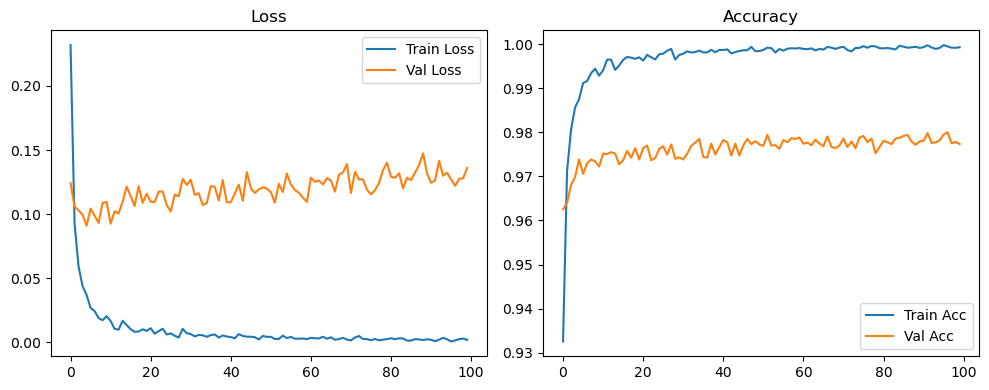

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3117, Acc: 0.9098 | Val Loss: 0.1369, Acc: 0.9567


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1451, Acc: 0.9549 | Val Loss: 0.1128, Acc: 0.9638


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1130, Acc: 0.9648 | Val Loss: 0.1135, Acc: 0.9651


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0902, Acc: 0.9715 | Val Loss: 0.0953, Acc: 0.9699


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0795, Acc: 0.9743 | Val Loss: 0.0948, Acc: 0.9712


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0654, Acc: 0.9792 | Val Loss: 0.0960, Acc: 0.9716


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0598, Acc: 0.9804 | Val Loss: 0.0917, Acc: 0.9735


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9838 | Val Loss: 0.0879, Acc: 0.9738


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9834 | Val Loss: 0.0942, Acc: 0.9727


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9840 | Val Loss: 0.0944, Acc: 0.9738


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9864 | Val Loss: 0.0941, Acc: 0.9748


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9875 | Val Loss: 0.0938, Acc: 0.9752


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9878 | Val Loss: 0.0879, Acc: 0.9762


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9880 | Val Loss: 0.0908, Acc: 0.9751


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0983, Acc: 0.9738


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.0911, Acc: 0.9758


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0926, Acc: 0.9750


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9907 | Val Loss: 0.0953, Acc: 0.9750


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0934, Acc: 0.9766


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9914 | Val Loss: 0.0928, Acc: 0.9762


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9912 | Val Loss: 0.0948, Acc: 0.9759


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9915 | Val Loss: 0.0960, Acc: 0.9753


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9925 | Val Loss: 0.0928, Acc: 0.9763


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0993, Acc: 0.9763


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0943, Acc: 0.9772


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0885, Acc: 0.9774


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0923, Acc: 0.9767


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0942, Acc: 0.9770


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0977, Acc: 0.9772


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0970, Acc: 0.9776


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0985, Acc: 0.9776


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9938 | Val Loss: 0.0958, Acc: 0.9776


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9935 | Val Loss: 0.0964, Acc: 0.9784


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0955, Acc: 0.9781


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0946, Acc: 0.9778


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1020, Acc: 0.9769


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1003, Acc: 0.9758


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0940, Acc: 0.9772


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0963, Acc: 0.9783


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.0964, Acc: 0.9799


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1005, Acc: 0.9769


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0997, Acc: 0.9769


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0987, Acc: 0.9798


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1061, Acc: 0.9778


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1052, Acc: 0.9773


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1042, Acc: 0.9784


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0969, Acc: 0.9787


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1030, Acc: 0.9782


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1008, Acc: 0.9781


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1026, Acc: 0.9775


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0925, Acc: 0.9793


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1025, Acc: 0.9778


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1024, Acc: 0.9786


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.1021, Acc: 0.9778


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0974, Acc: 0.9788


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1006, Acc: 0.9785


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1165, Acc: 0.9778


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1060, Acc: 0.9775


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1040, Acc: 0.9798


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1021, Acc: 0.9787


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1001, Acc: 0.9795


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1055, Acc: 0.9783


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1032, Acc: 0.9780


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1036, Acc: 0.9785


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1049, Acc: 0.9787


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1039, Acc: 0.9781


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1063, Acc: 0.9784


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.1081, Acc: 0.9774


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1043, Acc: 0.9792


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1041, Acc: 0.9786


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1002, Acc: 0.9803


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1080, Acc: 0.9795


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1014, Acc: 0.9788


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1003, Acc: 0.9789


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0976, Acc: 0.9798


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0988, Acc: 0.9794


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1042, Acc: 0.9792


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1105, Acc: 0.9781


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1038, Acc: 0.9791


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1071, Acc: 0.9789


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1100, Acc: 0.9780


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1039, Acc: 0.9791


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.1014, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1114, Acc: 0.9783


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1178, Acc: 0.9762


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1078, Acc: 0.9779


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1096, Acc: 0.9774


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1056, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1092, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1102, Acc: 0.9773


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1102, Acc: 0.9787


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1097, Acc: 0.9769


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1119, Acc: 0.9779


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1048, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1130, Acc: 0.9777


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1065, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1025, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1095, Acc: 0.9787


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1012, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1031, Acc: 0.9807


Final Test Loss: 0.1009 Accuracy: 0.9811


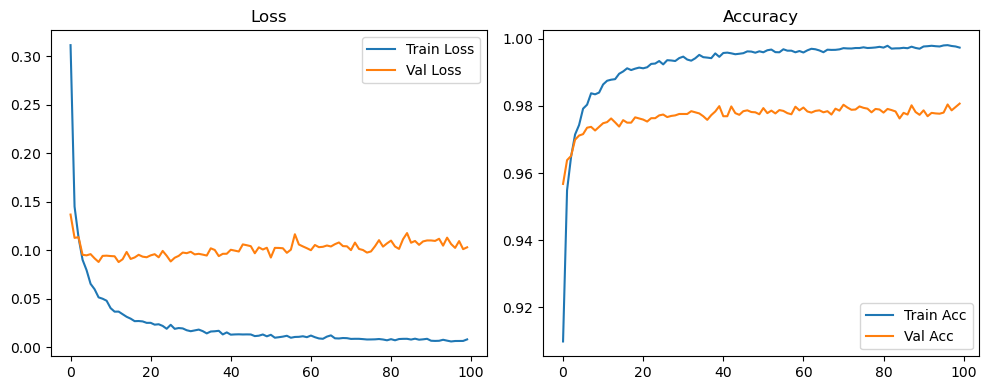

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5441, Acc: 0.8344 | Val Loss: 0.1995, Acc: 0.9396


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2839, Acc: 0.9148 | Val Loss: 0.1624, Acc: 0.9505


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2295, Acc: 0.9324 | Val Loss: 0.1387, Acc: 0.9576


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2045, Acc: 0.9378 | Val Loss: 0.1275, Acc: 0.9611


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1827, Acc: 0.9437 | Val Loss: 0.1135, Acc: 0.9651


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1646, Acc: 0.9496 | Val Loss: 0.1109, Acc: 0.9666


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1568, Acc: 0.9521 | Val Loss: 0.1073, Acc: 0.9676


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1411, Acc: 0.9572 | Val Loss: 0.1044, Acc: 0.9682


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1377, Acc: 0.9577 | Val Loss: 0.1002, Acc: 0.9702


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1346, Acc: 0.9585 | Val Loss: 0.0965, Acc: 0.9708


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1288, Acc: 0.9601 | Val Loss: 0.0949, Acc: 0.9728


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1157, Acc: 0.9643 | Val Loss: 0.0950, Acc: 0.9720


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1128, Acc: 0.9652 | Val Loss: 0.0952, Acc: 0.9727


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1069, Acc: 0.9667 | Val Loss: 0.0951, Acc: 0.9720


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1023, Acc: 0.9684 | Val Loss: 0.0927, Acc: 0.9737


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0985, Acc: 0.9691 | Val Loss: 0.0928, Acc: 0.9721


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0966, Acc: 0.9698 | Val Loss: 0.0919, Acc: 0.9730


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0921, Acc: 0.9717 | Val Loss: 0.0929, Acc: 0.9738


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0921, Acc: 0.9706 | Val Loss: 0.0909, Acc: 0.9732


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0905, Acc: 0.9715 | Val Loss: 0.0873, Acc: 0.9742


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0882, Acc: 0.9725 | Val Loss: 0.0871, Acc: 0.9733


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9730 | Val Loss: 0.0924, Acc: 0.9733


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0869, Acc: 0.9739 | Val Loss: 0.0856, Acc: 0.9748


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9746 | Val Loss: 0.0884, Acc: 0.9754


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0805, Acc: 0.9745 | Val Loss: 0.0889, Acc: 0.9754


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0768, Acc: 0.9751 | Val Loss: 0.0883, Acc: 0.9751


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0744, Acc: 0.9764 | Val Loss: 0.0895, Acc: 0.9757


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9778 | Val Loss: 0.0877, Acc: 0.9760


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0739, Acc: 0.9765 | Val Loss: 0.0864, Acc: 0.9760


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0690, Acc: 0.9777 | Val Loss: 0.0882, Acc: 0.9751


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0707, Acc: 0.9775 | Val Loss: 0.0865, Acc: 0.9761


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0671, Acc: 0.9786 | Val Loss: 0.0876, Acc: 0.9762


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0660, Acc: 0.9788 | Val Loss: 0.0884, Acc: 0.9749


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0673, Acc: 0.9790 | Val Loss: 0.0888, Acc: 0.9758


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0630, Acc: 0.9800 | Val Loss: 0.0903, Acc: 0.9762


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9795 | Val Loss: 0.0882, Acc: 0.9763


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9806 | Val Loss: 0.0890, Acc: 0.9765


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9797 | Val Loss: 0.0865, Acc: 0.9768


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0578, Acc: 0.9810 | Val Loss: 0.0929, Acc: 0.9759


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9806 | Val Loss: 0.0935, Acc: 0.9758


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0564, Acc: 0.9818 | Val Loss: 0.0911, Acc: 0.9772


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9809 | Val Loss: 0.0933, Acc: 0.9762


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0565, Acc: 0.9814 | Val Loss: 0.0966, Acc: 0.9758


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0583, Acc: 0.9816 | Val Loss: 0.0967, Acc: 0.9756


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9828 | Val Loss: 0.0888, Acc: 0.9767


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9813 | Val Loss: 0.0904, Acc: 0.9767


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9829 | Val Loss: 0.0873, Acc: 0.9775


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9827 | Val Loss: 0.0942, Acc: 0.9763


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9829 | Val Loss: 0.0890, Acc: 0.9763


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.0940, Acc: 0.9766


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9830 | Val Loss: 0.0902, Acc: 0.9766


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.0924, Acc: 0.9758


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9830 | Val Loss: 0.0945, Acc: 0.9753


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9837 | Val Loss: 0.0964, Acc: 0.9753


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9843 | Val Loss: 0.0918, Acc: 0.9760


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0953, Acc: 0.9764


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9841 | Val Loss: 0.0957, Acc: 0.9764


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 0.0954, Acc: 0.9767


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9851 | Val Loss: 0.0983, Acc: 0.9758


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9854 | Val Loss: 0.0948, Acc: 0.9758


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.0980, Acc: 0.9758


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9850 | Val Loss: 0.0984, Acc: 0.9765


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9853 | Val Loss: 0.0940, Acc: 0.9773


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9856 | Val Loss: 0.0950, Acc: 0.9762


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9849 | Val Loss: 0.0958, Acc: 0.9764


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9844 | Val Loss: 0.0942, Acc: 0.9758


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0443, Acc: 0.9859 | Val Loss: 0.0915, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9857 | Val Loss: 0.0923, Acc: 0.9772


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0964, Acc: 0.9761


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.0937, Acc: 0.9764


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0419, Acc: 0.9866 | Val Loss: 0.0955, Acc: 0.9770


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9857 | Val Loss: 0.0998, Acc: 0.9766


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.0941, Acc: 0.9780


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 0.0963, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9873 | Val Loss: 0.0968, Acc: 0.9749


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 0.0956, Acc: 0.9772


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.0979, Acc: 0.9758


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9872 | Val Loss: 0.0993, Acc: 0.9762


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9871 | Val Loss: 0.0950, Acc: 0.9771


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9868 | Val Loss: 0.0916, Acc: 0.9777


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.0928, Acc: 0.9764


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.0953, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9873 | Val Loss: 0.0945, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.0966, Acc: 0.9770


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9877 | Val Loss: 0.0949, Acc: 0.9770


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0945, Acc: 0.9768


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9867 | Val Loss: 0.0946, Acc: 0.9771


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9870 | Val Loss: 0.0992, Acc: 0.9771


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.1008, Acc: 0.9758


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0954, Acc: 0.9772


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9874 | Val Loss: 0.0995, Acc: 0.9762


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 0.0958, Acc: 0.9763


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0973, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0967, Acc: 0.9768


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9879 | Val Loss: 0.0937, Acc: 0.9768


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9878 | Val Loss: 0.0934, Acc: 0.9772


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.0981, Acc: 0.9771


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9884 | Val Loss: 0.0938, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9889 | Val Loss: 0.0954, Acc: 0.9780


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0940, Acc: 0.9767


Final Test Loss: 0.0872 Accuracy: 0.9798


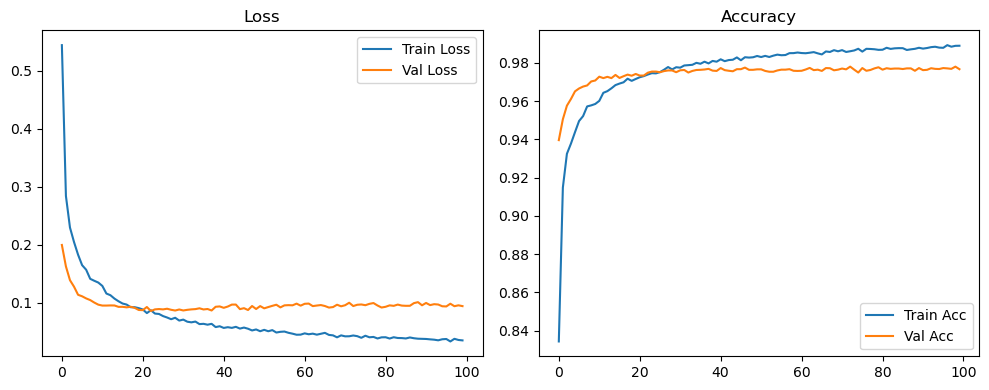

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2241, Acc: 0.9298 | Val Loss: 0.1425, Acc: 0.9563


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1040, Acc: 0.9678 | Val Loss: 0.1282, Acc: 0.9609


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9767 | Val Loss: 0.1191, Acc: 0.9663


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9823 | Val Loss: 0.1121, Acc: 0.9681


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9857 | Val Loss: 0.1207, Acc: 0.9687


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.1263, Acc: 0.9663


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9904 | Val Loss: 0.1165, Acc: 0.9722


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.1018, Acc: 0.9744


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.1112, Acc: 0.9723


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.1348, Acc: 0.9707


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1067, Acc: 0.9744


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1135, Acc: 0.9725


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.1227, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1370, Acc: 0.9717


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1134, Acc: 0.9752


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1229, Acc: 0.9760


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1072, Acc: 0.9738


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1060, Acc: 0.9756


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1228, Acc: 0.9738


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1193, Acc: 0.9764


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1299, Acc: 0.9722


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1196, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1240, Acc: 0.9743


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1199, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1299, Acc: 0.9718


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1186, Acc: 0.9714


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1297, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1209, Acc: 0.9764


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1200, Acc: 0.9735


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1218, Acc: 0.9722


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1321, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1063, Acc: 0.9759


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1312, Acc: 0.9724


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1158, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1166, Acc: 0.9761


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1127, Acc: 0.9773


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1310, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1221, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1375, Acc: 0.9747


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1283, Acc: 0.9752


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1109, Acc: 0.9755


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1311, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1319, Acc: 0.9740


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1585, Acc: 0.9735


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1423, Acc: 0.9730


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1187, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1322, Acc: 0.9742


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1334, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1240, Acc: 0.9750


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1373, Acc: 0.9756


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1083, Acc: 0.9753


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1467, Acc: 0.9746


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1114, Acc: 0.9758


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1379, Acc: 0.9757


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1323, Acc: 0.9762


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1459, Acc: 0.9742


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1135, Acc: 0.9763


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1189, Acc: 0.9776


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1267, Acc: 0.9754


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1350, Acc: 0.9752


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1424, Acc: 0.9779


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1143, Acc: 0.9769


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1183, Acc: 0.9762


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1152, Acc: 0.9768


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1316, Acc: 0.9752


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1457, Acc: 0.9748


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1148, Acc: 0.9754


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1352, Acc: 0.9757


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1597, Acc: 0.9740


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1341, Acc: 0.9776


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1607, Acc: 0.9763


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1424, Acc: 0.9747


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1398, Acc: 0.9745


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1333, Acc: 0.9772


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1548, Acc: 0.9765


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1291, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1537, Acc: 0.9768


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1424, Acc: 0.9762


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1349, Acc: 0.9751


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1449, Acc: 0.9763


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1244, Acc: 0.9782


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1696, Acc: 0.9748


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1346, Acc: 0.9768


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1488, Acc: 0.9762


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1282, Acc: 0.9773


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1504, Acc: 0.9760


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0971, Acc: 0.9786


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1388, Acc: 0.9768


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1310, Acc: 0.9776


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1476, Acc: 0.9766


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1352, Acc: 0.9783


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1686, Acc: 0.9772


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1458, Acc: 0.9765


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1555, Acc: 0.9766


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1681, Acc: 0.9765


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1644, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1442, Acc: 0.9761


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1576, Acc: 0.9771


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1441, Acc: 0.9783


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1604, Acc: 0.9764


Final Test Loss: 0.1384 Accuracy: 0.9780


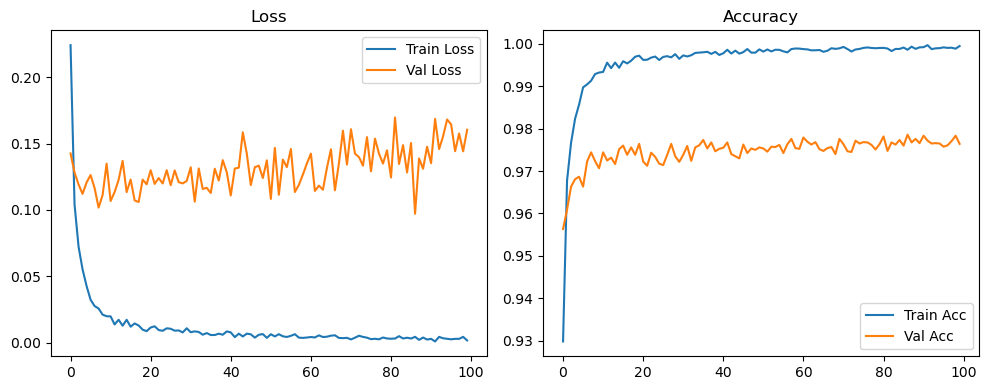

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2719, Acc: 0.9162 | Val Loss: 0.1411, Acc: 0.9573


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9561 | Val Loss: 0.1114, Acc: 0.9658


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9644 | Val Loss: 0.1104, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0890, Acc: 0.9721 | Val Loss: 0.1037, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0754, Acc: 0.9759 | Val Loss: 0.1024, Acc: 0.9699


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0640, Acc: 0.9796 | Val Loss: 0.0961, Acc: 0.9707


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0558, Acc: 0.9818 | Val Loss: 0.1017, Acc: 0.9720


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9831 | Val Loss: 0.0990, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9854 | Val Loss: 0.1036, Acc: 0.9713


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9852 | Val Loss: 0.0895, Acc: 0.9748


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9865 | Val Loss: 0.0872, Acc: 0.9756


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.0942, Acc: 0.9759


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9872 | Val Loss: 0.0997, Acc: 0.9745


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.1018, Acc: 0.9749


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.0954, Acc: 0.9743


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0946, Acc: 0.9756


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.0975, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9901 | Val Loss: 0.1058, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0974, Acc: 0.9747


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.0986, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0940, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0898, Acc: 0.9763


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.0957, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1003, Acc: 0.9769


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.1089, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0944, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1013, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.1048, Acc: 0.9759


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.1068, Acc: 0.9765


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.1104, Acc: 0.9742


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.0985, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.1015, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9933 | Val Loss: 0.0922, Acc: 0.9755


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.0968, Acc: 0.9786


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1065, Acc: 0.9757


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.1037, Acc: 0.9776


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0935, Acc: 0.9760


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0967, Acc: 0.9760


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0978, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1026, Acc: 0.9764


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.1113, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.1021, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1120, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1016, Acc: 0.9761


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0988, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1046, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0952, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.0998, Acc: 0.9760


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1141, Acc: 0.9764


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.1032, Acc: 0.9785


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.1199, Acc: 0.9768


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0911, Acc: 0.9791


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1037, Acc: 0.9752


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0963, Acc: 0.9772


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0963, Acc: 0.9786


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1154, Acc: 0.9781


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1039, Acc: 0.9756


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0933, Acc: 0.9784


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1148, Acc: 0.9762


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.1169, Acc: 0.9773


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0999, Acc: 0.9772


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0856, Acc: 0.9792


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1207, Acc: 0.9780


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1162, Acc: 0.9772


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1117, Acc: 0.9770


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1134, Acc: 0.9760


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1109, Acc: 0.9784


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0961, Acc: 0.9776


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0976, Acc: 0.9792


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.1087, Acc: 0.9780


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1132, Acc: 0.9765


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1093, Acc: 0.9773


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0992, Acc: 0.9783


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1015, Acc: 0.9792


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1107, Acc: 0.9775


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0994, Acc: 0.9770


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1220, Acc: 0.9794


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1009, Acc: 0.9786


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.1039, Acc: 0.9782


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1029, Acc: 0.9787


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1108, Acc: 0.9772


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1103, Acc: 0.9797


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1309, Acc: 0.9786


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1093, Acc: 0.9793


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1009, Acc: 0.9788


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1031, Acc: 0.9793


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1012, Acc: 0.9792


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0964, Acc: 0.9778


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1135, Acc: 0.9772


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1018, Acc: 0.9787


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0995, Acc: 0.9778


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1034, Acc: 0.9777


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1109, Acc: 0.9774


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1108, Acc: 0.9761


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1081, Acc: 0.9785


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1270, Acc: 0.9772


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1029, Acc: 0.9770


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1100, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0941, Acc: 0.9771


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1221, Acc: 0.9771


Final Test Loss: 0.1125 Accuracy: 0.9797


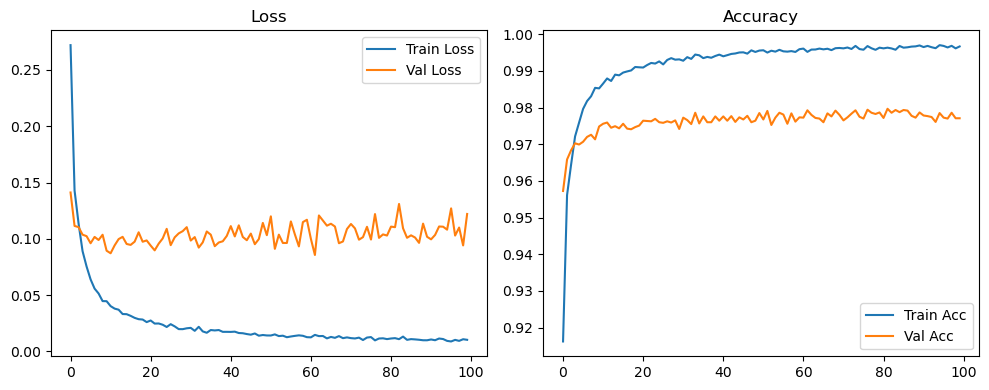

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4349, Acc: 0.8690 | Val Loss: 0.1703, Acc: 0.9449


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2494, Acc: 0.9265 | Val Loss: 0.1534, Acc: 0.9530


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2074, Acc: 0.9397 | Val Loss: 0.1368, Acc: 0.9586


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1826, Acc: 0.9446 | Val Loss: 0.1267, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1642, Acc: 0.9507 | Val Loss: 0.1115, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1526, Acc: 0.9550 | Val Loss: 0.1082, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9575 | Val Loss: 0.1084, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9603 | Val Loss: 0.1021, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1288, Acc: 0.9609 | Val Loss: 0.1006, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1265, Acc: 0.9615 | Val Loss: 0.1032, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9645 | Val Loss: 0.1064, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9658 | Val Loss: 0.1012, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9671 | Val Loss: 0.1029, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9677 | Val Loss: 0.0983, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9686 | Val Loss: 0.1007, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9688 | Val Loss: 0.1028, Acc: 0.9715


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1034, Acc: 0.9728


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9719 | Val Loss: 0.0976, Acc: 0.9737


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.0975, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0936, Acc: 0.9718 | Val Loss: 0.0953, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9723 | Val Loss: 0.0989, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9728 | Val Loss: 0.0978, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9719 | Val Loss: 0.0990, Acc: 0.9734


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9725 | Val Loss: 0.0978, Acc: 0.9724


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9760 | Val Loss: 0.1076, Acc: 0.9716


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9743 | Val Loss: 0.0978, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.0989, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9756 | Val Loss: 0.0981, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9762 | Val Loss: 0.0978, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9764 | Val Loss: 0.0980, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9762 | Val Loss: 0.0941, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0955, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9764 | Val Loss: 0.1005, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9771 | Val Loss: 0.1010, Acc: 0.9734


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9774 | Val Loss: 0.0983, Acc: 0.9742


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9777 | Val Loss: 0.0998, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9778 | Val Loss: 0.0949, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0976, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0938, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0948, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9793 | Val Loss: 0.0877, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9790 | Val Loss: 0.0954, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9786 | Val Loss: 0.0943, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9797 | Val Loss: 0.0977, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9801 | Val Loss: 0.0951, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9795 | Val Loss: 0.0852, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0943, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9793 | Val Loss: 0.0903, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9802 | Val Loss: 0.0912, Acc: 0.9750


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9804 | Val Loss: 0.0984, Acc: 0.9755


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9809 | Val Loss: 0.1009, Acc: 0.9742


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9805 | Val Loss: 0.0932, Acc: 0.9744


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0606, Acc: 0.9815 | Val Loss: 0.0948, Acc: 0.9755


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9807 | Val Loss: 0.0973, Acc: 0.9758


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9807 | Val Loss: 0.0948, Acc: 0.9756


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9817 | Val Loss: 0.1014, Acc: 0.9748


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9817 | Val Loss: 0.0974, Acc: 0.9756


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9810 | Val Loss: 0.1047, Acc: 0.9731


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9819 | Val Loss: 0.0995, Acc: 0.9737


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0598, Acc: 0.9822 | Val Loss: 0.0975, Acc: 0.9755


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9825 | Val Loss: 0.0935, Acc: 0.9748


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9829 | Val Loss: 0.0999, Acc: 0.9748


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9836 | Val Loss: 0.1091, Acc: 0.9748


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9823 | Val Loss: 0.1028, Acc: 0.9752


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9817 | Val Loss: 0.0984, Acc: 0.9758


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9833 | Val Loss: 0.0928, Acc: 0.9769


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9830 | Val Loss: 0.0994, Acc: 0.9762


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9833 | Val Loss: 0.0854, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9833 | Val Loss: 0.0962, Acc: 0.9757


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9827 | Val Loss: 0.0942, Acc: 0.9761


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9819 | Val Loss: 0.0963, Acc: 0.9755


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9828 | Val Loss: 0.0941, Acc: 0.9755


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9827 | Val Loss: 0.1036, Acc: 0.9737


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.1078, Acc: 0.9752


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9830 | Val Loss: 0.0975, Acc: 0.9754


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.1005, Acc: 0.9746


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9831 | Val Loss: 0.1040, Acc: 0.9736


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9843 | Val Loss: 0.0981, Acc: 0.9755


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9826 | Val Loss: 0.1037, Acc: 0.9746


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9846 | Val Loss: 0.0998, Acc: 0.9753


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9844 | Val Loss: 0.0900, Acc: 0.9752


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9835 | Val Loss: 0.0944, Acc: 0.9761


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0530, Acc: 0.9842 | Val Loss: 0.1074, Acc: 0.9768


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9826 | Val Loss: 0.1008, Acc: 0.9756


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9837 | Val Loss: 0.1037, Acc: 0.9748


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.1010, Acc: 0.9760


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9846 | Val Loss: 0.1065, Acc: 0.9753


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9830 | Val Loss: 0.1055, Acc: 0.9768


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9848 | Val Loss: 0.0957, Acc: 0.9757


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9842 | Val Loss: 0.1002, Acc: 0.9745


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9853 | Val Loss: 0.1080, Acc: 0.9753


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9847 | Val Loss: 0.1041, Acc: 0.9748


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9828 | Val Loss: 0.1028, Acc: 0.9749


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9850 | Val Loss: 0.1002, Acc: 0.9730


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9845 | Val Loss: 0.1000, Acc: 0.9758


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.1023, Acc: 0.9760


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9842 | Val Loss: 0.1091, Acc: 0.9758


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9835 | Val Loss: 0.0975, Acc: 0.9757


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9848 | Val Loss: 0.0901, Acc: 0.9758


Final Test Loss: 0.0828 Accuracy: 0.9793


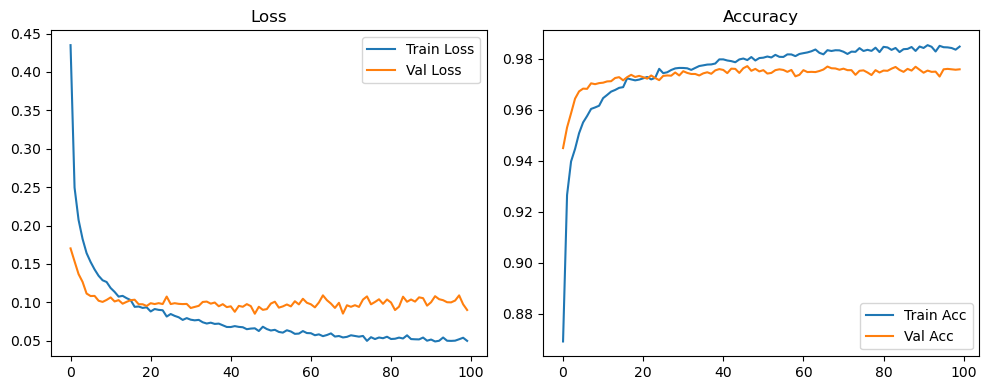

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2227, Acc: 0.9299 | Val Loss: 0.1341, Acc: 0.9588


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9675 | Val Loss: 0.1170, Acc: 0.9641


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9771 | Val Loss: 0.1310, Acc: 0.9643


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 0.1283, Acc: 0.9647


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.1126, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9883 | Val Loss: 0.1256, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.1176, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9908 | Val Loss: 0.1071, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9928 | Val Loss: 0.1279, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1274, Acc: 0.9712


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1165, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1074, Acc: 0.9740


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1142, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1405, Acc: 0.9687


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1260, Acc: 0.9732


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1213, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1142, Acc: 0.9744


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1294, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1239, Acc: 0.9735


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1168, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1139, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1280, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1205, Acc: 0.9744


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1404, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1327, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1243, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1232, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1251, Acc: 0.9740


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1257, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1281, Acc: 0.9723


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1272, Acc: 0.9713


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9764


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1174, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1439, Acc: 0.9718


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1141, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1340, Acc: 0.9760


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1210, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1245, Acc: 0.9729


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1255, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1218, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1231, Acc: 0.9735


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1395, Acc: 0.9754


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1143, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1271, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1268, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1410, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1374, Acc: 0.9783


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1517, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1225, Acc: 0.9786


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1264, Acc: 0.9796


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1352, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1432, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1362, Acc: 0.9797


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1405, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1577, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1497, Acc: 0.9772


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1537, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1461, Acc: 0.9755


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1513, Acc: 0.9768


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1342, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1380, Acc: 0.9783


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1476, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1550, Acc: 0.9785


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1397, Acc: 0.9780


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1306, Acc: 0.9777


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1197, Acc: 0.9774


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1421, Acc: 0.9781


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1468, Acc: 0.9768


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1529, Acc: 0.9762


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1379, Acc: 0.9776


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1529, Acc: 0.9772


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1416, Acc: 0.9769


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1370, Acc: 0.9772


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1378, Acc: 0.9759


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1340, Acc: 0.9762


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1429, Acc: 0.9772


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1398, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1508, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1520, Acc: 0.9770


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1532, Acc: 0.9772


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1618, Acc: 0.9780


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1598, Acc: 0.9774


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1610, Acc: 0.9772


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1644, Acc: 0.9775


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1644, Acc: 0.9775


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1630, Acc: 0.9781


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1636, Acc: 0.9777


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1688, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1689, Acc: 0.9773


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1694, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1715, Acc: 0.9772


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1733, Acc: 0.9768


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1803, Acc: 0.9776


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1755, Acc: 0.9772


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1724, Acc: 0.9782


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1712, Acc: 0.9783


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1842, Acc: 0.9780


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1818, Acc: 0.9782


Final Test Loss: 0.1771 Accuracy: 0.9808


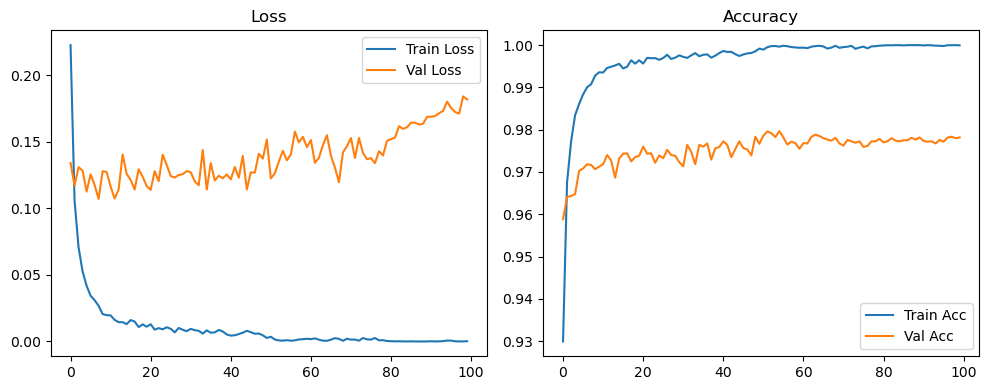

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9159 | Val Loss: 0.1456, Acc: 0.9558


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1434, Acc: 0.9568 | Val Loss: 0.1163, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9643 | Val Loss: 0.1129, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9728 | Val Loss: 0.1024, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9760 | Val Loss: 0.0975, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0915, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9807 | Val Loss: 0.0962, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.0907, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 0.1027, Acc: 0.9737


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.0909, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9865 | Val Loss: 0.0964, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1012, Acc: 0.9729


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 0.0945, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0975, Acc: 0.9760


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0974, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.0979, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0896, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.1003, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0904, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0962, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.0930, Acc: 0.9777


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.0927, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0928, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0972, Acc: 0.9774


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0893, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0908, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1044, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1023, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0968, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0991, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0918, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0930, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0956, Acc: 0.9759


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0948, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0999, Acc: 0.9780


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0910, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0932, Acc: 0.9780


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0895, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0942, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.0923, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0920, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0990, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1022, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1066, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0892, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1077, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1233, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0913, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0931, Acc: 0.9801


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1009, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1028, Acc: 0.9794


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9789


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1057, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1052, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1112, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9807


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9811


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0941, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1017, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1045, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1099, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1047, Acc: 0.9798


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1016, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1073, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0983, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1047, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1136, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0997, Acc: 0.9799


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1129, Acc: 0.9781


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1108, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1210, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1056, Acc: 0.9799


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1150, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1123, Acc: 0.9791


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1157, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1111, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1134, Acc: 0.9789


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1088, Acc: 0.9801


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1095, Acc: 0.9790


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1173, Acc: 0.9797


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1145, Acc: 0.9797


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1166, Acc: 0.9798


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1146, Acc: 0.9792


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1160, Acc: 0.9798


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1104, Acc: 0.9805


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1242, Acc: 0.9801


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1166, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1286, Acc: 0.9797


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1217, Acc: 0.9804


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1191, Acc: 0.9808


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9806


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1249, Acc: 0.9800


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1188, Acc: 0.9796


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1167, Acc: 0.9800


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1157, Acc: 0.9803


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1196, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1193, Acc: 0.9793


Final Test Loss: 0.1159 Accuracy: 0.9829


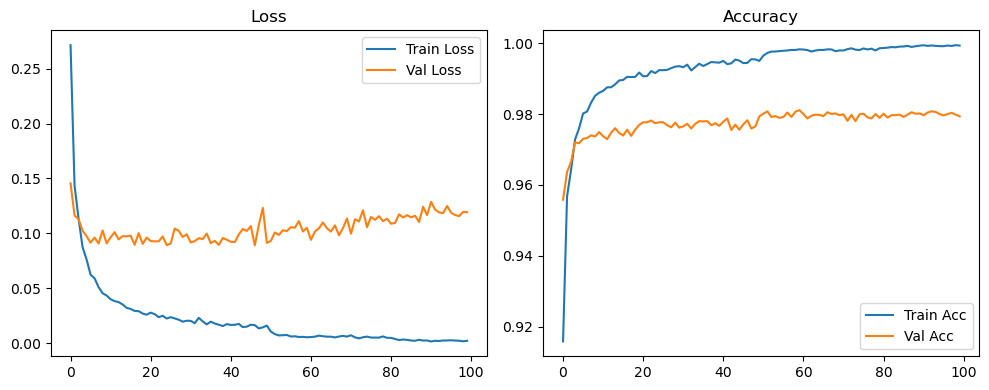

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4349, Acc: 0.8690 | Val Loss: 0.1703, Acc: 0.9449


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2494, Acc: 0.9265 | Val Loss: 0.1534, Acc: 0.9530


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2074, Acc: 0.9397 | Val Loss: 0.1368, Acc: 0.9586


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1826, Acc: 0.9446 | Val Loss: 0.1267, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1642, Acc: 0.9507 | Val Loss: 0.1115, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1526, Acc: 0.9550 | Val Loss: 0.1082, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9575 | Val Loss: 0.1084, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9603 | Val Loss: 0.1021, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1288, Acc: 0.9609 | Val Loss: 0.1006, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1265, Acc: 0.9615 | Val Loss: 0.1032, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9645 | Val Loss: 0.1064, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9658 | Val Loss: 0.1012, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9671 | Val Loss: 0.1029, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9677 | Val Loss: 0.0983, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9686 | Val Loss: 0.1007, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9688 | Val Loss: 0.1028, Acc: 0.9715


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1034, Acc: 0.9728


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9719 | Val Loss: 0.0976, Acc: 0.9737


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.0975, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0936, Acc: 0.9718 | Val Loss: 0.0953, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9723 | Val Loss: 0.0989, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9728 | Val Loss: 0.0978, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9719 | Val Loss: 0.0990, Acc: 0.9734


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9725 | Val Loss: 0.0978, Acc: 0.9724


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9760 | Val Loss: 0.1076, Acc: 0.9716


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9743 | Val Loss: 0.0978, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.0989, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9756 | Val Loss: 0.0981, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9762 | Val Loss: 0.0978, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9764 | Val Loss: 0.0980, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9762 | Val Loss: 0.0941, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0955, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9764 | Val Loss: 0.1005, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9771 | Val Loss: 0.1010, Acc: 0.9734


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9774 | Val Loss: 0.0983, Acc: 0.9742


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9777 | Val Loss: 0.0998, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9778 | Val Loss: 0.0949, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0976, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0938, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0948, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9793 | Val Loss: 0.0877, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9790 | Val Loss: 0.0954, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9786 | Val Loss: 0.0943, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9797 | Val Loss: 0.0977, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9801 | Val Loss: 0.0951, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9795 | Val Loss: 0.0852, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0943, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9793 | Val Loss: 0.0903, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9802 | Val Loss: 0.0912, Acc: 0.9750


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0913, Acc: 0.9769


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9842 | Val Loss: 0.0931, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.0924, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0900, Acc: 0.9768


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9868 | Val Loss: 0.0919, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.0923, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 0.0926, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.1021, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.0980, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9875 | Val Loss: 0.0965, Acc: 0.9764


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9875 | Val Loss: 0.1039, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9875 | Val Loss: 0.0995, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9881 | Val Loss: 0.1034, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.1033, Acc: 0.9763


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.1091, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9879 | Val Loss: 0.1055, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.1025, Acc: 0.9760


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9882 | Val Loss: 0.1063, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9883 | Val Loss: 0.0989, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9888 | Val Loss: 0.1030, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.1004, Acc: 0.9775


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.1037, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9891 | Val Loss: 0.1012, Acc: 0.9762


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.1076, Acc: 0.9765


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.1127, Acc: 0.9759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.1033, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.1087, Acc: 0.9769


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9896 | Val Loss: 0.0988, Acc: 0.9761


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.1020, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0972, Acc: 0.9774


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9902 | Val Loss: 0.1046, Acc: 0.9772


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9912 | Val Loss: 0.1014, Acc: 0.9766


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.1029, Acc: 0.9764


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1066, Acc: 0.9765


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9909 | Val Loss: 0.0985, Acc: 0.9770


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.0992, Acc: 0.9767


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.1001, Acc: 0.9774


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.1085, Acc: 0.9779


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.1125, Acc: 0.9772


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.1039, Acc: 0.9783


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9927 | Val Loss: 0.1102, Acc: 0.9769


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.1076, Acc: 0.9763


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.1111, Acc: 0.9761


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9922 | Val Loss: 0.1073, Acc: 0.9774


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.1137, Acc: 0.9766


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1149, Acc: 0.9762


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9927 | Val Loss: 0.1049, Acc: 0.9771


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1131, Acc: 0.9756


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.1146, Acc: 0.9768


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.1091, Acc: 0.9768


Final Test Loss: 0.0943 Accuracy: 0.9803


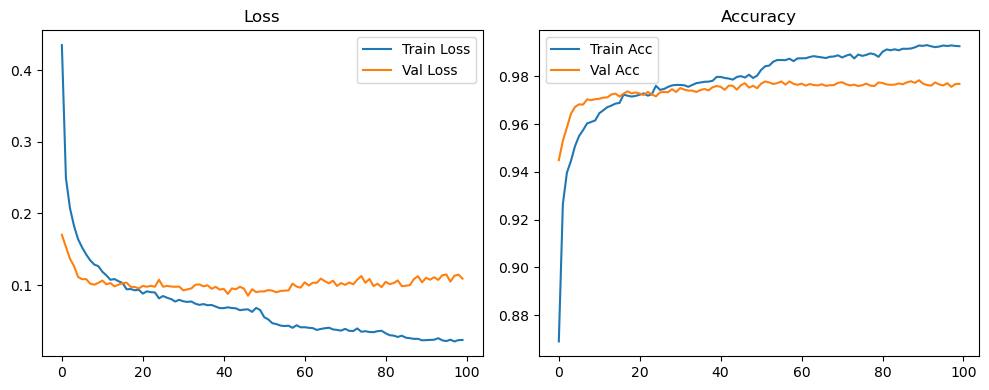

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2245, Acc: 0.9293 | Val Loss: 0.1369, Acc: 0.9567


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9669 | Val Loss: 0.1138, Acc: 0.9652


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9771 | Val Loss: 0.1292, Acc: 0.9623


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9829 | Val Loss: 0.1165, Acc: 0.9694


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9862 | Val Loss: 0.1140, Acc: 0.9705


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9898 | Val Loss: 0.1098, Acc: 0.9701


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1201, Acc: 0.9708


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1099, Acc: 0.9720


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.1303, Acc: 0.9701


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1220, Acc: 0.9697


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1269, Acc: 0.9714


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.1345, Acc: 0.9710


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.1204, Acc: 0.9705


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1196, Acc: 0.9726


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1328, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1271, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1481, Acc: 0.9675


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1362, Acc: 0.9711


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9948 | Val Loss: 0.1089, Acc: 0.9746


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1248, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1104, Acc: 0.9762


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1368, Acc: 0.9733


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1107, Acc: 0.9759


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1246, Acc: 0.9728


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1212, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1304, Acc: 0.9738


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1258, Acc: 0.9769


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1294, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1230, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1332, Acc: 0.9736


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1392, Acc: 0.9742


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1159, Acc: 0.9753


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1359, Acc: 0.9716


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1247, Acc: 0.9753


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1440, Acc: 0.9723


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1413, Acc: 0.9721


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1419, Acc: 0.9721


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.1297, Acc: 0.9763


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1406, Acc: 0.9751


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1226, Acc: 0.9773


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1254, Acc: 0.9758


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1638, Acc: 0.9731


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1449, Acc: 0.9728


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1449, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1321, Acc: 0.9740


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1125, Acc: 0.9760


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1373, Acc: 0.9744


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1583, Acc: 0.9749


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1449, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1295, Acc: 0.9752


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1328, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1286, Acc: 0.9790


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1266, Acc: 0.9782


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1154, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1278, Acc: 0.9799


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1309, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1416, Acc: 0.9787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1310, Acc: 0.9797


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1338, Acc: 0.9783


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1355, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1507, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1480, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1276, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1184, Acc: 0.9785


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1310, Acc: 0.9779


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1304, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1377, Acc: 0.9808


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1330, Acc: 0.9784


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1372, Acc: 0.9788


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1458, Acc: 0.9760


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1423, Acc: 0.9761


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1345, Acc: 0.9782


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1559, Acc: 0.9778


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1594, Acc: 0.9776


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1440, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1519, Acc: 0.9779


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1486, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1542, Acc: 0.9789


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1545, Acc: 0.9793


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1626, Acc: 0.9787


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1623, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1648, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1693, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1644, Acc: 0.9793


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1668, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1661, Acc: 0.9793


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1640, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1657, Acc: 0.9801


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1677, Acc: 0.9800


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1658, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1653, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1671, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1707, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1717, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1746, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1730, Acc: 0.9799


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1768, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1777, Acc: 0.9792


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1780, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1824, Acc: 0.9790


Final Test Loss: 0.1495 Accuracy: 0.9813


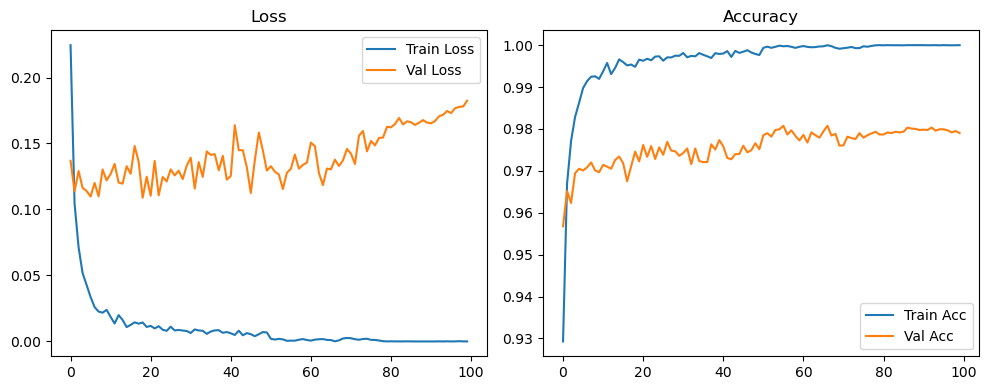

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9159 | Val Loss: 0.1456, Acc: 0.9558


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1434, Acc: 0.9568 | Val Loss: 0.1163, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9643 | Val Loss: 0.1129, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9728 | Val Loss: 0.1024, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9760 | Val Loss: 0.0975, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0915, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9807 | Val Loss: 0.0962, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.0907, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 0.1027, Acc: 0.9737


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.0909, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9865 | Val Loss: 0.0964, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1012, Acc: 0.9729


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 0.0945, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0975, Acc: 0.9760


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0974, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.0979, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0896, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.1003, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0904, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0962, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.0930, Acc: 0.9777


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.0927, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0928, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0972, Acc: 0.9774


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0893, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0908, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1044, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1023, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0968, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0991, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0918, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0930, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0956, Acc: 0.9759


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0948, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0999, Acc: 0.9780


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0910, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0932, Acc: 0.9780


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0895, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0942, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.0923, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0920, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0990, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1022, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1066, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0892, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1077, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1233, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0913, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0931, Acc: 0.9801


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1009, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1028, Acc: 0.9794


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1022, Acc: 0.9789


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1057, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1052, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1112, Acc: 0.9792


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9807


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1051, Acc: 0.9811


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0941, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1017, Acc: 0.9788


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1045, Acc: 0.9795


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1099, Acc: 0.9798


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1047, Acc: 0.9798


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1016, Acc: 0.9794


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1073, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0983, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1047, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1136, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0997, Acc: 0.9799


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1129, Acc: 0.9781


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1108, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1210, Acc: 0.9780


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1056, Acc: 0.9799


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1150, Acc: 0.9801


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1123, Acc: 0.9791


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1157, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1111, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1134, Acc: 0.9789


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1083, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1102, Acc: 0.9800


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1152, Acc: 0.9794


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1126, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1170, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1209, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1218, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1163, Acc: 0.9801


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1213, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1183, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1219, Acc: 0.9802


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1221, Acc: 0.9800


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1224, Acc: 0.9803


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1231, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1251, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1221, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1202, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1179, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1183, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1214, Acc: 0.9812


Final Test Loss: 0.1177 Accuracy: 0.9835


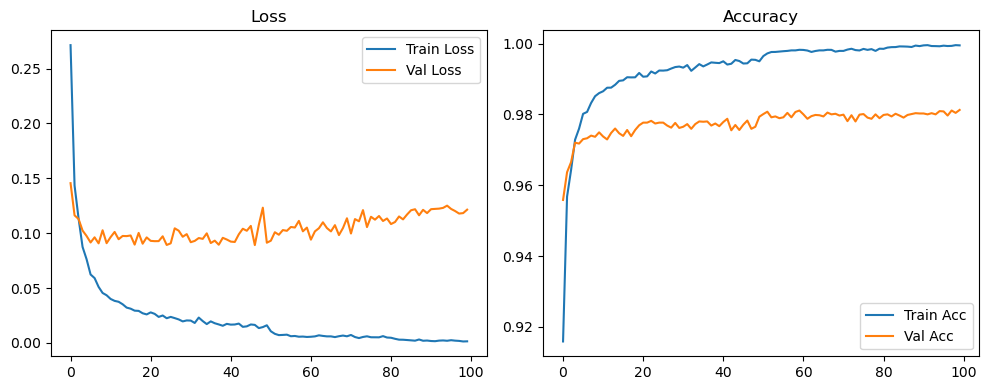

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4349, Acc: 0.8690 | Val Loss: 0.1703, Acc: 0.9449


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2494, Acc: 0.9265 | Val Loss: 0.1534, Acc: 0.9530


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2074, Acc: 0.9397 | Val Loss: 0.1368, Acc: 0.9586


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1826, Acc: 0.9446 | Val Loss: 0.1267, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1642, Acc: 0.9507 | Val Loss: 0.1115, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1526, Acc: 0.9550 | Val Loss: 0.1082, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9575 | Val Loss: 0.1084, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9603 | Val Loss: 0.1021, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1288, Acc: 0.9609 | Val Loss: 0.1006, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1265, Acc: 0.9615 | Val Loss: 0.1032, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9645 | Val Loss: 0.1064, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9658 | Val Loss: 0.1012, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9671 | Val Loss: 0.1029, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9677 | Val Loss: 0.0983, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9686 | Val Loss: 0.1007, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9688 | Val Loss: 0.1028, Acc: 0.9715


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1034, Acc: 0.9728


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9719 | Val Loss: 0.0976, Acc: 0.9737


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.0975, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0936, Acc: 0.9718 | Val Loss: 0.0953, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9723 | Val Loss: 0.0989, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9728 | Val Loss: 0.0978, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9719 | Val Loss: 0.0990, Acc: 0.9734


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9725 | Val Loss: 0.0978, Acc: 0.9724


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9760 | Val Loss: 0.1076, Acc: 0.9716


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9743 | Val Loss: 0.0978, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.0989, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9756 | Val Loss: 0.0981, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9762 | Val Loss: 0.0978, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9764 | Val Loss: 0.0980, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9762 | Val Loss: 0.0941, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0955, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9764 | Val Loss: 0.1005, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9771 | Val Loss: 0.1010, Acc: 0.9734


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9774 | Val Loss: 0.0983, Acc: 0.9742


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9777 | Val Loss: 0.0998, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9778 | Val Loss: 0.0949, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0976, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0938, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0948, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9793 | Val Loss: 0.0877, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9790 | Val Loss: 0.0954, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9786 | Val Loss: 0.0943, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9797 | Val Loss: 0.0977, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9801 | Val Loss: 0.0951, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9795 | Val Loss: 0.0852, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0943, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9793 | Val Loss: 0.0903, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9802 | Val Loss: 0.0912, Acc: 0.9750


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0913, Acc: 0.9769


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9842 | Val Loss: 0.0931, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.0924, Acc: 0.9774


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9861 | Val Loss: 0.0900, Acc: 0.9768


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9868 | Val Loss: 0.0919, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9868 | Val Loss: 0.0923, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9868 | Val Loss: 0.0926, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.1021, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9863 | Val Loss: 0.0980, Acc: 0.9768


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9875 | Val Loss: 0.0965, Acc: 0.9764


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9875 | Val Loss: 0.1039, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9875 | Val Loss: 0.0995, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9881 | Val Loss: 0.1034, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.1033, Acc: 0.9763


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9881 | Val Loss: 0.1091, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9879 | Val Loss: 0.1055, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9876 | Val Loss: 0.1025, Acc: 0.9760


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9882 | Val Loss: 0.1063, Acc: 0.9762


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9883 | Val Loss: 0.0989, Acc: 0.9763


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9888 | Val Loss: 0.1030, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.1004, Acc: 0.9775


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.1037, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9891 | Val Loss: 0.1012, Acc: 0.9762


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.1076, Acc: 0.9765


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.1127, Acc: 0.9759


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.1033, Acc: 0.9762


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.1087, Acc: 0.9769


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9896 | Val Loss: 0.0988, Acc: 0.9761


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9892 | Val Loss: 0.1020, Acc: 0.9759


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0972, Acc: 0.9774


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9899 | Val Loss: 0.1053, Acc: 0.9772


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9912 | Val Loss: 0.1040, Acc: 0.9769


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9907 | Val Loss: 0.1027, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9914 | Val Loss: 0.1051, Acc: 0.9776


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9910 | Val Loss: 0.1016, Acc: 0.9767


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9919 | Val Loss: 0.1009, Acc: 0.9775


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.1009, Acc: 0.9774


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.1057, Acc: 0.9778


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1083, Acc: 0.9772


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.1031, Acc: 0.9779


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.1074, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.1067, Acc: 0.9779


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.1058, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.1058, Acc: 0.9778


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.1082, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9933 | Val Loss: 0.1074, Acc: 0.9778


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.1070, Acc: 0.9775


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1122, Acc: 0.9771


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1071, Acc: 0.9775


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9933 | Val Loss: 0.1044, Acc: 0.9777


Final Test Loss: 0.0913 Accuracy: 0.9815


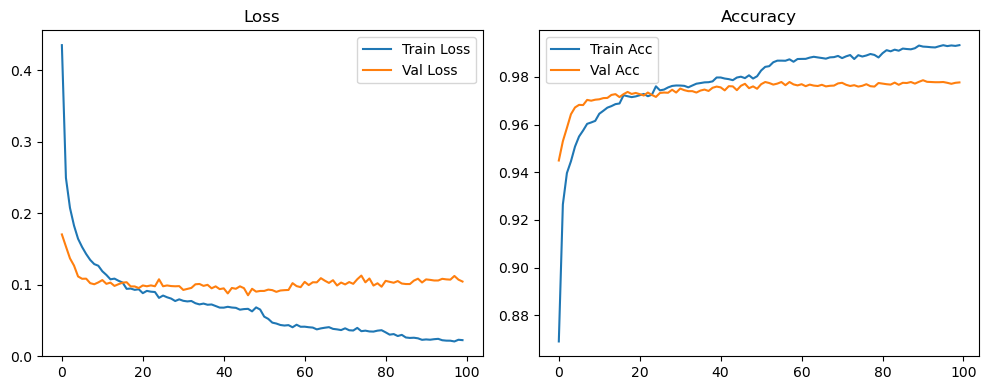

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2227, Acc: 0.9299 | Val Loss: 0.1341, Acc: 0.9588


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9675 | Val Loss: 0.1170, Acc: 0.9641


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9771 | Val Loss: 0.1310, Acc: 0.9643


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 0.1283, Acc: 0.9647


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.1126, Acc: 0.9702


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9883 | Val Loss: 0.1256, Acc: 0.9708


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.1176, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9908 | Val Loss: 0.1071, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9928 | Val Loss: 0.1279, Acc: 0.9707


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1274, Acc: 0.9712


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1165, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1074, Acc: 0.9740


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.1142, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1405, Acc: 0.9687


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1260, Acc: 0.9732


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1213, Acc: 0.9743


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1142, Acc: 0.9744


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1294, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1239, Acc: 0.9735


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1168, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1139, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1280, Acc: 0.9743


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1205, Acc: 0.9744


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1404, Acc: 0.9722


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1327, Acc: 0.9739


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1243, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1232, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1251, Acc: 0.9740


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1257, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1281, Acc: 0.9723


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1272, Acc: 0.9713


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1203, Acc: 0.9764


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1174, Acc: 0.9748


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1439, Acc: 0.9718


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1141, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1340, Acc: 0.9760


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1210, Acc: 0.9768


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1245, Acc: 0.9729


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1255, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1218, Acc: 0.9772


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9764


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1231, Acc: 0.9735


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1395, Acc: 0.9754


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1143, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1271, Acc: 0.9757


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1268, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1410, Acc: 0.9739


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1374, Acc: 0.9783


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1517, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1241, Acc: 0.9780


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1276, Acc: 0.9782


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1298, Acc: 0.9789


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1317, Acc: 0.9786


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1365, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1375, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1420, Acc: 0.9795


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1401, Acc: 0.9787


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1427, Acc: 0.9794


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1392, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1444, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1472, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1494, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1520, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1481, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1558, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1573, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1565, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1655, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1658, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1656, Acc: 0.9790


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1636, Acc: 0.9792


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1515, Acc: 0.9784


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1466, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1513, Acc: 0.9795


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1575, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1544, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1567, Acc: 0.9791


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1570, Acc: 0.9790


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1570, Acc: 0.9787


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1570, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1623, Acc: 0.9789


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1612, Acc: 0.9794


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1613, Acc: 0.9800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1650, Acc: 0.9790


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1645, Acc: 0.9793


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1651, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1678, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1718, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1708, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1774, Acc: 0.9789


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1706, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1736, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1741, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1743, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1795, Acc: 0.9798


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1795, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1811, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1828, Acc: 0.9796


Final Test Loss: 0.1735 Accuracy: 0.9813


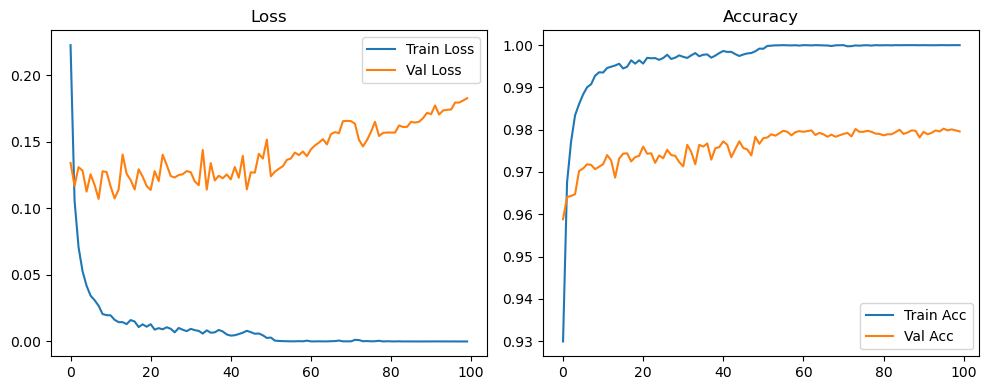

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9159 | Val Loss: 0.1456, Acc: 0.9558


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1434, Acc: 0.9568 | Val Loss: 0.1163, Acc: 0.9637


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1135, Acc: 0.9643 | Val Loss: 0.1129, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9728 | Val Loss: 0.1024, Acc: 0.9720


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9760 | Val Loss: 0.0975, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0915, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9807 | Val Loss: 0.0962, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.0907, Acc: 0.9740


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9851 | Val Loss: 0.1027, Acc: 0.9737


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.0909, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9865 | Val Loss: 0.0964, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1012, Acc: 0.9729


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9875 | Val Loss: 0.0945, Acc: 0.9748


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0975, Acc: 0.9760


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0974, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9896 | Val Loss: 0.0979, Acc: 0.9739


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9905 | Val Loss: 0.0896, Acc: 0.9756


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.1003, Acc: 0.9738


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9905 | Val Loss: 0.0904, Acc: 0.9756


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0962, Acc: 0.9769


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.0930, Acc: 0.9777


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9907 | Val Loss: 0.0927, Acc: 0.9777


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0928, Acc: 0.9782


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9915 | Val Loss: 0.0972, Acc: 0.9774


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0893, Acc: 0.9777


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0908, Acc: 0.9777


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.1044, Acc: 0.9768


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1023, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0968, Acc: 0.9776


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0991, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0918, Acc: 0.9765


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0930, Acc: 0.9772


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0956, Acc: 0.9759


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.0948, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0999, Acc: 0.9780


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0910, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0932, Acc: 0.9780


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0895, Acc: 0.9768


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0958, Acc: 0.9774


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0942, Acc: 0.9767


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9950 | Val Loss: 0.0923, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0920, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0990, Acc: 0.9755


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9770


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1022, Acc: 0.9756


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1066, Acc: 0.9771


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0892, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1077, Acc: 0.9759


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1233, Acc: 0.9765


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0913, Acc: 0.9793


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0939, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0979, Acc: 0.9809


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1040, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1050, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0974, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1008, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1068, Acc: 0.9803


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1112, Acc: 0.9801


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1088, Acc: 0.9809


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1085, Acc: 0.9812


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1063, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1042, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1049, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1141, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1084, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1139, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1134, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1057, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1067, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1097, Acc: 0.9794


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1121, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1052, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1154, Acc: 0.9795


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1173, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1170, Acc: 0.9809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1252, Acc: 0.9802


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1140, Acc: 0.9806


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1130, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1095, Acc: 0.9810


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1112, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1127, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1140, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1205, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1212, Acc: 0.9809


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1202, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1139, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1161, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1111, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1156, Acc: 0.9809


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1102, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1130, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1105, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1129, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1128, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1182, Acc: 0.9809


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1159, Acc: 0.9820


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1132, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1180, Acc: 0.9806


Final Test Loss: 0.1091 Accuracy: 0.9833


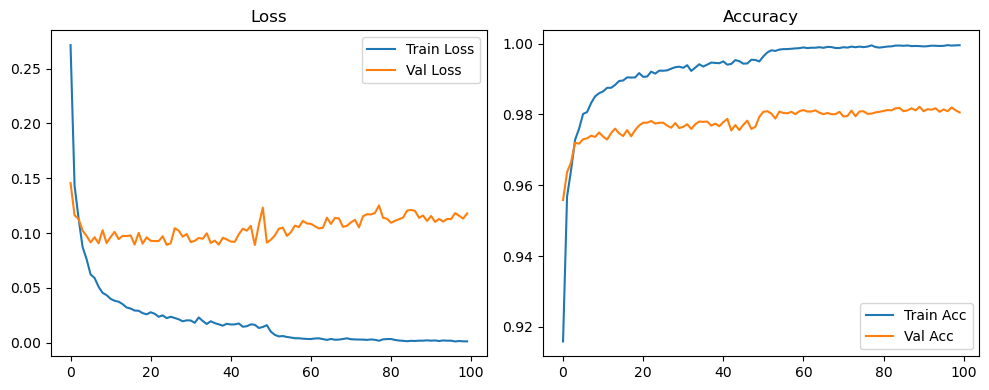

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4349, Acc: 0.8690 | Val Loss: 0.1703, Acc: 0.9449


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2494, Acc: 0.9265 | Val Loss: 0.1534, Acc: 0.9530


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2074, Acc: 0.9397 | Val Loss: 0.1368, Acc: 0.9586


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1826, Acc: 0.9446 | Val Loss: 0.1267, Acc: 0.9643


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1642, Acc: 0.9507 | Val Loss: 0.1115, Acc: 0.9672


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1526, Acc: 0.9550 | Val Loss: 0.1082, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9575 | Val Loss: 0.1084, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1346, Acc: 0.9603 | Val Loss: 0.1021, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1288, Acc: 0.9609 | Val Loss: 0.1006, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1265, Acc: 0.9615 | Val Loss: 0.1032, Acc: 0.9704


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9645 | Val Loss: 0.1064, Acc: 0.9706


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1136, Acc: 0.9658 | Val Loss: 0.1012, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1075, Acc: 0.9671 | Val Loss: 0.1029, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9677 | Val Loss: 0.0983, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9686 | Val Loss: 0.1007, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9688 | Val Loss: 0.1028, Acc: 0.9715


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9723 | Val Loss: 0.1034, Acc: 0.9728


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0946, Acc: 0.9719 | Val Loss: 0.0976, Acc: 0.9737


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0928, Acc: 0.9715 | Val Loss: 0.0975, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0936, Acc: 0.9718 | Val Loss: 0.0953, Acc: 0.9732


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0881, Acc: 0.9723 | Val Loss: 0.0989, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0913, Acc: 0.9728 | Val Loss: 0.0978, Acc: 0.9722


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0902, Acc: 0.9719 | Val Loss: 0.0990, Acc: 0.9734


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9725 | Val Loss: 0.0978, Acc: 0.9724


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0815, Acc: 0.9760 | Val Loss: 0.1076, Acc: 0.9716


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0848, Acc: 0.9743 | Val Loss: 0.0978, Acc: 0.9732


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9747 | Val Loss: 0.0989, Acc: 0.9734


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9756 | Val Loss: 0.0981, Acc: 0.9733


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9762 | Val Loss: 0.0978, Acc: 0.9746


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0795, Acc: 0.9764 | Val Loss: 0.0980, Acc: 0.9734


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0774, Acc: 0.9764 | Val Loss: 0.0927, Acc: 0.9751


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9762 | Val Loss: 0.0941, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9756 | Val Loss: 0.0955, Acc: 0.9740


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0741, Acc: 0.9764 | Val Loss: 0.1005, Acc: 0.9740


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9771 | Val Loss: 0.1010, Acc: 0.9734


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9774 | Val Loss: 0.0983, Acc: 0.9742


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9777 | Val Loss: 0.0998, Acc: 0.9747


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9778 | Val Loss: 0.0949, Acc: 0.9741


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0976, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0938, Acc: 0.9759


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9797 | Val Loss: 0.0948, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9793 | Val Loss: 0.0877, Acc: 0.9743


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9790 | Val Loss: 0.0954, Acc: 0.9761


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9786 | Val Loss: 0.0943, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9797 | Val Loss: 0.0977, Acc: 0.9744


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0659, Acc: 0.9801 | Val Loss: 0.0951, Acc: 0.9762


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9795 | Val Loss: 0.0852, Acc: 0.9771


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9806 | Val Loss: 0.0943, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9793 | Val Loss: 0.0903, Acc: 0.9760


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9802 | Val Loss: 0.0912, Acc: 0.9750


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9830 | Val Loss: 0.0923, Acc: 0.9760


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9849 | Val Loss: 0.0926, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9858 | Val Loss: 0.0931, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9869 | Val Loss: 0.0969, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9880 | Val Loss: 0.0913, Acc: 0.9776


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9878 | Val Loss: 0.0943, Acc: 0.9767


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.0895, Acc: 0.9770


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9884 | Val Loss: 0.0931, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9881 | Val Loss: 0.0913, Acc: 0.9787


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.0926, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9888 | Val Loss: 0.0980, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0982, Acc: 0.9781


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0964, Acc: 0.9778


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.1029, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.0989, Acc: 0.9781


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9896 | Val Loss: 0.0990, Acc: 0.9782


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.0997, Acc: 0.9777


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9902 | Val Loss: 0.1002, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9906 | Val Loss: 0.0973, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9910 | Val Loss: 0.0988, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0987, Acc: 0.9774


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9915 | Val Loss: 0.0994, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9910 | Val Loss: 0.1023, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9902 | Val Loss: 0.1030, Acc: 0.9762


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.1019, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9908 | Val Loss: 0.1015, Acc: 0.9774


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9912 | Val Loss: 0.0985, Acc: 0.9778


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9921 | Val Loss: 0.0992, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9915 | Val Loss: 0.1072, Acc: 0.9777


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9913 | Val Loss: 0.0973, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.1035, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9922 | Val Loss: 0.1019, Acc: 0.9778


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.1005, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9924 | Val Loss: 0.1043, Acc: 0.9770


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.1024, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.1021, Acc: 0.9776


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1013, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.1044, Acc: 0.9779


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9928 | Val Loss: 0.1109, Acc: 0.9781


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1037, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.1081, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9932 | Val Loss: 0.1039, Acc: 0.9787


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9927 | Val Loss: 0.1044, Acc: 0.9778


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1038, Acc: 0.9780


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1082, Acc: 0.9779


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1077, Acc: 0.9782


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1042, Acc: 0.9784


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1098, Acc: 0.9776


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9933 | Val Loss: 0.1060, Acc: 0.9780


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9937 | Val Loss: 0.1050, Acc: 0.9775


Final Test Loss: 0.0947 Accuracy: 0.9805


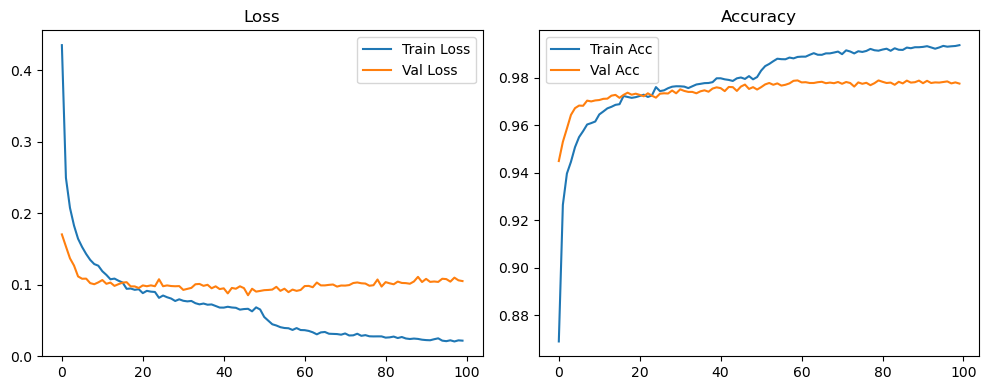

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2180, Acc: 0.9321 | Val Loss: 0.1335, Acc: 0.9590


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0970, Acc: 0.9700 | Val Loss: 0.1126, Acc: 0.9651


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0635, Acc: 0.9795 | Val Loss: 0.1258, Acc: 0.9623


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9841 | Val Loss: 0.1205, Acc: 0.9672


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9873 | Val Loss: 0.1146, Acc: 0.9695


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9899 | Val Loss: 0.1226, Acc: 0.9682


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.1140, Acc: 0.9707


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1267, Acc: 0.9700


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9937 | Val Loss: 0.1105, Acc: 0.9752


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9939 | Val Loss: 0.1165, Acc: 0.9735


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.1164, Acc: 0.9738


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1152, Acc: 0.9730


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1212, Acc: 0.9733


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1320, Acc: 0.9723


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1252, Acc: 0.9725


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1256, Acc: 0.9732


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1330, Acc: 0.9740


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1426, Acc: 0.9729


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1229, Acc: 0.9743


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1332, Acc: 0.9755


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1224, Acc: 0.9757


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1381, Acc: 0.9724


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1158, Acc: 0.9764


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1369, Acc: 0.9737


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1299, Acc: 0.9735


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1133, Acc: 0.9766


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1129, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1202, Acc: 0.9772


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1243, Acc: 0.9748


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1220, Acc: 0.9757


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9763


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1199, Acc: 0.9758


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1180, Acc: 0.9758


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1163, Acc: 0.9769


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1248, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1224, Acc: 0.9752


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1172, Acc: 0.9766


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1109, Acc: 0.9784


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1301, Acc: 0.9759


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1236, Acc: 0.9757


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1274, Acc: 0.9750


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1236, Acc: 0.9753


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1253, Acc: 0.9762


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1151, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.1067, Acc: 0.9783


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1303, Acc: 0.9762


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1595, Acc: 0.9716


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1235, Acc: 0.9767


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1242, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1280, Acc: 0.9785


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1226, Acc: 0.9752


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1183, Acc: 0.9772


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1321, Acc: 0.9759


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1370, Acc: 0.9750


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1443, Acc: 0.9756


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1307, Acc: 0.9763


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1368, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1366, Acc: 0.9769


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1142, Acc: 0.9769


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1388, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1449, Acc: 0.9766


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1415, Acc: 0.9775


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1252, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1270, Acc: 0.9780


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1323, Acc: 0.9757


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1281, Acc: 0.9748


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1239, Acc: 0.9772


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1264, Acc: 0.9774


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1466, Acc: 0.9758


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1243, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1408, Acc: 0.9751


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1324, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1388, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1333, Acc: 0.9761


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1288, Acc: 0.9756


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1346, Acc: 0.9782


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1499, Acc: 0.9761


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1333, Acc: 0.9744


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1285, Acc: 0.9778


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1281, Acc: 0.9763


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1379, Acc: 0.9749


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1331, Acc: 0.9779


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1387, Acc: 0.9768


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1206, Acc: 0.9781


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1139, Acc: 0.9781


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1283, Acc: 0.9778


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1168, Acc: 0.9783


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1377, Acc: 0.9773


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1416, Acc: 0.9757


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1342, Acc: 0.9763


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1239, Acc: 0.9746


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1382, Acc: 0.9764


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1335, Acc: 0.9756


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1405, Acc: 0.9767


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1374, Acc: 0.9764


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1519, Acc: 0.9758


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1363, Acc: 0.9767


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1238, Acc: 0.9778


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1378, Acc: 0.9791


Final Test Loss: 0.1273 Accuracy: 0.9811


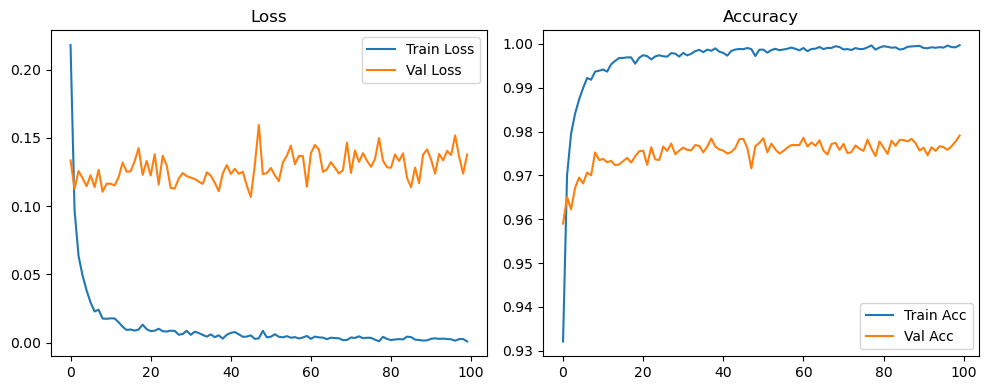

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2671, Acc: 0.9186 | Val Loss: 0.1320, Acc: 0.9603


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1375, Acc: 0.9574 | Val Loss: 0.1231, Acc: 0.9619


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1070, Acc: 0.9668 | Val Loss: 0.1036, Acc: 0.9678


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9745 | Val Loss: 0.1018, Acc: 0.9690


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9767 | Val Loss: 0.0979, Acc: 0.9719


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0613, Acc: 0.9806 | Val Loss: 0.1001, Acc: 0.9712


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9827 | Val Loss: 0.0946, Acc: 0.9734


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.0982, Acc: 0.9722


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0982, Acc: 0.9749


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.0860, Acc: 0.9771


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9748


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0955, Acc: 0.9748


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0960, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0947, Acc: 0.9761


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0984, Acc: 0.9747


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0903, Acc: 0.9770


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.0916, Acc: 0.9771


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0890, Acc: 0.9772


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.1032, Acc: 0.9763


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0952, Acc: 0.9777


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.0920, Acc: 0.9758


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1018, Acc: 0.9759


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9935 | Val Loss: 0.0998, Acc: 0.9755


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0911, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0958, Acc: 0.9757


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0967, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0882, Acc: 0.9786


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.1089, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1050, Acc: 0.9757


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1003, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1011, Acc: 0.9767


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0995, Acc: 0.9754


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0994, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1051, Acc: 0.9763


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1054, Acc: 0.9777


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1007, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1138, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1016, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0905, Acc: 0.9787


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0993, Acc: 0.9789


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0991, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1076, Acc: 0.9774


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1016, Acc: 0.9773


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1070, Acc: 0.9771


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0935, Acc: 0.9791


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1086, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1130, Acc: 0.9769


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0972, Acc: 0.9791


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0968, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1080, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1032, Acc: 0.9787


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0959, Acc: 0.9790


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0995, Acc: 0.9775


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1062, Acc: 0.9777


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1001, Acc: 0.9782


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1017, Acc: 0.9783


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1069, Acc: 0.9782


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1034, Acc: 0.9777


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1041, Acc: 0.9776


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1055, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1040, Acc: 0.9777


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1106, Acc: 0.9771


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.1083, Acc: 0.9777


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1048, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0991, Acc: 0.9779


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1090, Acc: 0.9786


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1036, Acc: 0.9779


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1118, Acc: 0.9772


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1047, Acc: 0.9795


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1018, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1013, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1173, Acc: 0.9784


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1012, Acc: 0.9785


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0913, Acc: 0.9808


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1006, Acc: 0.9799


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1004, Acc: 0.9783


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1054, Acc: 0.9783


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0998, Acc: 0.9781


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1066, Acc: 0.9786


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1050, Acc: 0.9778


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1085, Acc: 0.9777


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9784


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1040, Acc: 0.9804


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1136, Acc: 0.9793


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1101, Acc: 0.9783


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1140, Acc: 0.9792


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1266, Acc: 0.9779


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1107, Acc: 0.9795


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1195, Acc: 0.9790


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1122, Acc: 0.9798


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1205, Acc: 0.9787


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1188, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1214, Acc: 0.9785


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9979 | Val Loss: 0.1175, Acc: 0.9788


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1128, Acc: 0.9794


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1167, Acc: 0.9782


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1115, Acc: 0.9772


Final Test Loss: 0.1117 Accuracy: 0.9796


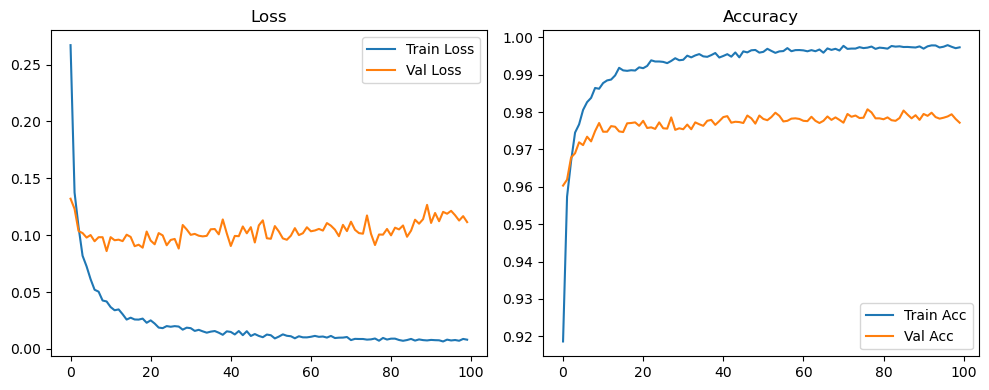

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4356, Acc: 0.8662 | Val Loss: 0.1768, Acc: 0.9469


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2509, Acc: 0.9265 | Val Loss: 0.1531, Acc: 0.9523


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2062, Acc: 0.9380 | Val Loss: 0.1263, Acc: 0.9604


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1790, Acc: 0.9473 | Val Loss: 0.1173, Acc: 0.9641


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1584, Acc: 0.9534 | Val Loss: 0.1087, Acc: 0.9673


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1455, Acc: 0.9559 | Val Loss: 0.1112, Acc: 0.9680


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1343, Acc: 0.9592 | Val Loss: 0.1050, Acc: 0.9693


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1254, Acc: 0.9615 | Val Loss: 0.0984, Acc: 0.9708


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1198, Acc: 0.9636 | Val Loss: 0.1001, Acc: 0.9698


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9656 | Val Loss: 0.0997, Acc: 0.9714


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1116, Acc: 0.9659 | Val Loss: 0.0961, Acc: 0.9733


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1043, Acc: 0.9679 | Val Loss: 0.1002, Acc: 0.9710


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1033, Acc: 0.9686 | Val Loss: 0.0989, Acc: 0.9722


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0997, Acc: 0.9694 | Val Loss: 0.0934, Acc: 0.9732


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0945, Acc: 0.9716 | Val Loss: 0.0979, Acc: 0.9722


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0939, Acc: 0.9709 | Val Loss: 0.0959, Acc: 0.9722


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9728 | Val Loss: 0.0947, Acc: 0.9734


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0868, Acc: 0.9735 | Val Loss: 0.0950, Acc: 0.9749


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0848, Acc: 0.9734 | Val Loss: 0.0943, Acc: 0.9733


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.0923, Acc: 0.9747


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0836, Acc: 0.9738 | Val Loss: 0.0949, Acc: 0.9738


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0796, Acc: 0.9756 | Val Loss: 0.0957, Acc: 0.9743


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0782, Acc: 0.9751 | Val Loss: 0.0980, Acc: 0.9743


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9762 | Val Loss: 0.0980, Acc: 0.9742


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0751, Acc: 0.9766 | Val Loss: 0.0961, Acc: 0.9747


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0722, Acc: 0.9776 | Val Loss: 0.0957, Acc: 0.9748


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9770 | Val Loss: 0.0970, Acc: 0.9757


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0687, Acc: 0.9787 | Val Loss: 0.0977, Acc: 0.9745


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0673, Acc: 0.9793 | Val Loss: 0.0952, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0660, Acc: 0.9790 | Val Loss: 0.0960, Acc: 0.9758


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0664, Acc: 0.9795 | Val Loss: 0.0926, Acc: 0.9762


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9791 | Val Loss: 0.0912, Acc: 0.9758


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0672, Acc: 0.9795 | Val Loss: 0.0921, Acc: 0.9766


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9808 | Val Loss: 0.0960, Acc: 0.9747


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9814 | Val Loss: 0.0987, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9807 | Val Loss: 0.0966, Acc: 0.9745


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9812 | Val Loss: 0.0937, Acc: 0.9751


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0601, Acc: 0.9814 | Val Loss: 0.0943, Acc: 0.9758


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9807 | Val Loss: 0.0975, Acc: 0.9758


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9819 | Val Loss: 0.0944, Acc: 0.9757


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9823 | Val Loss: 0.0954, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0574, Acc: 0.9826 | Val Loss: 0.0945, Acc: 0.9758


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0925, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9824 | Val Loss: 0.0935, Acc: 0.9771


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9822 | Val Loss: 0.0984, Acc: 0.9769


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0576, Acc: 0.9815 | Val Loss: 0.0968, Acc: 0.9757


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9837 | Val Loss: 0.0970, Acc: 0.9755


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.1004, Acc: 0.9752


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9830 | Val Loss: 0.0994, Acc: 0.9759


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9842 | Val Loss: 0.1001, Acc: 0.9756


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9840 | Val Loss: 0.0978, Acc: 0.9770


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0948, Acc: 0.9764


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9852 | Val Loss: 0.0978, Acc: 0.9761


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.1007, Acc: 0.9748


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9845 | Val Loss: 0.1003, Acc: 0.9752


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9842 | Val Loss: 0.0994, Acc: 0.9745


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9846 | Val Loss: 0.0996, Acc: 0.9764


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9851 | Val Loss: 0.0917, Acc: 0.9765


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9841 | Val Loss: 0.0946, Acc: 0.9773


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9853 | Val Loss: 0.0973, Acc: 0.9748


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0997, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.0995, Acc: 0.9770


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0448, Acc: 0.9861 | Val Loss: 0.0992, Acc: 0.9761


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9852 | Val Loss: 0.0998, Acc: 0.9768


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9867 | Val Loss: 0.1168, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9850 | Val Loss: 0.1012, Acc: 0.9757


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9856 | Val Loss: 0.1016, Acc: 0.9747


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9848 | Val Loss: 0.0996, Acc: 0.9755


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.1013, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9863 | Val Loss: 0.0983, Acc: 0.9748


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0975, Acc: 0.9759


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9855 | Val Loss: 0.0980, Acc: 0.9760


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9863 | Val Loss: 0.1031, Acc: 0.9753


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9869 | Val Loss: 0.0983, Acc: 0.9757


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.1065, Acc: 0.9752


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9870 | Val Loss: 0.1050, Acc: 0.9764


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9864 | Val Loss: 0.0967, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9876 | Val Loss: 0.0993, Acc: 0.9758


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.0939, Acc: 0.9768


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.0982, Acc: 0.9764


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9877 | Val Loss: 0.0971, Acc: 0.9758


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.1041, Acc: 0.9761


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.1000, Acc: 0.9762


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9878 | Val Loss: 0.1046, Acc: 0.9763


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.0988, Acc: 0.9758


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.1084, Acc: 0.9764


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.0970, Acc: 0.9765


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9867 | Val Loss: 0.1003, Acc: 0.9774


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.1030, Acc: 0.9758


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9883 | Val Loss: 0.0951, Acc: 0.9755


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.1019, Acc: 0.9758


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.0997, Acc: 0.9750


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.0975, Acc: 0.9763


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.1012, Acc: 0.9755


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.1018, Acc: 0.9763


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.1027, Acc: 0.9763


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.1034, Acc: 0.9754


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.1048, Acc: 0.9752


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.1049, Acc: 0.9771


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.1011, Acc: 0.9770


Final Test Loss: 0.0874 Accuracy: 0.9794


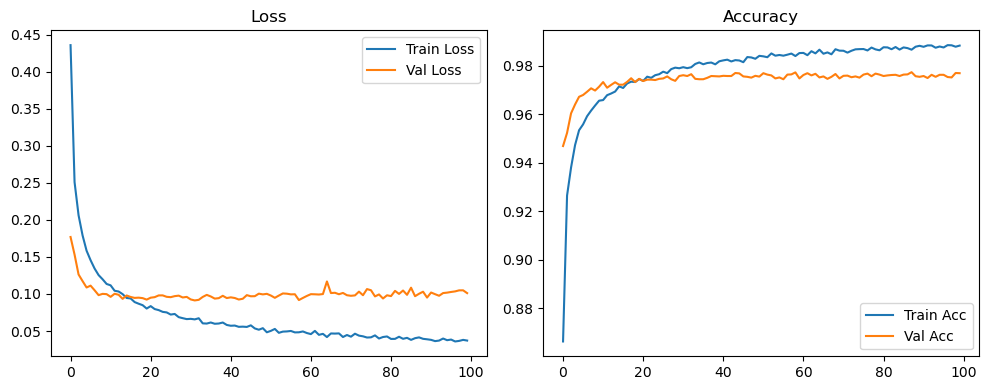

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2180, Acc: 0.9321 | Val Loss: 0.1335, Acc: 0.9590


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9696 | Val Loss: 0.1138, Acc: 0.9651


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0637, Acc: 0.9798 | Val Loss: 0.1222, Acc: 0.9640


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9841 | Val Loss: 0.1155, Acc: 0.9673


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9880 | Val Loss: 0.1078, Acc: 0.9712


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9898 | Val Loss: 0.1087, Acc: 0.9701


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.1078, Acc: 0.9719


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1350, Acc: 0.9681


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.1033, Acc: 0.9755


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1187, Acc: 0.9741


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1269, Acc: 0.9714


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.1194, Acc: 0.9727


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9946 | Val Loss: 0.1320, Acc: 0.9711


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1209, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1237, Acc: 0.9757


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1512, Acc: 0.9696


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1192, Acc: 0.9754


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1353, Acc: 0.9745


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1286, Acc: 0.9734


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1208, Acc: 0.9736


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1294, Acc: 0.9747


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9970 | Val Loss: 0.1211, Acc: 0.9759


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1263, Acc: 0.9746


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1165, Acc: 0.9759


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1291, Acc: 0.9735


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1234, Acc: 0.9733


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1208, Acc: 0.9748


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1207, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1232, Acc: 0.9762


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1258, Acc: 0.9762


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1127, Acc: 0.9769


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1257, Acc: 0.9748


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1127, Acc: 0.9778


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1251, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1283, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1256, Acc: 0.9766


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1250, Acc: 0.9742


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1294, Acc: 0.9748


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1297, Acc: 0.9762


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1197, Acc: 0.9775


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1314, Acc: 0.9752


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1256, Acc: 0.9765


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1218, Acc: 0.9749


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1377, Acc: 0.9748


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1194, Acc: 0.9757


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1249, Acc: 0.9754


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1323, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1413, Acc: 0.9737


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1386, Acc: 0.9748


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1363, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1169, Acc: 0.9793


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1145, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1207, Acc: 0.9800


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1209, Acc: 0.9796


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1220, Acc: 0.9790


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1218, Acc: 0.9805


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1218, Acc: 0.9801


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1262, Acc: 0.9799


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1261, Acc: 0.9798


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1300, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1331, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1345, Acc: 0.9799


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1294, Acc: 0.9789


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1302, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1303, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1287, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1389, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1421, Acc: 0.9778


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1494, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1370, Acc: 0.9779


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1494, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1393, Acc: 0.9779


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1437, Acc: 0.9790


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1444, Acc: 0.9787


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1529, Acc: 0.9769


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1439, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1493, Acc: 0.9776


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1484, Acc: 0.9789


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1505, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1579, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1537, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1527, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1541, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1524, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1569, Acc: 0.9794


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1593, Acc: 0.9786


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1573, Acc: 0.9786


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1567, Acc: 0.9793


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1592, Acc: 0.9785


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1565, Acc: 0.9791


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1608, Acc: 0.9788


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1617, Acc: 0.9783


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1586, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1582, Acc: 0.9790


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1577, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1539, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1527, Acc: 0.9800


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1563, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1581, Acc: 0.9792


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1597, Acc: 0.9795


Final Test Loss: 0.1511 Accuracy: 0.9798


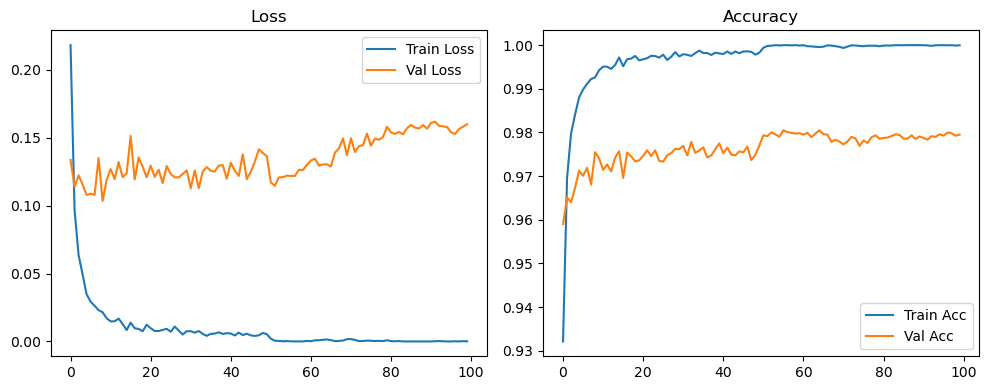

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2671, Acc: 0.9186 | Val Loss: 0.1320, Acc: 0.9603


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1375, Acc: 0.9574 | Val Loss: 0.1231, Acc: 0.9619


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1070, Acc: 0.9668 | Val Loss: 0.1036, Acc: 0.9678


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9745 | Val Loss: 0.1018, Acc: 0.9690


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9767 | Val Loss: 0.0979, Acc: 0.9719


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0613, Acc: 0.9806 | Val Loss: 0.1001, Acc: 0.9712


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9827 | Val Loss: 0.0946, Acc: 0.9734


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.0982, Acc: 0.9722


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.0982, Acc: 0.9749


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9862 | Val Loss: 0.0860, Acc: 0.9771


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9878 | Val Loss: 0.0982, Acc: 0.9748


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0955, Acc: 0.9748


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0960, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0947, Acc: 0.9761


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.1004, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0984, Acc: 0.9747


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0903, Acc: 0.9770


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.0916, Acc: 0.9771


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0890, Acc: 0.9772


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.1032, Acc: 0.9763


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0952, Acc: 0.9777


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.0920, Acc: 0.9758


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1018, Acc: 0.9759


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9935 | Val Loss: 0.0998, Acc: 0.9755


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0911, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0958, Acc: 0.9757


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9931 | Val Loss: 0.0967, Acc: 0.9756


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0882, Acc: 0.9786


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.1089, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.1050, Acc: 0.9757


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1003, Acc: 0.9754


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1011, Acc: 0.9767


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.0995, Acc: 0.9754


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0989, Acc: 0.9772


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0994, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1051, Acc: 0.9763


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1054, Acc: 0.9777


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1007, Acc: 0.9779


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1138, Acc: 0.9766


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1016, Acc: 0.9776


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0905, Acc: 0.9787


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0993, Acc: 0.9789


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0991, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1076, Acc: 0.9774


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1016, Acc: 0.9773


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1070, Acc: 0.9771


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0935, Acc: 0.9791


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1086, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1130, Acc: 0.9769


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0972, Acc: 0.9791


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0953, Acc: 0.9818


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0997, Acc: 0.9811


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1033, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1072, Acc: 0.9799


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1032, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1024, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1030, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1019, Acc: 0.9820


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1118, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1045, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1096, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1123, Acc: 0.9809


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1099, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1150, Acc: 0.9807


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1128, Acc: 0.9806


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1173, Acc: 0.9802


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1097, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1128, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9805


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1052, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1034, Acc: 0.9806


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1086, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1076, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1097, Acc: 0.9804


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1068, Acc: 0.9805


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1090, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1091, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1104, Acc: 0.9796


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1048, Acc: 0.9805


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1051, Acc: 0.9797


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1079, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1054, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1110, Acc: 0.9809


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1099, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1116, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1137, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1141, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1135, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1166, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1113, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1161, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1151, Acc: 0.9796


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1175, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1149, Acc: 0.9807


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1176, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1178, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1204, Acc: 0.9794


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1215, Acc: 0.9804


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9800


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1218, Acc: 0.9812


Final Test Loss: 0.1205 Accuracy: 0.9820


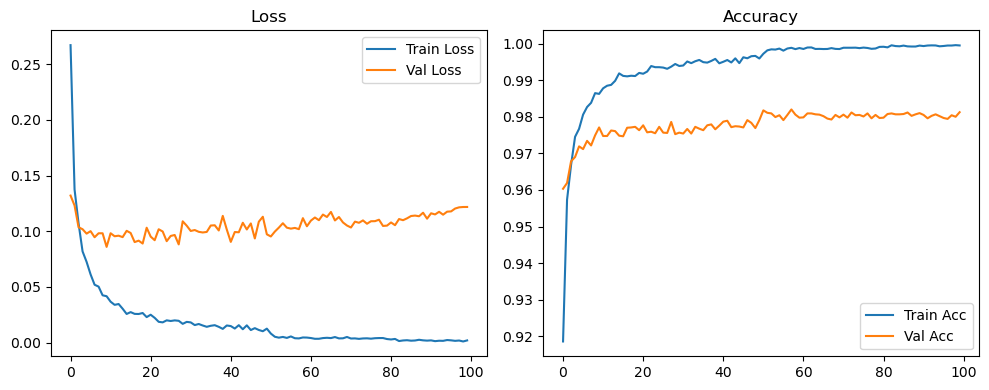

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4357, Acc: 0.8671 | Val Loss: 0.1789, Acc: 0.9463


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2500, Acc: 0.9267 | Val Loss: 0.1525, Acc: 0.9534


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2078, Acc: 0.9381 | Val Loss: 0.1278, Acc: 0.9604


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1757, Acc: 0.9477 | Val Loss: 0.1179, Acc: 0.9645


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1598, Acc: 0.9502 | Val Loss: 0.1095, Acc: 0.9652


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1469, Acc: 0.9563 | Val Loss: 0.1066, Acc: 0.9680


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1311, Acc: 0.9601 | Val Loss: 0.1065, Acc: 0.9695


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1255, Acc: 0.9623 | Val Loss: 0.1037, Acc: 0.9699


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1196, Acc: 0.9633 | Val Loss: 0.0993, Acc: 0.9711


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1164, Acc: 0.9638 | Val Loss: 0.0979, Acc: 0.9714


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1100, Acc: 0.9660 | Val Loss: 0.0942, Acc: 0.9738


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0993, Acc: 0.9696 | Val Loss: 0.0949, Acc: 0.9725


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0979, Acc: 0.9701 | Val Loss: 0.0996, Acc: 0.9717


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0971, Acc: 0.9705 | Val Loss: 0.0945, Acc: 0.9735


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9713 | Val Loss: 0.0935, Acc: 0.9738


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0892, Acc: 0.9731 | Val Loss: 0.0981, Acc: 0.9714


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0879, Acc: 0.9728 | Val Loss: 0.0989, Acc: 0.9708


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0863, Acc: 0.9734 | Val Loss: 0.0958, Acc: 0.9735


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0849, Acc: 0.9733 | Val Loss: 0.0986, Acc: 0.9731


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0806, Acc: 0.9756 | Val Loss: 0.0992, Acc: 0.9728


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0812, Acc: 0.9751 | Val Loss: 0.0940, Acc: 0.9745


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9745 | Val Loss: 0.0950, Acc: 0.9728


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9763 | Val Loss: 0.0948, Acc: 0.9741


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0763, Acc: 0.9764 | Val Loss: 0.0967, Acc: 0.9738


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9771 | Val Loss: 0.0968, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9771 | Val Loss: 0.0934, Acc: 0.9750


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0727, Acc: 0.9774 | Val Loss: 0.0907, Acc: 0.9738


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9803 | Val Loss: 0.0921, Acc: 0.9746


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9786 | Val Loss: 0.0957, Acc: 0.9746


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9797 | Val Loss: 0.0908, Acc: 0.9748


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9791 | Val Loss: 0.0946, Acc: 0.9744


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0937, Acc: 0.9747


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9796 | Val Loss: 0.0918, Acc: 0.9738


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9798 | Val Loss: 0.0901, Acc: 0.9751


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9805 | Val Loss: 0.0985, Acc: 0.9744


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9813 | Val Loss: 0.0979, Acc: 0.9761


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9804 | Val Loss: 0.0954, Acc: 0.9762


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.0916, Acc: 0.9746


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9817 | Val Loss: 0.0971, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9829 | Val Loss: 0.0943, Acc: 0.9760


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9823 | Val Loss: 0.0941, Acc: 0.9752


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0567, Acc: 0.9826 | Val Loss: 0.0924, Acc: 0.9754


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9829 | Val Loss: 0.0899, Acc: 0.9759


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9827 | Val Loss: 0.0921, Acc: 0.9770


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9833 | Val Loss: 0.0924, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9827 | Val Loss: 0.0930, Acc: 0.9768


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0547, Acc: 0.9821 | Val Loss: 0.0972, Acc: 0.9755


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9834 | Val Loss: 0.1007, Acc: 0.9754


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.0942, Acc: 0.9776


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9830 | Val Loss: 0.1059, Acc: 0.9750


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9866 | Val Loss: 0.0992, Acc: 0.9766


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9875 | Val Loss: 0.0991, Acc: 0.9760


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.1039, Acc: 0.9760


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9897 | Val Loss: 0.1073, Acc: 0.9754


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.1025, Acc: 0.9760


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.0994, Acc: 0.9762


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9891 | Val Loss: 0.0987, Acc: 0.9773


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.1017, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9902 | Val Loss: 0.1033, Acc: 0.9776


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9899 | Val Loss: 0.0994, Acc: 0.9770


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.1052, Acc: 0.9769


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.1012, Acc: 0.9763


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9909 | Val Loss: 0.0995, Acc: 0.9782


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9907 | Val Loss: 0.1028, Acc: 0.9772


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.1055, Acc: 0.9762


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1055, Acc: 0.9768


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9909 | Val Loss: 0.1078, Acc: 0.9764


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9904 | Val Loss: 0.1027, Acc: 0.9762


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9917 | Val Loss: 0.1042, Acc: 0.9756


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.1060, Acc: 0.9758


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9911 | Val Loss: 0.1081, Acc: 0.9767


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.1097, Acc: 0.9773


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1087, Acc: 0.9772


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.1066, Acc: 0.9767


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.1093, Acc: 0.9765


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.1110, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.1086, Acc: 0.9768


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.1099, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1069, Acc: 0.9776


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.1084, Acc: 0.9774


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9926 | Val Loss: 0.1083, Acc: 0.9764


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.1089, Acc: 0.9771


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.1104, Acc: 0.9772


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.1089, Acc: 0.9775


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.1133, Acc: 0.9758


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9939 | Val Loss: 0.1140, Acc: 0.9765


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.1097, Acc: 0.9771


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9935 | Val Loss: 0.1095, Acc: 0.9769


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1146, Acc: 0.9773


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.1123, Acc: 0.9761


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1189, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.1157, Acc: 0.9763


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1147, Acc: 0.9767


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.1133, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.1139, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1190, Acc: 0.9769


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1179, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9941 | Val Loss: 0.1179, Acc: 0.9760


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.1162, Acc: 0.9770


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.1160, Acc: 0.9759


Final Test Loss: 0.0976 Accuracy: 0.9806


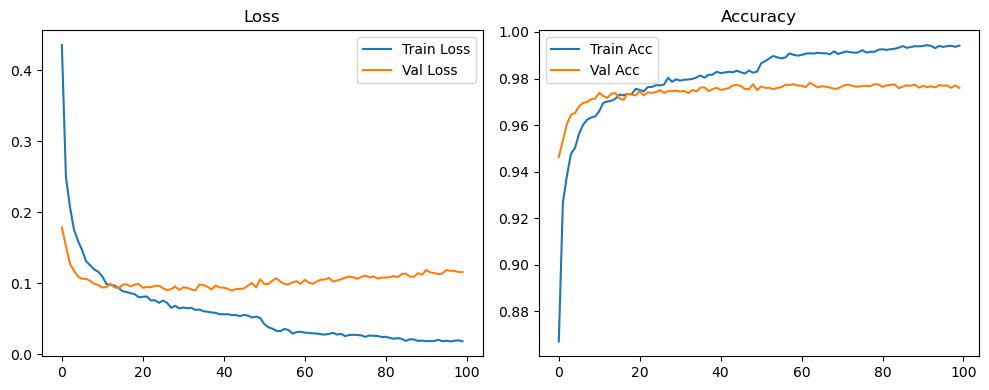

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2281, Acc: 0.9317 | Val Loss: 0.1301, Acc: 0.9593


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0893, Acc: 0.9726 | Val Loss: 0.1076, Acc: 0.9665


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9812 | Val Loss: 0.1152, Acc: 0.9652


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1110, Acc: 0.9663


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.1015, Acc: 0.9724


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.1068, Acc: 0.9720


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.1002, Acc: 0.9738


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.1233, Acc: 0.9688


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.1126, Acc: 0.9717


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1150, Acc: 0.9715


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1299, Acc: 0.9688


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1148, Acc: 0.9723


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.1229, Acc: 0.9733


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.1165, Acc: 0.9742


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1250, Acc: 0.9733


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1275, Acc: 0.9724


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1133, Acc: 0.9748


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1289, Acc: 0.9737


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1236, Acc: 0.9732


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1177, Acc: 0.9738


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1047, Acc: 0.9760


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1117, Acc: 0.9747


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1052, Acc: 0.9757


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9717


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1264, Acc: 0.9718


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9746


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1233, Acc: 0.9743


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1214, Acc: 0.9749


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1217, Acc: 0.9758


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1275, Acc: 0.9749


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1255, Acc: 0.9742


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1208, Acc: 0.9753


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1255, Acc: 0.9748


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1193, Acc: 0.9755


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1131, Acc: 0.9782


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1372, Acc: 0.9743


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1427, Acc: 0.9733


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1504, Acc: 0.9730


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1238, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1332, Acc: 0.9757


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1177, Acc: 0.9775


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1307, Acc: 0.9757


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1311, Acc: 0.9752


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1265, Acc: 0.9758


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1347, Acc: 0.9732


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1282, Acc: 0.9758


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1268, Acc: 0.9768


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1354, Acc: 0.9760


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1338, Acc: 0.9771


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1334, Acc: 0.9759


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1505, Acc: 0.9754


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1393, Acc: 0.9758


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1273, Acc: 0.9771


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1294, Acc: 0.9772


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1267, Acc: 0.9768


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1228, Acc: 0.9779


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1194, Acc: 0.9786


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1218, Acc: 0.9782


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1184, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1153, Acc: 0.9777


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1216, Acc: 0.9782


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1457, Acc: 0.9752


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1430, Acc: 0.9738


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1505, Acc: 0.9719


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1418, Acc: 0.9758


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1287, Acc: 0.9778


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1302, Acc: 0.9768


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1262, Acc: 0.9771


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1260, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1319, Acc: 0.9777


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1339, Acc: 0.9763


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1419, Acc: 0.9763


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1423, Acc: 0.9757


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1396, Acc: 0.9772


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1358, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1410, Acc: 0.9763


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1390, Acc: 0.9766


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1408, Acc: 0.9764


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1406, Acc: 0.9774


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1386, Acc: 0.9773


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1371, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1480, Acc: 0.9778


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1443, Acc: 0.9761


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1481, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1412, Acc: 0.9767


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1459, Acc: 0.9766


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1392, Acc: 0.9768


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1362, Acc: 0.9771


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1354, Acc: 0.9781


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1309, Acc: 0.9784


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1376, Acc: 0.9780


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1430, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1440, Acc: 0.9747


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1445, Acc: 0.9768


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1410, Acc: 0.9768


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1396, Acc: 0.9779


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1417, Acc: 0.9775


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1415, Acc: 0.9761


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1399, Acc: 0.9775


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1472, Acc: 0.9769


Final Test Loss: 0.1414 Accuracy: 0.9786


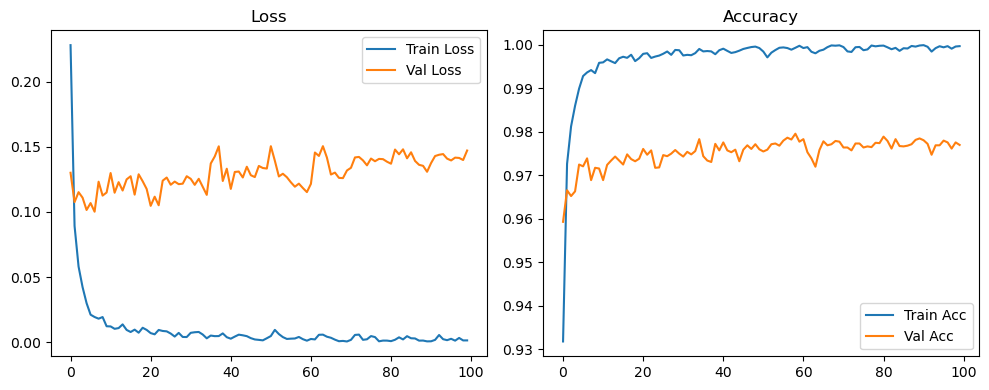

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2936, Acc: 0.9125 | Val Loss: 0.1419, Acc: 0.9554


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1380, Acc: 0.9571 | Val Loss: 0.1176, Acc: 0.9649


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1061, Acc: 0.9668 | Val Loss: 0.1046, Acc: 0.9668


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0837, Acc: 0.9731 | Val Loss: 0.1016, Acc: 0.9695


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0704, Acc: 0.9767 | Val Loss: 0.0957, Acc: 0.9721


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0613, Acc: 0.9798 | Val Loss: 0.0974, Acc: 0.9719


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0544, Acc: 0.9822 | Val Loss: 0.0951, Acc: 0.9732


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9840 | Val Loss: 0.0950, Acc: 0.9711


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9864 | Val Loss: 0.0918, Acc: 0.9735


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9877 | Val Loss: 0.0948, Acc: 0.9750


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.1025, Acc: 0.9719


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9887 | Val Loss: 0.0936, Acc: 0.9740


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9894 | Val Loss: 0.0923, Acc: 0.9749


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9902 | Val Loss: 0.0977, Acc: 0.9742


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9899 | Val Loss: 0.0987, Acc: 0.9752


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0937, Acc: 0.9749


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0927, Acc: 0.9757


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0954, Acc: 0.9759


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9926 | Val Loss: 0.0954, Acc: 0.9763


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0975, Acc: 0.9752


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9924 | Val Loss: 0.0936, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0952, Acc: 0.9758


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0920, Acc: 0.9788


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1080, Acc: 0.9746


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.1004, Acc: 0.9762


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0998, Acc: 0.9757


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.1067, Acc: 0.9758


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1042, Acc: 0.9762


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1053, Acc: 0.9759


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9946 | Val Loss: 0.1053, Acc: 0.9761


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1090, Acc: 0.9761


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0987, Acc: 0.9768


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0993, Acc: 0.9778


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1062, Acc: 0.9769


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1071, Acc: 0.9771


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1039, Acc: 0.9768


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.1093, Acc: 0.9772


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1026, Acc: 0.9782


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1082, Acc: 0.9765


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1050, Acc: 0.9758


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1044, Acc: 0.9779


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1080, Acc: 0.9769


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1054, Acc: 0.9768


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1080, Acc: 0.9767


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1081, Acc: 0.9780


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.1038, Acc: 0.9782


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1072, Acc: 0.9788


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1084, Acc: 0.9773


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1045, Acc: 0.9785


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1085, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1018, Acc: 0.9775


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0984, Acc: 0.9779


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1071, Acc: 0.9779


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1047, Acc: 0.9780


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1045, Acc: 0.9779


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1093, Acc: 0.9780


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9790


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1043, Acc: 0.9772


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1040, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1080, Acc: 0.9787


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1026, Acc: 0.9789


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1073, Acc: 0.9768


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1056, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1103, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1079, Acc: 0.9775


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1024, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1019, Acc: 0.9787


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1036, Acc: 0.9785


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0982, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1084, Acc: 0.9760


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1059, Acc: 0.9784


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1141, Acc: 0.9778


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1011, Acc: 0.9791


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0997, Acc: 0.9799


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1010, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0965, Acc: 0.9804


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0985, Acc: 0.9800


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1083, Acc: 0.9785


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0964, Acc: 0.9808


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0996, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1097, Acc: 0.9779


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1030, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1065, Acc: 0.9798


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1066, Acc: 0.9795


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1038, Acc: 0.9798


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1039, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1234, Acc: 0.9778


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1087, Acc: 0.9767


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0983, Acc: 0.9788


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1092, Acc: 0.9785


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1079, Acc: 0.9787


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1081, Acc: 0.9792


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.1077, Acc: 0.9788


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1035, Acc: 0.9801


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1018, Acc: 0.9799


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1063, Acc: 0.9800


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1056, Acc: 0.9794


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1041, Acc: 0.9792


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1012, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1072, Acc: 0.9784


Final Test Loss: 0.0940 Accuracy: 0.9813


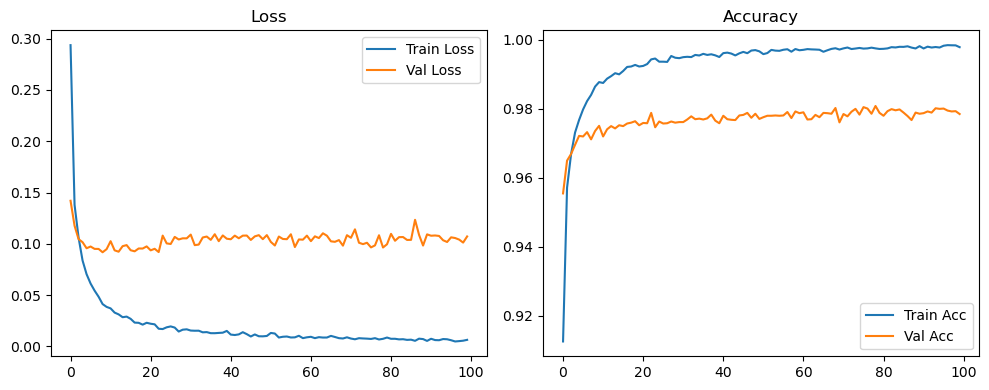

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5066, Acc: 0.8476 | Val Loss: 0.1852, Acc: 0.9449


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2610, Acc: 0.9220 | Val Loss: 0.1624, Acc: 0.9497


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2129, Acc: 0.9367 | Val Loss: 0.1352, Acc: 0.9588


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1857, Acc: 0.9444 | Val Loss: 0.1251, Acc: 0.9629


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1664, Acc: 0.9503 | Val Loss: 0.1151, Acc: 0.9653


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1515, Acc: 0.9548 | Val Loss: 0.1083, Acc: 0.9668


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1397, Acc: 0.9574 | Val Loss: 0.1112, Acc: 0.9673


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1322, Acc: 0.9595 | Val Loss: 0.0982, Acc: 0.9698


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1207, Acc: 0.9635 | Val Loss: 0.0989, Acc: 0.9707


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1176, Acc: 0.9634 | Val Loss: 0.0975, Acc: 0.9715


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1139, Acc: 0.9653 | Val Loss: 0.0914, Acc: 0.9731


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1044, Acc: 0.9681 | Val Loss: 0.0907, Acc: 0.9740


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0980, Acc: 0.9697 | Val Loss: 0.0888, Acc: 0.9738


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0989, Acc: 0.9695 | Val Loss: 0.0929, Acc: 0.9738


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0921, Acc: 0.9724 | Val Loss: 0.0905, Acc: 0.9750


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0886, Acc: 0.9722 | Val Loss: 0.0892, Acc: 0.9747


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0830, Acc: 0.9739 | Val Loss: 0.0931, Acc: 0.9735


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9736 | Val Loss: 0.0875, Acc: 0.9754


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0838, Acc: 0.9731 | Val Loss: 0.0870, Acc: 0.9760


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0779, Acc: 0.9754 | Val Loss: 0.0885, Acc: 0.9762


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0772, Acc: 0.9758 | Val Loss: 0.0903, Acc: 0.9751


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9761 | Val Loss: 0.0917, Acc: 0.9758


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0771, Acc: 0.9752 | Val Loss: 0.0920, Acc: 0.9743


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9775 | Val Loss: 0.0914, Acc: 0.9749


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9778 | Val Loss: 0.0918, Acc: 0.9752


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9776 | Val Loss: 0.0864, Acc: 0.9750


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0683, Acc: 0.9779 | Val Loss: 0.0878, Acc: 0.9769


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0650, Acc: 0.9791 | Val Loss: 0.0872, Acc: 0.9761


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0621, Acc: 0.9803 | Val Loss: 0.0940, Acc: 0.9756


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0611, Acc: 0.9817 | Val Loss: 0.0906, Acc: 0.9761


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9803 | Val Loss: 0.0897, Acc: 0.9762


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0616, Acc: 0.9809 | Val Loss: 0.0872, Acc: 0.9763


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9804 | Val Loss: 0.0840, Acc: 0.9777


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9822 | Val Loss: 0.0917, Acc: 0.9762


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0540, Acc: 0.9824 | Val Loss: 0.0930, Acc: 0.9758


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9824 | Val Loss: 0.0922, Acc: 0.9755


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0937, Acc: 0.9751


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9825 | Val Loss: 0.0898, Acc: 0.9759


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9822 | Val Loss: 0.0927, Acc: 0.9766


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9830 | Val Loss: 0.0934, Acc: 0.9773


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0930, Acc: 0.9770


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.0958, Acc: 0.9763


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0913, Acc: 0.9770


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9842 | Val Loss: 0.0956, Acc: 0.9768


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0502, Acc: 0.9844 | Val Loss: 0.0912, Acc: 0.9760


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9843 | Val Loss: 0.0919, Acc: 0.9764


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.0941, Acc: 0.9757


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9846 | Val Loss: 0.0972, Acc: 0.9761


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9846 | Val Loss: 0.0904, Acc: 0.9766


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.0899, Acc: 0.9771


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0909, Acc: 0.9775


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.0926, Acc: 0.9776


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9855 | Val Loss: 0.0954, Acc: 0.9768


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.0991, Acc: 0.9750


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9849 | Val Loss: 0.0981, Acc: 0.9751


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.0972, Acc: 0.9759


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.0939, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9871 | Val Loss: 0.0959, Acc: 0.9761


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.0955, Acc: 0.9772


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.0977, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.1022, Acc: 0.9747


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0975, Acc: 0.9760


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0970, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0991, Acc: 0.9760


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9884 | Val Loss: 0.0984, Acc: 0.9772


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9866 | Val Loss: 0.0978, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9872 | Val Loss: 0.0948, Acc: 0.9772


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0983, Acc: 0.9769


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.0970, Acc: 0.9767


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9875 | Val Loss: 0.0999, Acc: 0.9767


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.0971, Acc: 0.9778


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.1031, Acc: 0.9762


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9875 | Val Loss: 0.0969, Acc: 0.9756


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9886 | Val Loss: 0.1008, Acc: 0.9763


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.0981, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0927, Acc: 0.9776


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9894 | Val Loss: 0.0928, Acc: 0.9775


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.1002, Acc: 0.9768


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.0949, Acc: 0.9774


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9878 | Val Loss: 0.0942, Acc: 0.9767


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9887 | Val Loss: 0.0986, Acc: 0.9768


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1006, Acc: 0.9770


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9891 | Val Loss: 0.0943, Acc: 0.9785


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9892 | Val Loss: 0.0977, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.1008, Acc: 0.9773


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9880 | Val Loss: 0.1001, Acc: 0.9762


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 0.0965, Acc: 0.9784


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0998, Acc: 0.9775


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9895 | Val Loss: 0.0995, Acc: 0.9770


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0977, Acc: 0.9771


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1070, Acc: 0.9772


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.1012, Acc: 0.9766


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9900 | Val Loss: 0.1018, Acc: 0.9769


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.1024, Acc: 0.9773


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0313, Acc: 0.9896 | Val Loss: 0.1021, Acc: 0.9784


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9900 | Val Loss: 0.1005, Acc: 0.9780


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.1022, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.1036, Acc: 0.9779


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.1043, Acc: 0.9772


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9897 | Val Loss: 0.1002, Acc: 0.9763


Final Test Loss: 0.0886 Accuracy: 0.9805


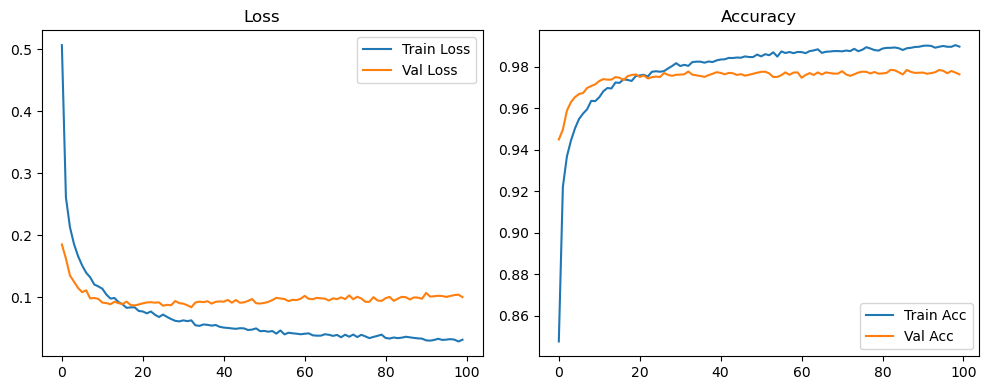

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2609, Acc: 0.9259 | Val Loss: 0.1328, Acc: 0.9597


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0870, Acc: 0.9735 | Val Loss: 0.1084, Acc: 0.9657


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.1137, Acc: 0.9659


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.1165, Acc: 0.9671


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.1002, Acc: 0.9712


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.1111, Acc: 0.9709


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1021, Acc: 0.9711


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.1248, Acc: 0.9680


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1053, Acc: 0.9727


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1122, Acc: 0.9713


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1136, Acc: 0.9720


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1062, Acc: 0.9738


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1215, Acc: 0.9707


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1136, Acc: 0.9748


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1077, Acc: 0.9751


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9972 | Val Loss: 0.1140, Acc: 0.9739


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1238, Acc: 0.9719


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1131, Acc: 0.9734


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1099, Acc: 0.9742


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1241, Acc: 0.9711


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.1119, Acc: 0.9738


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1165, Acc: 0.9746


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1122, Acc: 0.9744


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1159, Acc: 0.9738


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1197, Acc: 0.9740


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1202, Acc: 0.9739


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1239, Acc: 0.9749


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1193, Acc: 0.9761


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1263, Acc: 0.9736


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1388, Acc: 0.9717


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1213, Acc: 0.9748


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9717


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1277, Acc: 0.9748


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1282, Acc: 0.9748


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1156, Acc: 0.9766


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1210, Acc: 0.9766


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1205, Acc: 0.9763


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9743


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1495, Acc: 0.9715


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1487, Acc: 0.9721


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1184, Acc: 0.9749


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1150, Acc: 0.9775


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1054, Acc: 0.9789


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1100, Acc: 0.9789


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1112, Acc: 0.9781


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1113, Acc: 0.9785


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9765


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1254, Acc: 0.9752


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1318, Acc: 0.9738


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1344, Acc: 0.9747


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.1230, Acc: 0.9764


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1289, Acc: 0.9748


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1309, Acc: 0.9757


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1286, Acc: 0.9748


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1291, Acc: 0.9762


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1352, Acc: 0.9756


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1529, Acc: 0.9722


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1252, Acc: 0.9767


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1216, Acc: 0.9778


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1254, Acc: 0.9755


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1138, Acc: 0.9788


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1268, Acc: 0.9785


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1209, Acc: 0.9786


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1278, Acc: 0.9782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1265, Acc: 0.9769


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1350, Acc: 0.9747


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1264, Acc: 0.9763


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1258, Acc: 0.9759


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1275, Acc: 0.9768


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1315, Acc: 0.9748


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1350, Acc: 0.9758


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1234, Acc: 0.9779


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1192, Acc: 0.9785


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1209, Acc: 0.9789


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1207, Acc: 0.9796


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1234, Acc: 0.9777


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1438, Acc: 0.9743


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1284, Acc: 0.9760


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1285, Acc: 0.9761


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1218, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1181, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1237, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1190, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1257, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1399, Acc: 0.9752


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1396, Acc: 0.9741


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1287, Acc: 0.9767


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1230, Acc: 0.9780


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1294, Acc: 0.9762


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1213, Acc: 0.9787


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1260, Acc: 0.9786


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1292, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1334, Acc: 0.9760


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1369, Acc: 0.9764


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1344, Acc: 0.9756


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1360, Acc: 0.9762


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.1272, Acc: 0.9781


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1210, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1243, Acc: 0.9793


Final Test Loss: 0.1094 Accuracy: 0.9809


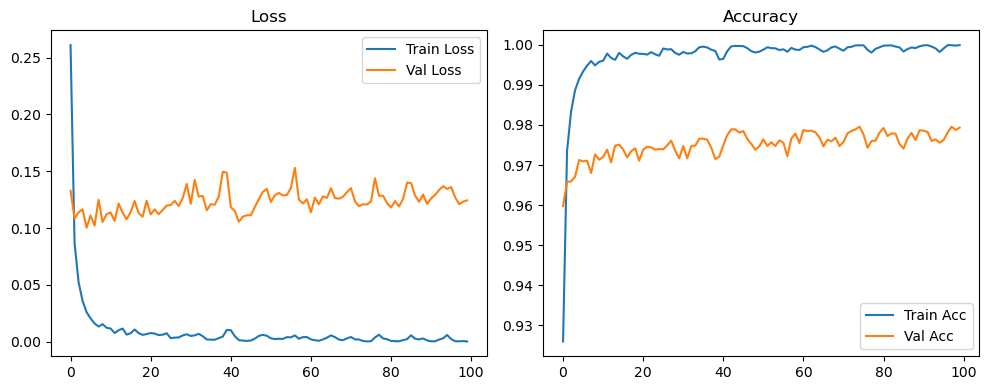

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3503, Acc: 0.9006 | Val Loss: 0.1447, Acc: 0.9555


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1428, Acc: 0.9563 | Val Loss: 0.1180, Acc: 0.9627


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1093, Acc: 0.9648 | Val Loss: 0.1066, Acc: 0.9665


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0857, Acc: 0.9731 | Val Loss: 0.0976, Acc: 0.9698


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0722, Acc: 0.9769 | Val Loss: 0.0981, Acc: 0.9698


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0967, Acc: 0.9708


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9812 | Val Loss: 0.0932, Acc: 0.9737


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9846 | Val Loss: 0.0935, Acc: 0.9726


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.0941, Acc: 0.9731


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9865 | Val Loss: 0.0959, Acc: 0.9735


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9872 | Val Loss: 0.0948, Acc: 0.9740


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0923, Acc: 0.9740


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.0975, Acc: 0.9742


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0964, Acc: 0.9748


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0944, Acc: 0.9760


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0974, Acc: 0.9758


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9912 | Val Loss: 0.0906, Acc: 0.9767


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0957, Acc: 0.9758


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.0977, Acc: 0.9757


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9923 | Val Loss: 0.1005, Acc: 0.9738


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9927 | Val Loss: 0.0882, Acc: 0.9775


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1010, Acc: 0.9761


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0997, Acc: 0.9763


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9937 | Val Loss: 0.0990, Acc: 0.9762


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0973, Acc: 0.9763


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0898, Acc: 0.9773


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0986, Acc: 0.9760


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0923, Acc: 0.9788


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1023, Acc: 0.9766


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0979, Acc: 0.9767


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.1022, Acc: 0.9772


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1006, Acc: 0.9772


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1061, Acc: 0.9754


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1104, Acc: 0.9768


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1113, Acc: 0.9752


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.1074, Acc: 0.9770


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1108, Acc: 0.9770


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1080, Acc: 0.9765


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1084, Acc: 0.9759


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1085, Acc: 0.9781


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1066, Acc: 0.9772


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1065, Acc: 0.9768


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9959 | Val Loss: 0.1107, Acc: 0.9770


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1094, Acc: 0.9752


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1024, Acc: 0.9761


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1077, Acc: 0.9768


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1042, Acc: 0.9782


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1159, Acc: 0.9758


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.1063, Acc: 0.9778


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1093, Acc: 0.9782


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1089, Acc: 0.9778


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1051, Acc: 0.9793


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1094, Acc: 0.9778


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1115, Acc: 0.9772


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1113, Acc: 0.9778


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1096, Acc: 0.9762


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1082, Acc: 0.9778


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1020, Acc: 0.9785


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9968 | Val Loss: 0.1012, Acc: 0.9796


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1050, Acc: 0.9786


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1048, Acc: 0.9781


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1067, Acc: 0.9787


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9779


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1103, Acc: 0.9782


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1190, Acc: 0.9764


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1179, Acc: 0.9773


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1113, Acc: 0.9775


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9968 | Val Loss: 0.1070, Acc: 0.9779


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1079, Acc: 0.9773


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1049, Acc: 0.9789


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1176, Acc: 0.9766


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1150, Acc: 0.9780


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1128, Acc: 0.9772


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1124, Acc: 0.9778


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1110, Acc: 0.9766


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1089, Acc: 0.9788


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1073, Acc: 0.9785


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1131, Acc: 0.9774


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1097, Acc: 0.9777


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1136, Acc: 0.9765


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1122, Acc: 0.9772


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1183, Acc: 0.9772


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1134, Acc: 0.9779


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1115, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1191, Acc: 0.9777


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1120, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.1163, Acc: 0.9777


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1212, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1143, Acc: 0.9780


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1106, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1132, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1177, Acc: 0.9766


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1236, Acc: 0.9772


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1163, Acc: 0.9774


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1063, Acc: 0.9793


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1094, Acc: 0.9786


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1146, Acc: 0.9789


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1090, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1202, Acc: 0.9776


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1163, Acc: 0.9783


Final Test Loss: 0.0970 Accuracy: 0.9807


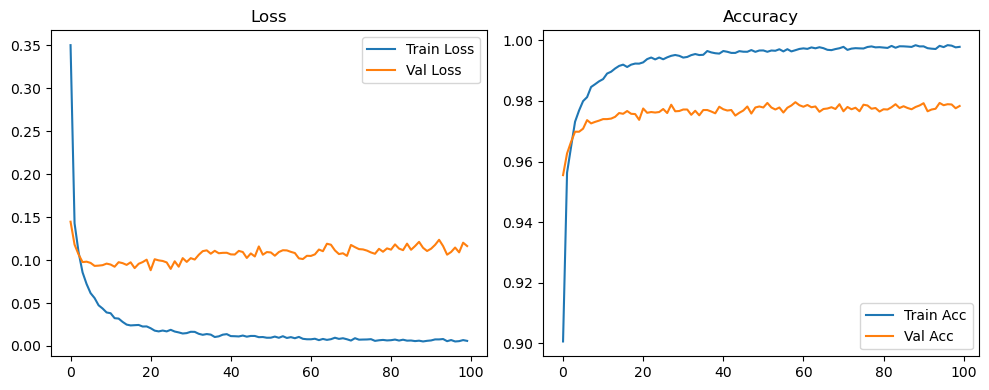

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6196, Acc: 0.8150 | Val Loss: 0.2147, Acc: 0.9350


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2921, Acc: 0.9121 | Val Loss: 0.1717, Acc: 0.9463


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2354, Acc: 0.9291 | Val Loss: 0.1442, Acc: 0.9560


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2018, Acc: 0.9393 | Val Loss: 0.1304, Acc: 0.9584


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1789, Acc: 0.9450 | Val Loss: 0.1237, Acc: 0.9618


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1647, Acc: 0.9509 | Val Loss: 0.1191, Acc: 0.9637


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1525, Acc: 0.9537 | Val Loss: 0.1163, Acc: 0.9655


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1431, Acc: 0.9558 | Val Loss: 0.1084, Acc: 0.9677


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1321, Acc: 0.9599 | Val Loss: 0.1037, Acc: 0.9699


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1298, Acc: 0.9608 | Val Loss: 0.1048, Acc: 0.9695


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1189, Acc: 0.9637 | Val Loss: 0.0996, Acc: 0.9699


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1110, Acc: 0.9665 | Val Loss: 0.0980, Acc: 0.9708


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1056, Acc: 0.9676 | Val Loss: 0.0981, Acc: 0.9718


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1076, Acc: 0.9666 | Val Loss: 0.0908, Acc: 0.9734


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0981, Acc: 0.9689 | Val Loss: 0.0929, Acc: 0.9741


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0957, Acc: 0.9702 | Val Loss: 0.0943, Acc: 0.9733


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0929, Acc: 0.9704 | Val Loss: 0.0962, Acc: 0.9732


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0904, Acc: 0.9715 | Val Loss: 0.0938, Acc: 0.9732


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0858, Acc: 0.9731 | Val Loss: 0.0952, Acc: 0.9738


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9741 | Val Loss: 0.0945, Acc: 0.9735


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0827, Acc: 0.9742 | Val Loss: 0.0910, Acc: 0.9758


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9735 | Val Loss: 0.0950, Acc: 0.9732


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9760 | Val Loss: 0.0935, Acc: 0.9741


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9762 | Val Loss: 0.0908, Acc: 0.9732


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0724, Acc: 0.9768 | Val Loss: 0.0972, Acc: 0.9732


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0738, Acc: 0.9762 | Val Loss: 0.0931, Acc: 0.9753


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0703, Acc: 0.9770 | Val Loss: 0.0917, Acc: 0.9748


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0936, Acc: 0.9747


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9793 | Val Loss: 0.0901, Acc: 0.9752


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9799 | Val Loss: 0.0894, Acc: 0.9757


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0658, Acc: 0.9790 | Val Loss: 0.0890, Acc: 0.9753


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0662, Acc: 0.9791 | Val Loss: 0.0912, Acc: 0.9759


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9801 | Val Loss: 0.0897, Acc: 0.9761


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9806 | Val Loss: 0.0910, Acc: 0.9750


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.0957, Acc: 0.9745


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9816 | Val Loss: 0.0929, Acc: 0.9752


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9826 | Val Loss: 0.0925, Acc: 0.9760


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.0910, Acc: 0.9760


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.0949, Acc: 0.9762


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0551, Acc: 0.9832 | Val Loss: 0.0945, Acc: 0.9754


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9838 | Val Loss: 0.0943, Acc: 0.9751


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9831 | Val Loss: 0.0965, Acc: 0.9742


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 0.0962, Acc: 0.9752


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0519, Acc: 0.9830 | Val Loss: 0.0915, Acc: 0.9762


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9825 | Val Loss: 0.0927, Acc: 0.9760


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9837 | Val Loss: 0.0917, Acc: 0.9762


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9842 | Val Loss: 0.0913, Acc: 0.9770


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.0954, Acc: 0.9759


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9846 | Val Loss: 0.0895, Acc: 0.9766


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9847 | Val Loss: 0.0909, Acc: 0.9767


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.0953, Acc: 0.9761


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.0924, Acc: 0.9762


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0962, Acc: 0.9757


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.0951, Acc: 0.9763


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0894, Acc: 0.9772


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9859 | Val Loss: 0.0909, Acc: 0.9758


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0937, Acc: 0.9758


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9867 | Val Loss: 0.0916, Acc: 0.9773


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0968, Acc: 0.9752


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 0.0960, Acc: 0.9758


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9876 | Val Loss: 0.0987, Acc: 0.9761


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.0985, Acc: 0.9758


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.0971, Acc: 0.9755


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.0937, Acc: 0.9771


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.0945, Acc: 0.9771


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.0945, Acc: 0.9768


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0993, Acc: 0.9757


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.0928, Acc: 0.9768


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.0995, Acc: 0.9756


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9875 | Val Loss: 0.1042, Acc: 0.9748


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9873 | Val Loss: 0.0966, Acc: 0.9758


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.0997, Acc: 0.9746


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9887 | Val Loss: 0.0976, Acc: 0.9763


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0969, Acc: 0.9756


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0999, Acc: 0.9756


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.0988, Acc: 0.9766


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0976, Acc: 0.9773


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9887 | Val Loss: 0.0989, Acc: 0.9763


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 0.0971, Acc: 0.9778


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.0954, Acc: 0.9776


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.0985, Acc: 0.9755


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9892 | Val Loss: 0.1014, Acc: 0.9759


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.1007, Acc: 0.9765


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9892 | Val Loss: 0.1001, Acc: 0.9762


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9885 | Val Loss: 0.1009, Acc: 0.9763


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.1009, Acc: 0.9763


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0952, Acc: 0.9764


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.0939, Acc: 0.9762


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0981, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0966, Acc: 0.9773


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.1002, Acc: 0.9765


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.1021, Acc: 0.9762


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.0977, Acc: 0.9770


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1006, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.1001, Acc: 0.9767


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.0996, Acc: 0.9777


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1030, Acc: 0.9770


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.1027, Acc: 0.9764


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1012, Acc: 0.9755


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9910 | Val Loss: 0.1040, Acc: 0.9752


Final Test Loss: 0.0867 Accuracy: 0.9806


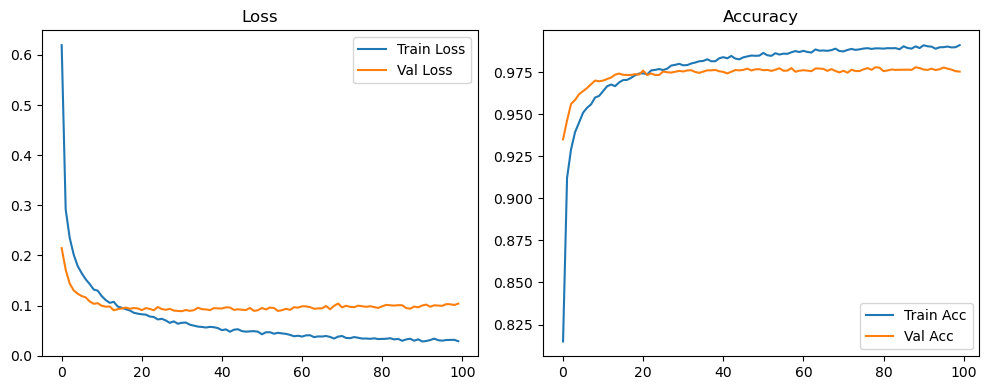

🏆 Best Config: batch256_lr0.01_0.005_0.001_dp0.2 Accuracy: 0.9835


In [8]:
root_path = "MLP_256_4bit_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)